# Librerias

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns

import statsmodels.api as sm

import yfinance as yf

from pypfopt import EfficientFrontier, expected_returns
from pypfopt import risk_models
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt import objective_functions


import quantstats as qs
qs.extend_pandas()

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Datos

## Funcion de descarga

In [3]:
def download(tickers, start, end, threshold=0.20):
    # Crear un DataFrame vacío para almacenar los datos
    acciones_df = yf.download(tickers, start=start, end=end)['Adj Close']

    # Obtener la lista de columnas del DataFrame resultante
    acciones_cols = acciones_df.columns.tolist()
    print(f"Total columns: {len(acciones_df.columns)}")

    # Detectar cuáles tickers no están en las columnas del DataFrame
    for ticker in tickers:
        if ticker not in acciones_cols:
            print(f"Ticker not found in DataFrame: {ticker}")

    # Eliminar columnas con más del threshold de sus valores como NA
    threshold1 = (acciones_df.isna().sum()*100)/ (len(acciones_df))
    columns_to_drop = acciones_df.columns[threshold1 > threshold].tolist()

    # Eliminar esas columnas del DataFrame
    acciones_df.drop(columns=columns_to_drop, inplace=True)

    # Mandar un mensaje con el nombre de las columnas eliminadas
    if columns_to_drop:
        print(f"Las siguientes columnas fueron eliminadas porque contienen más del {threshold*100}% de sus valores como NA: {', '.join(columns_to_drop)}")
        print(f"Total de columnas eliminadas: {len(columns_to_drop)}")
    else:
        print(f"No se encontraron columnas con más del {threshold/10}% de sus valores como NA.")

    # Arreglar nombre de columnas
    acciones_col = acciones_df.columns.tolist()
    acciones_df.columns = acciones_col

    acciones_df.dropna(inplace=True)
    return acciones_df

## Descarga

In [21]:
# Fecha de inicio
start = '2020-12-31'
end = '2024-12-01'

### Cripto

In [22]:
# Obtener datos de criptomonedas con Yahoo Finance
tk_cry = ['BTC-USD', 'ETH-USD','XRP-USD', 'BNB-USD', 'SOL-USD']
tk_cry.sort()
cripto = yf.download(tk_cry, start=start)['Adj Close']
cripto.columns = [tk.split('-')[0] for tk in tk_cry]
cripto.dropna(inplace=True)
cripto.head()

[*********************100%***********************]  5 of 5 completed


,BNB,BTC,ETH,SOL,XRP
Date,,,,,
2020-12-31 00:00:00+00:00,37.376034,29001.720703,737.803406,1.510898,0.219846
2021-01-01 00:00:00+00:00,37.905010,29374.152344,730.367554,1.842084,0.237444
2021-01-02 00:00:00+00:00,38.241592,32127.267578,774.534973,1.799275,0.221655
2021-01-03 00:00:00+00:00,41.148979,32782.023438,975.507690,2.161752,0.225848
2021-01-04 00:00:00+00:00,40.926353,31971.914062,1040.233032,2.485097,0.236677


### Materias

In [23]:
# Definir los tickers de los principales commodities
commodities_tickers = {
    'Petroleo': 'CL=F',
    'Oro': 'GC=F',
    'Cobre': 'HG=F',
    'Gas_Natural': 'NG=F',
    'Plata': 'SI=F',
    'Maiz': 'ZC=F',
    'Soja': 'ZS=F',
    'Trigo': 'ZW=F'
}

tickers_materias = list(commodities_tickers.values())
materias =  yf.download(tickers_materias, start=start, end=end)['Adj Close']
materias.dropna(inplace=True)

materias2 = materias.copy()
# Renombrar en funcion de su valor en el diccionario
tickers_to_mats = {v: k for k, v in commodities_tickers.items()}
materias.rename(columns=tickers_to_mats, inplace=True)
mats_cols = materias.columns.tolist()
materias.columns = mats_cols

# Mostrar los primeros datos del DataFrame
materias.head()

[*********************100%***********************]  8 of 8 completed


,Petroleo,Oro,Cobre,Gas_Natural,Plata,Maiz,Soja,Trigo
Date,,,,,,,,
2020-12-31 00:00:00+00:00,48.520000,1893.099976,3.5140,2.539,26.332001,484.00,1315.25,640.50
2021-01-04 00:00:00+00:00,47.619999,1944.699951,3.5530,2.581,27.284000,483.75,1316.50,642.00
2021-01-05 00:00:00+00:00,49.930000,1952.699951,3.6405,2.702,27.570999,491.75,1350.00,654.00
2021-01-06 00:00:00+00:00,50.630001,1906.900024,3.6500,2.716,26.973000,495.00,1365.25,647.50
2021-01-07 00:00:00+00:00,50.830002,1912.300049,3.6955,2.729,27.200001,494.00,1360.50,642.25


### Indices

In [72]:
# Definir los tickers de los principales índices bursátiles de cada país
indices_paises = {
    'MSCI' : 'ACWI',
    'China': '000001.SS',
    'Australia': '^AXJO',
    'Brazil': '^BVSP',
    'UK': '^FTSE',
    'Alemania': '^GDAXI',
    'USA': '^GSPC',
    'Canada': '^GSPTSE',
    'España': '^IBEX',
    'Argentina': '^MERV',
    'Mexico': '^MXX',
    'Japon': '^N225',
    'India': '^NSEI',
    'Europa': '^STOXX50E'
}

# Descargar los datos de indices desde el directorio y que la columna se llame como el nombre del directorio
tickers_indices = list(indices_paises.values())
indices =  yf.download(tickers_indices, start=start, end=end)['Adj Close']
indices.dropna(inplace=True)

# Renombrar en funcion de su valor en el diccionario
tickers_to_countries = {v: k for k, v in indices_paises.items()}
indices.rename(columns=tickers_to_countries, inplace=True)
indices_cols = indices.columns.tolist()
indices.columns = indices_cols

indices_r = indices.pct_change().dropna()
# Mostrar los primeros datos del DataFrame
indices_r.head()

[*********************100%***********************]  14 of 14 completed


,China,MSCI,Australia,Brazil,UK,Alemania,USA,Canada,España,Argentina,Mexico,Japon,India,Europa
Date,,,,,,,,,,,,,,
2021-01-05 00:00:00+00:00,0.007342,0.010308,-0.000344,0.005609,0.006147,-0.005502,0.007083,0.008826,-0.000951,0.017031,0.004589,-0.003659,0.004712,-0.004640
2021-01-06 00:00:00+00:00,0.006291,0.005595,-0.011194,0.005267,0.034723,0.017636,0.005710,0.008234,0.031984,0.005524,0.015121,-0.003781,-0.003750,0.017822
2021-01-07 00:00:00+00:00,0.007133,0.010474,0.015877,0.017563,0.002207,0.005490,0.014847,0.011190,0.004251,0.011970,0.013195,0.016048,-0.000629,0.003140
2021-01-08 00:00:00+00:00,-0.001704,0.008853,0.006838,0.025591,0.002377,0.005820,0.005492,0.000804,0.002612,-0.015752,0.011705,0.023605,0.014847,0.006247
2021-01-12 00:00:00+00:00,0.010708,-0.005244,-0.011660,-0.008627,-0.017342,-0.008859,-0.006142,-0.003120,-0.007350,-0.009134,-0.016639,0.000899,0.015069,-0.009031


### Acciones por pais

#### Mexico

In [26]:
# Definir los tickers de las empresas de la Bolsa Mexicana de Valores
tickers_mexico = [
    'ALFAA.MX', 'ALSEA.MX', 'AMXB.MX', 'AC.MX', 'ASURB.MX', 'BBAJIOO.MX', 'CUERVO.MX', 'BIMBOA.MX', 'BOLSAA.MX', 'CEMEXCPO.MX',
    'KOFUBL.MX', 'VOLARA.MX', 'VESTA.MX', 'ELEKTRA.MX', 'GFNORTEO.MX', 'FEMSAUBD.MX', 'GCC.MX', 'LABB.MX', 'GENTERA.MX', 'GMEXICOB.MX',
    'GRUMAB.MX', 'GAPB.MX', 'GCARSOA1.MX', 'CHDRAUIB.MX', 'GFINBURO.MX', 'TLEVISACPO.MX', 'KIMBERA.MX', 'MEGACPO.MX', 'OMAB.MX', 'ORBIA.MX',
    'PE&OLES.MX', 'PINFRA.MX', 'Q.MX', 'RA.MX', 'WALMEX.MX'
]

# Descargar los datos de precios de las acciones de la Bolsa Mexicana de Valores
mex_acciones = download(tickers_mexico, start = start, end=end, threshold=0.20)
mex_acciones.dropna(inplace=True)

# Mostrar los primeros datos del DataFrame
mex_acciones.head()

[*********************100%***********************]  35 of 35 completed


Total columns: 35
No se encontraron columnas con más del 0.02% de sus valores como NA.


,AC.MX,ALFAA.MX,ALSEA.MX,AMXB.MX,ASURB.MX,BBAJIOO.MX,BIMBOA.MX,BOLSAA.MX,CEMEXCPO.MX,CHDRAUIB.MX,...,OMAB.MX,ORBIA.MX,PE&OLES.MX,PINFRA.MX,Q.MX,RA.MX,TLEVISACPO.MX,VESTA.MX,VOLARA.MX,WALMEX.MX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,81.532806,13.043242,25.465109,12.910332,283.813934,18.076994,40.524754,37.665936,10.264617,27.337988,...,93.695587,44.075310,336.622833,149.925217,89.228310,71.029320,30.543747,38.277855,24.770000,51.275818
2021-01-04 00:00:00+00:00,80.024521,13.052312,25.897888,12.910332,283.969086,17.460735,40.159237,38.424690,10.384554,27.908321,...,93.863434,44.122448,382.071594,152.230026,90.452560,70.443184,31.028860,39.274525,23.889999,52.411613
2021-01-05 00:00:00+00:00,81.779922,12.970678,25.770023,12.910332,285.960480,17.447483,40.346684,38.464619,10.654412,27.280954,...,94.454544,43.990459,381.321960,148.525238,89.944542,70.119270,32.027088,38.524559,23.510000,53.089432
2021-01-06 00:00:00+00:00,82.453110,12.997890,26.124113,12.910332,303.081421,17.546879,40.224846,38.808056,11.543946,27.851284,...,98.526695,44.376991,380.522339,145.520416,90.069458,70.103859,32.586834,39.195580,24.190001,54.783974
2021-01-07 00:00:00+00:00,85.512299,13.025101,26.291325,13.340677,298.133057,17.619770,40.787170,39.199409,11.643893,28.041399,...,99.468086,45.225510,389.927917,151.256882,90.627449,71.584587,34.088833,39.531094,23.900000,53.776405


#### Estados unidos

In [27]:
# Lista de empresas del Syp500
tickers_sp500 = [
    'BA', 'GM', 'CVX', 'C', 'BAC', 'T', 'CAT', 'INTC', 'MSFT', 'F', 'EBAY', 'DELL', 'DIS', 'DOW', 'CSCO', 'DE', 'FDX', 'GIS', 'GLW', 'GS',
    'JPM', 'KMB', 'KHC', 'KO', 'MCD', 'LLY', 'ORCL', 'MRK', 'MSI', 'MMM', 'VRTX', 'MNST', 'FITB', 'CTAS', 'ADSK', 'GILD', 'GOOGL', 'FISV', 'ADBE', 'QCOM', 'WBD', 'AMAT', 'STLD', 'CDNS', 'MCHP', 'WYNN', 'ISRG', 'NDAQ', 'HSIC', 'PAYX', 'VRSN', 'AAPL', 'FAST', 'NTRS', 'CHRW', 'PCAR', 'AMZN', 'ROST', 'NTAP', 'GRMN', 'COST', 'LRCX', 'INTU', 'EXPE', 'CTSH', 'AKAM', 'KLAC', 'JNPR', 'AMGN', 'EXPD', 'EA', 'TROW', 'BIIB', 'SCHW', 'HBAN', 'GEN', 'NVDA', 'SBUX', 'CINF', 'AXON', 'HOLX', 'CMCSA', 'MDT', 'DOV', 'NOC', 'MGM', 'MA', 'GD', 'DTE', 'ADI', 'CAH', 'XEL', 'DHI', 'IPG', 'LMT', 'WAT', 'ACN', 'D', 'XOM', 'CI', 'PEG', 'NI', 'ZBH', 'CSX', 'ICE', 'LUV', 'ITW', 'DRI', 'TFC', 'HAL', 'PLD', 'MKC', 'HST', 'EL', 'IP', 'EMR', 'CLX', 'COP', 'CL', 'PNW', 'RF', 'CNP', 'MET', 'EXC', 'BAX', 'OXY', 'SO', 'TPR', 'LEN', 'CPB', 'STT', 'PGR', 'VMC', 'PH', 'GPC', 'CBRE', 'DD', 'SHW', 'PFE', 'WFC', 'WMT', 'EIX', 'SNA', 'EFX', 'MCK', 'ETR', 'CMS', 'AMP', 'AIG', 'RL', 'IFF', 'GWW', 'STZ', 'AMT', 'PM', 'FIS', 'MO', 'BALL', 'HIG', 'HSY', 'MS', 'PNC', 'WM', 'COR', 'AIZ', 'KR', 'TAP', 'HD', 'BDX', 'SJM', 'BBY', 'ADM', 'BF-B', 'IBM', 'UNP', 'MU', 'AVY', 'MRO', 'CF', 'APA', 'DUK', 'KEY', 'LH', 'BXP', 'WDC', 'PPG', 'SPGI', 'WMB', 'ELV', 'J', 'EMN', 'VZ', 'NUE', 'OMC', 'AVB', 'MAR', 'IR', 'BMY', 'AEP', 'TMO', 'NEM', 'PSA', 'TRV', 'SWK', 'BEN', 'HUM', 'PARA', 'CB', 'JNJ', 'TSN', 'TGT', 'JBL', 'AXP', 'MAS', 'SYK', 'DFS', 'PRU', 'ABT', 'GE', 'DGX', 'UPS', 'CVS', 'PPL', 'SPG', 'JCI', 'CMI', 'ALL', 'SRE', 'DVN', 'CAG', 'TJX', 'FE', 'GL', 'RTX', 'PHM', 'VLO', 'BSX', 'COF', 'PCG', 'NSC', 'AFL', 'EQR', 'APD', 'PFG', 'TXN', 'HPQ', 'HON', 'AMD', 'MTB', 'MOS', 'RVTY', 'LVS', 'FCX', 'AZO', 'SYY', 'AEE', 'ETN', 'CRM', 'ED', 'AES', 'TXT', 'USB', 'V', 'BKR', 'HES', 'YUM', 'MMC', 'K', 'KIM', 'ECL', 'EOG', 'AON', 'HAS', 'BK', 'SLB', 'WBA', 'ROK', 'PEP', 'UNH', 'TER', 'DHR', 'STX', 'A', 'DAL', 'MCO', 'NKE', 'PG', 'WY', 'ADP', 'KDP', 'LOW', 'UAL', 'NFLX', 'NWSA', 'EQIX', 'BKNG', 'ORLY', 'BLK', 'CME', 'JBHT', 'L', 'NEE', 'FSLR', 'VTRS', 'FFIV', 'EW', 'NWS', 'APH', 'BRK-B', 'CTRA', 'KMX', 'CMG', 'DVA', 'EQT', 'FMC', 'LHX', 'DOC', 'WELL', 'HRL', 'IVZ', 'IRM', 'ES', 'NRG', 'OKE', 'RSG', 'ROP', 'VTR', 'WEC', 'BX', 'MPC', 'AVGO', 'NXPI', 'TSLA', 'TTWO', 'DLTR', 'ALGN', 'ANSS', 'BLDR', 'CHTR', 'CSGP', 'DXCM', 'ERIE', 'FTNT', 'IDXX', 'INCY', 'JKHY', 'MKTX', 'MPWR', 'NDSN', 'ON', 'PTC', 'PODD', 'POOL', 'SMCI', 'TECH', 'ZBRA', 'BWA', 'TMUS', 'PWR', 'LDOS', 'TEL', 'MAA', 'CRL', 'HII', 'MTD', 'FRT', 'LYV', 'MLM', 'FDS', 'RJF', 'DLR', 'ESS', 'FICO', 'COO', 'MOH', 'EG', 'REG', 'DG', 'TDG', 'ATO', 'BRO', 'DPZ', 'HCA', 'HUBB', 'ROL', 'STE', 'RMD', 'MSCI', 'NVR', 'CCL', 'WST', 'TDY', 'TYL', 'TRGP', 'META', 'ARE', 'TFX', 'WAB', 'EVRG', 'WTW', 'CZR', 'ENPH', 'APTV', 'CCI', 'EPAM', 'PNR', 'MDLZ', 'SWKS', 'TSCO', 'DECK', 'LULU', 'REGN', 'URI', 'KMI', 'ALB', 'CNC', 'PSX', 'XYL', 'UDR', 'SBAC', 'IT', 'IEX', 'UHS', 'LKQ', 'BR', 'EXR', 'CPT', 'MHK', 'AWK', 'LNT', 'CE', 'BG', 'AME', 'WRB', 'LYB', 'RCL', 'CPAY', 'PKG', 'AJG', 'CHD', 'GNRC', 'GPN', 'O', 'AOS', 'ACGL', 'CBOE', 'CPRT', 'ODFL', 'SNPS', 'TRMB', 'ULTA', 'VRSK', 'ABBV', 'FANG', 'NCLH', 'ZTS', 'IQV', 'NOW', 'PANW', 'KKR','CDW', 'HLT', 'ALLE', 'GOOG', 'PAYC', 'ANET', 'SYF', 'CTLT', 'CFG', 'KEYS', 'QRVO', 'GDDY', 'PYPL', 'HPE', 'MTCH', 'FTV', 'LW', 'INVH', 'VST', 'VICI', 'DAY', 'MRNA', 'UBER', 'FOXA', 'FOX', 'CRWD', 'CTVA', 'AMCR', 'TT', 'OTIS', 'CARR', 'HWM', 'PLTR', 'ABNB', 'CEG', 'GEHC', 'KVUE', 'VLTO', 'LIN', 'GEV'
]

# Descargar los datos de precios d acciones del SP500
usa_acciones = download(tickers_sp500, start = start, end=end)
usa_acciones.dropna(inplace=True)

# Mostrar los primeros datos del DataFrame
usa_acciones.head()

[*********************100%***********************]  500 of 500 completed


Total columns: 500
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: CEG, FISV, GEHC, GEV, KVUE, MRO, VLTO
Total de columnas eliminadas: 7


,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,115.460648,129.751572,91.254501,146.800003,101.929962,36.070000,246.602875,500.119995,137.608261,45.564980,...,200.037033,28.320213,111.033875,59.231087,35.212963,97.182655,100.815727,145.351959,384.329987,160.329330
2021-01-04 00:00:00+00:00,115.796394,126.544205,89.772621,139.149994,101.576225,34.900002,242.118515,485.339996,136.015411,45.076893,...,193.409637,27.712097,105.198273,58.333801,35.452160,95.177689,98.271194,144.474731,378.130005,158.478989
2021-01-05 00:00:00+00:00,116.743156,128.108780,90.700935,148.300003,102.833000,35.040001,243.496857,485.690002,138.446594,45.953663,...,191.795502,27.973921,108.435905,57.765202,37.160698,95.063126,98.280472,146.974442,380.570007,159.583420
2021-01-06 00:00:00+00:00,119.944519,123.796448,89.917404,142.770004,102.618896,36.580002,246.159149,466.309998,139.070679,47.815670,...,193.409637,28.117510,109.085396,59.044529,38.108940,99.073021,98.819122,151.162598,394.820007,161.927795
2021-01-07 00:00:00+00:00,123.136162,128.020752,90.879761,151.270004,103.615013,36.240002,248.481613,477.739990,144.948395,47.390839,...,194.881363,28.387793,108.002922,57.889584,38.407936,103.569832,98.066887,150.266479,409.100006,161.782471


#### China

In [28]:
# Lista de empresas del FTSE a50 Chino
tickers_ftse_china_a50 = [
    '601088.SS', '601988.SS', '600028.SS', '600000.SS', '600016.SS', '600018.SS', '600019.SS', '600030.SS', '600036.SS', '600050.SS',
    '600048.SS', '600104.SS', '600276.SS', '600519.SS', '600585.SS', '600887.SS', '600900.SS', '601166.SS', '601169.SS', '601186.SS',
    '601360.SS', '601336.SS', '601288.SS', '601318.SS', '601328.SS', '601390.SS', '601398.SS', '601601.SS', '601628.SS', '601668.SS',
    '601766.SS', '601800.SS', '601818.SS', '601857.SS', '601939.SS', '601998.SS', '603288.SS', '000002.SZ', '000651.SZ', '002415.SZ',
    '002304.SZ', '002352.SZ', '000333.SZ', '000001.SZ', '000858.SZ', '601211.SS', '001979.SZ', '300498.SZ', '601138.SS', '300760.SZ'
]

# Descargar los datos de precios de las acciones del FTSE a50 Chino
china_acciones = download(tickers_ftse_china_a50, start = start, end=end)
china_acciones.dropna(inplace=True)

# Mostrar los primeros datos del DataFrame
china_acciones.head()

[*********************100%***********************]  50 of 50 completed

Total columns: 50
No se encontraron columnas con más del 0.02% de sus valores como NA.


,000001.SZ,000002.SZ,000333.SZ,000651.SZ,000858.SZ,001979.SZ,002304.SZ,002352.SZ,002415.SZ,300498.SZ,...,601628.SS,601668.SS,601766.SS,601800.SS,601818.SS,601857.SS,601939.SS,601988.SS,601998.SS,603288.SS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,16.809931,24.280367,85.134735,47.032265,268.264648,11.420588,210.469894,83.010025,44.446136,17.425579,...,35.586063,4.129219,4.696704,6.544699,3.136364,3.395991,4.984231,2.498877,3.982848,109.605492
2021-01-04 00:00:00+00:00,16.166739,23.502043,85.627693,47.761215,273.963593,11.111227,220.271408,85.126907,45.628071,18.543953,...,35.066963,4.079369,4.670169,6.490610,3.057759,3.428724,4.960421,2.491019,3.967261,109.594559
2021-01-05 00:00:00+00:00,15.792992,23.612022,87.815735,49.553211,294.121368,11.119820,235.183304,87.968231,50.190872,18.954979,...,34.751801,4.054445,4.732084,6.472580,3.034177,3.420541,4.920738,2.491019,3.967261,109.999016
2021-01-06 00:00:00+00:00,17.001148,24.322668,87.314125,48.649620,301.768982,11.128412,228.851120,87.093239,50.777256,18.706450,...,36.142239,4.112603,5.209715,6.679919,3.081341,3.477822,4.968359,2.498877,3.967261,112.928528
2021-01-07 00:00:00+00:00,17.296669,24.356508,90.652405,49.127987,303.331604,11.179974,228.315994,86.810989,53.406826,18.467484,...,36.466679,4.087677,5.430840,6.598786,3.097062,3.477822,5.008041,2.506735,3.967261,117.279091


#### Bolsa Europa

In [29]:
# Lista de empresas del Eurostoxx 50
tickers_eurostoxx50 = [
    'INGA.AS', 'PHIA.AS', 'STLAP.PA', 'BAS.DE', 'BAYN.DE', 'ALV.DE', 'ADS.DE', 'SIE.DE', 'DPWA.F', 'MBG.DE', 'DB1.DE', 'AI.PA', 'CS.PA', 'BN.PA', 'BNP.PA', 'MC.PA', 'OR.PA', 'SU.PA', 'EL.PA', 'RI.PA', 'AIR.PA', 'SAN.PA', 'TTE.PA', 'DG.PA', 'BBVA.MC', 'ITX.MC', 'IBE.MC', 'SAN.MC', 'KNEBV.HE', 'BMW.DE', 'DTE.DE', 'IFX.DE', 'MUV2.DE', 'SAP.DE', 'KER.PA', 'FLTR.L', 'AD.AS', 'ASML.AS', 'ISP.MI', 'ENEL.MI', 'ENI.MI', 'RMS.PA', 'SAF.PA', 'ABI.BR', 'VOW3.DE', 'RACE.MI', 'ADYEN.AS', 'PRX.AS']

# Descarga individual
euro_acciones = download(tickers_eurostoxx50, start = start, end= end)
euro_acciones.dropna(inplace=True)

# Mostrar los primeros datos del DataFrame
euro_acciones.head()

[*********************100%***********************]  48 of 48 completed


Total columns: 48
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ADS.DE, ALV.DE, BAS.DE, BAYN.DE, BBVA.MC, BMW.DE, DB1.DE, DPWA.F, DTE.DE, ENEL.MI, ENI.MI, FLTR.L, IBE.MC, IFX.DE, ISP.MI, ITX.MC, KNEBV.HE, MBG.DE, MUV2.DE, RACE.MI, SAN.MC, SAP.DE, SIE.DE, VOW3.DE
Total de columnas eliminadas: 24


,ABI.BR,AD.AS,ADYEN.AS,AI.PA,AIR.PA,ASML.AS,BN.PA,BNP.PA,CS.PA,DG.PA,...,OR.PA,PHIA.AS,PRX.AS,RI.PA,RMS.PA,SAF.PA,SAN.PA,STLAP.PA,SU.PA,TTE.PA
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,54.471451,20.050529,1905.0,103.125793,86.308441,383.615021,46.818352,33.533646,15.259547,70.590851,...,289.962860,36.538727,40.164196,141.115067,858.330750,112.709557,67.429283,3.626625,109.498657,27.686129
2021-01-04 00:00:00+00:00,54.662544,20.640507,1859.5,104.815750,86.414185,392.010101,47.375710,33.459747,15.201675,71.770836,...,290.802582,38.111950,40.218742,142.825012,863.014587,112.903969,67.686317,3.626625,112.691978,27.642168
2021-01-05 00:00:00+00:00,54.633877,20.545069,1829.0,103.701912,86.356514,392.637329,47.549885,33.389725,15.195420,70.556145,...,287.817108,37.352463,41.036942,139.855118,848.962769,113.146973,67.677750,3.626625,111.627541,28.369484
2021-01-06 00:00:00+00:00,56.153076,20.614477,1733.0,103.932373,86.683365,388.729248,47.967911,35.233475,15.844529,73.263161,...,288.096954,37.632057,40.482380,137.830170,847.011169,113.049782,67.266495,3.626625,114.728302,29.616325
2021-01-07 00:00:00+00:00,55.799553,20.579771,1714.5,104.738930,86.154633,389.742432,47.218956,36.026989,15.942286,73.384636,...,286.977448,37.281521,38.073261,140.125092,854.232300,112.563751,66.589630,3.626625,117.088593,29.940010


#### España

In [30]:
# Lista de empresas del IBEX 35
tickers_ibex35 = [
    'ACS.MC', 'ACX.MC', 'BBVA.MC', 'BKT.MC', 'ANA.MC', 'CABK.MC', 'ENG.MC', 'NTGY.MC', 'GRF.MC', 'FER.MC', 'RED.MC', 'ITX.MC', 'REP.MC', 'IBE.MC', 'IDR.MC', 'MAP.MC', 'TEF.MC', 'SCYR.MC', 'SAB.MC', 'SAN.MC', 'COL.MC', 'IAG.MC', 'ELE.MC', 'AMS.MC', 'ROVI.MC', 'SLR.MC', 'FDR.MC', 'MTS.MC', 'MRL.MC', 'LOG.MC', 'AENA.MC', 'CLNX.MC', 'UNI.MC', 'ANE.MC', 'PUIG.MC']


# Descargar los datos de precios de las acciones del IBEX 35
es_acciones = download(tickers_ibex35, start = start, end=end)


# Mostrar los primeros datos del DataFrame
es_acciones.head()

[*********************100%***********************]  35 of 35 completed


Total columns: 35
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ANE.MC, PUIG.MC
Total de columnas eliminadas: 2


,ACS.MC,ACX.MC,AENA.MC,AMS.MC,ANA.MC,BBVA.MC,BKT.MC,CABK.MC,CLNX.MC,COL.MC,...,NTGY.MC,RED.MC,REP.MC,ROVI.MC,SAB.MC,SAN.MC,SCYR.MC,SLR.MC,TEF.MC,UNI.MC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,20.350677,7.234211,131.935242,57.739609,102.505714,3.197323,2.483563,1.663203,45.254555,6.863122,...,15.118578,13.201489,6.798978,35.449249,0.298870,2.189646,1.636955,23.639999,2.374329,0.598287
2021-01-04 00:00:00+00:00,20.245743,7.442412,128.502319,56.285458,102.857048,3.231397,2.438652,1.685368,47.115593,6.811810,...,15.202301,13.421842,6.680306,35.823383,0.293635,2.214233,1.612643,24.520000,2.413841,0.599124
2021-01-05 00:00:00+00:00,20.575550,7.456827,128.316772,56.440563,102.330032,3.228228,2.521737,1.689326,46.415401,6.833190,...,15.094657,13.108094,7.194555,36.571651,0.304442,2.221998,1.613453,26.580000,2.431401,0.574858
2021-01-06 00:00:00+00:00,21.025290,7.637803,130.914642,57.758999,104.965149,3.414441,2.675556,1.785113,43.789680,6.867399,...,15.377728,13.192071,7.293450,38.161724,0.323860,2.374704,1.672611,28.240000,2.551398,0.581552
2021-01-07 00:00:00+00:00,20.792923,7.863621,129.244568,55.063965,110.762375,3.448514,2.787833,1.852401,43.080273,6.790430,...,15.752504,13.076105,7.319822,39.284130,0.344291,2.409645,1.659645,30.940001,2.622372,0.589920


#### Alemania

In [31]:
# Lista de empresas del DAX Aleman
dax_tickers = [
    "BAS.DE", "BAYN.DE", "ALV.DE", "ADS.DE", "SIE.DE", "DBK.DE", "CON.DE", "DPWA.F", "MBG.DE", "PAH3.DE", "HEN3.DE", "CBK.DE", "DB1.DE", "BMW.DE", "DTE.DE", "MRK.DE", "IFX.DE", "MUV2.DE", "SAP.DE", "RHM.DE", "BEI.DE", "FRE.DE", "HNR1.DE", "RWE.DE", "MTX.DE", "SY1.DE", "HEI.DE", "QIA.DE", "EOAN.DE", "BNR.DE", "SRT3.DE", "VOW3.DE", "VNA.DE", "ZAL.DE", "1COV.DE", "AIR.DE", "SHL.DE", "ENR.DE", "DTG.DE", "P911.DE"]


# Descargar los datos de precios de las acciones del DAX Aleman
ale_acciones = download(dax_tickers, start=start, end=end)

# Mostrar los primeros datos del DataFrame
ale_acciones.head()

[*********************100%***********************]  40 of 40 completed

Total columns: 40
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: DTG.DE, P911.DE
Total de columnas eliminadas: 2


,1COV.DE,ADS.DE,AIR.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE,BNR.DE,CBK.DE,...,RHM.DE,RWE.DE,SAP.DE,SHL.DE,SIE.DE,SRT3.DE,SY1.DE,VNA.DE,VOW3.DE,ZAL.DE
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,46.774498,284.892212,86.767395,162.429565,50.021690,43.941284,92.477394,55.347523,59.073349,4.988481,...,82.006378,32.500244,100.030579,40.021191,105.258720,345.171875,105.710205,40.041870,94.407555,94.080002
2021-01-05 00:00:00+00:00,46.394505,279.298553,86.815697,160.761261,49.643970,44.106205,91.563698,54.577312,58.583786,5.114433,...,81.166710,31.822212,99.764641,40.179825,105.043938,350.515717,104.604042,40.230747,93.619133,96.599998
2021-01-06 00:00:00+00:00,47.679222,281.323853,87.076508,169.119095,51.933449,45.849056,91.369308,54.677437,59.726086,5.402597,...,81.446602,33.051708,100.182541,41.182911,109.070999,343.192657,103.065048,38.611801,93.759026,96.099998
2021-01-07 00:00:00+00:00,49.036316,278.237671,86.564529,167.728851,52.735157,46.642483,90.786102,54.700539,61.829372,5.446490,...,82.248947,33.322918,99.270744,41.056942,111.236679,341.015533,101.526039,38.368958,94.229523,96.540001
2021-01-08 00:00:00+00:00,49.018223,284.602875,87.105492,168.260391,52.866199,45.911465,91.447067,54.292332,61.883766,5.215577,...,82.454185,34.941151,100.847389,41.654137,110.968208,351.505310,101.958885,38.868134,93.123184,97.580002


#### Reino Unido

In [32]:
# Lista de empresas del FTSE 100 ingles
FTSE_tickers = [
    "BATS.L", "HSBA.L", "BARC.L", "IHG.L", "BP.L", "NXT.L", "LLOY.L", "EZJ.L", "MKS.L", "NWG.L", "PRU.L", "VOD.L",
    "AZN.L", "LGEN.L", "IMB.L", "RKT.L", "KGF.L", "REL.L", "CNA.L", "III.L", "WPP.L", "TSCO.L", "DGE.L", "HIK.L",
    "FCIT.L", "RIO.L", "AAL.L", "BNZL.L", "GSK.L", "BDEV.L", "AV.L", "SGE.L", "PSON.L", "ABF.L", "LSEG.L", "BA.L",
    "ANTO.L", "RR.L", "WTB.L", "VTY.L", "PSN.L", "ADM.L", "UU.L", "ULVR.L", "SSE.L", "STAN.L", "INF.L", "WEIR.L",
    "SVT.L", "SMIN.L", "MRO.L", "SN.L", "ITRK.L", "MNDI.L", "SBRY.L", "CRDA.L", "NG.L", "IMI.L", "BT-A.L", "SGRO.L",
    "SDR.L", "RTO.L", "CPG.L", "ICG.L", "HSX.L", "LAND.L", "SMT.L", "HLMA.L", "RMV.L", "FRAS.L", "SMDS.L", "TW.L",
    "SPX.L", "AHT.L", "UTG.L", "FLTR.L", "BEZ.L", "FRES.L", "EXPN.L", "BKG.L", "HWDN.L", "GLEN.L", "IAG.L", "JD.L",
    "LMP.L", "PHNX.L", "DCC.L", "SHEL.L", "ENT.L", "DPLM.L", "CCH.L", "AUTO.L", "BME.L", "CTEC.L", "PSH.L", "MNG.L",
    "AAF.L", "HLN.L"]


# Descargar los datos de precios de las acciones del FTSE 100 ingles
uk_acciones = download(FTSE_tickers, start=start, end=end)

# Mostrar los primeros datos del DataFrame
uk_acciones.head()

[*********************100%***********************]  98 of 98 completed

1 Failed download:
['BDEV.L']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-12-31 -> 2024-12-01) (Yahoo error = "No data found, symbol may be delisted")')


Total columns: 98
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: AAL.L, BDEV.L, BP.L, CRDA.L, GLEN.L, HLN.L, IAG.L, LLOY.L, PSH.L, SHEL.L, VOD.L, WPP.L
Total de columnas eliminadas: 12


,AAF.L,ABF.L,ADM.L,AHT.L,ANTO.L,AUTO.L,AV.L,AZN.L,BA.L,BARC.L,...,STAN.L,SVT.L,TSCO.L,TW.L,ULVR.L,UTG.L,UU.L,VTY.L,WEIR.L,WTB.L
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,64.281647,2096.389648,2597.880859,3251.381104,1249.762939,563.989258,265.731628,6672.347168,430.063354,126.780525,...,414.058075,1942.130615,206.996552,124.394745,3803.437744,930.799683,748.094055,803.031189,1869.734375,2861.183350
2021-01-04 00:00:00+00:00,63.261314,2061.203125,2681.020264,3310.015625,1303.119751,572.695129,266.875641,6761.627930,434.550507,124.049240,...,411.836273,1982.008423,212.005951,118.392601,3863.191162,897.843018,762.303711,765.422607,1938.809814,2785.500488
2021-01-05 00:00:00+00:00,65.982239,2038.980225,2707.839111,3345.007324,1306.590088,568.342224,268.183044,6777.114746,440.621399,123.772667,...,414.235840,1965.038940,213.079376,120.981003,3841.541016,904.968750,752.273376,789.782715,1917.194336,2813.189453
2021-01-06 00:00:00+00:00,68.278008,2094.537842,2698.899658,3452.819092,1374.262085,577.048035,284.035400,6843.619629,444.316711,134.006363,...,453.073151,2018.492310,219.341187,123.494423,3868.386230,894.280151,779.355225,812.006104,1980.161133,2899.947998
2021-01-07 00:00:00+00:00,67.767830,2064.906982,2661.352783,3465.113525,1378.166382,552.065979,285.914856,6809.912109,439.301636,134.939835,...,455.206146,2000.674316,220.056824,123.757004,3851.067139,903.187195,773.169861,805.168091,1976.401611,2874.104980


#### Japon

In [33]:
# lista de empresas del Nikkei 225 Japones
tickers_nikkei = [
    '1332.T', '4088.T', '5714.T', '7011.T', '8604.T', '4063.T', '7012.T', '1605.T', '4151.T', '5801.T', '7013.T', '8630.T', '1721.T', '4183.T', '5802.T', '7201.T', '8725.T', '1801.T', '4188.T', '5803.T', '7202.T', '1802.T', '4208.T', '8750.T', '1803.T', '6103.T', '7205.T', '8766.T', '1812.T', '4324.T', '6113.T', '7211.T', '8795.T', '1925.T', '4452.T', '6301.T', '7261.T', '8801.T', '1928.T', '4502.T', '6302.T', '7267.T', '8802.T', '1963.T', '4503.T', '6305.T', '7269.T', '2002.T', '4506.T', '6326.T', '7270.T', '8804.T', '2269.T', '6361.T', '7731.T', '2282.T', '4519.T', '7733.T', '8830.T', '2501.T', '4523.T', '6367.T', '7735.T', '9001.T', '2502.T', '4543.T', '6471.T', '7751.T', '9005.T', '2503.T', '4568.T', '6472.T', '7752.T', '9007.T', '2531.T', '4689.T', '6473.T', '7762.T', '9008.T', '2768.T', '4704.T', '6479.T', '7911.T', '9009.T', '2801.T', '4901.T', '6501.T', '7912.T', '9020.T', '2802.T', '4902.T', '7951.T', '9021.T', '2871.T', '4911.T', '6503.T', '8001.T', '9022.T', '2914.T', '6504.T', '8002.T', '9147.T', '3086.T', '5020.T', '6506.T', '8015.T', '9064.T', '3099.T', '5101.T', '8031.T', '9101.T', '5108.T', '6674.T', '8035.T', '9104.T', '5201.T', '6701.T', '8053.T', '9107.T', '6702.T', '8058.T', '9202.T', '5214.T', '8233.T', '9301.T', '3382.T', '5232.T', '6752.T', '8252.T', '3401.T', '5233.T', '8253.T', '9432.T', '3402.T', '5301.T', '6758.T', '8267.T', '9433.T', '3405.T', '5332.T', '6762.T', '3407.T', '5333.T', '9501.T', '3436.T', '5401.T', '6770.T', '8304.T', '9502.T', '3861.T', '5406.T', '8306.T', '9503.T', '3863.T', '5411.T', '6841.T', '8308.T', '9531.T', '6857.T', '9532.T', '5413.T', '6902.T', '8316.T', '9533.T', '4004.T', '5631.T', '6952.T', '8331.T', '9613.T', '6954.T', '4021.T', '5706.T', '6971.T', '8354.T', '9735.T', '6976.T', '5831.T', '9766.T', '4042.T', '5711.T', '8411.T', '9983.T', '4043.T', '5713.T', '5932.T', '8601.T', '9984.T', '3289.T', '6988.T', '6723.T', '2432.T', '9201.T', '8591.T', '6861.T', '6981.T', '2413.T', '3659.T', '4578.T', '4631.T', '4661.T', '5019.T', '6273.T', '6594.T', '6645.T', '6724.T', '7272.T', '7741.T', '7832.T', '7974.T', '9843.T', '4751.T', '4755.T', '6098.T', '6920.T', '8697.T', '6178.T', '1808.T', '8309.T', '6753.T', '8358.T', '7203.T', '4385.T', '9434.T']

# Descargar los datos de precios de las acciones del Nikkei 225 Japones
jpn_acciones = download(tickers_nikkei, start = start, end=end)

# Mostrar los primeros datos del DataFrame
jpn_acciones.head()

[*********************100%***********************]  223 of 223 completed

1 Failed download:
['5413.T']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-12-31 -> 2024-12-01)')


Total columns: 223
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: 5413.T, 5831.T, 9147.T
Total de columnas eliminadas: 3


,1332.T,1605.T,1721.T,1801.T,1802.T,1803.T,1808.T,1812.T,1925.T,1928.T,...,9503.T,9531.T,9532.T,9533.T,9613.T,9735.T,9766.T,9843.T,9983.T,9984.T
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,379.091431,469.624603,2808.442139,3143.017334,757.741394,678.739258,973.455383,1177.679565,2681.855225,1787.905762,...,855.257080,2150.768311,1873.801147,6352.067383,1355.315552,4087.939453,5478.069824,20738.847656,29368.589844,7796.721191
2021-01-05 00:00:00+00:00,377.290497,473.058746,2742.926025,3080.691162,749.208313,665.898132,977.580139,1171.648926,2644.387451,1772.136475,...,848.554932,2135.801025,1857.639771,6324.248535,1349.556396,4046.096680,5544.185059,21126.761719,28762.191406,7808.404297
2021-01-06 00:00:00+00:00,384.494110,502.249268,2742.926025,3129.661377,765.421143,682.408081,978.405212,1181.125610,2677.447510,1762.333862,...,865.963074,2145.326172,1870.209595,6324.248535,1348.596558,4065.710449,5496.959473,21737.726562,28049.343750,7905.765137
2021-01-07 00:00:00+00:00,385.394592,514.268982,2777.867920,3160.824463,773.954285,696.166321,992.429260,1202.663330,2725.054688,1781.512939,...,879.541321,2158.478760,1887.268799,6481.890137,1392.750000,4142.856934,5421.400391,22023.812500,28497.693359,7782.117188
2021-01-08 00:00:00+00:00,392.598175,522.854431,2839.015869,3165.276611,788.460693,704.421326,1000.679077,1217.308838,2728.580811,1794.724854,...,887.374939,2175.260254,1903.429932,6296.428711,1425.385010,4206.057129,5638.634277,22295.351562,29587.927734,7777.249023


#### Argentina

In [34]:
# Listado de empresas del Merval Argentino
tickers_merval_yf = [
    "GGAL.BA", "TXAR.BA", "PAMP.BA", "TECO2.BA", "ALUA.BA", "BBAR.BA", "BMA.BA", "EDN.BA", "TRAN.BA", "MIRG.BA", "CEPU.BA", "COME.BA", "CRES.BA", "IRSA.BA", "METR.BA", "TGNO4.BA", "TGSU2.BA", "YPFD.BA", "SUPV.BA", "BYMA.BA", "VALO.BA", "LOMA.BA"]

# Descargar los datos de precios de las acciones del Merval Argentino
ar_acciones = download(tickers_merval_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
ar_acciones.head()

[*********************100%***********************]  22 of 22 completed

Total columns: 22
No se encontraron columnas con más del 0.02% de sus valores como NA.


,ALUA.BA,BBAR.BA,BMA.BA,BYMA.BA,CEPU.BA,COME.BA,CRES.BA,EDN.BA,GGAL.BA,IRSA.BA,...,MIRG.BA,PAMP.BA,SUPV.BA,TECO2.BA,TGNO4.BA,TGSU2.BA,TRAN.BA,TXAR.BA,VALO.BA,YPFD.BA
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,44.198658,116.531990,179.579193,11.470491,36.309807,2.080638,47.417007,28.100000,96.735794,47.721016,...,1562.925049,76.699997,57.481060,187.550003,38.624691,155.100006,29.250000,43.122429,25.128792,676.250000
2021-01-05 00:00:00+00:00,46.717754,114.886398,181.427536,11.432288,37.734684,2.089236,48.718655,27.750000,97.049759,47.165691,...,1547.665039,78.000000,57.011444,193.000000,40.318344,158.000000,29.200001,45.332726,24.733406,690.299988
2021-01-06 00:00:00+00:00,48.366615,113.470406,179.209473,11.527796,36.752010,2.106431,49.388073,27.549999,96.578835,47.202721,...,1550.618286,77.699997,56.776638,194.449997,40.412437,153.750000,29.049999,47.499680,25.040930,694.299988
2021-01-07 00:00:00+00:00,48.641430,111.709991,182.741943,11.518245,36.555473,2.097833,51.284748,27.150000,97.245979,50.497650,...,1546.187866,79.449997,56.260063,200.750000,39.706749,159.750000,28.700001,47.846394,24.733406,723.200012
2021-01-08 00:00:00+00:00,48.916241,111.442108,182.002579,11.508695,36.064140,2.072041,50.503757,26.900000,96.264885,50.164455,...,1563.909546,76.699997,55.931328,199.949997,38.954014,155.699997,27.850000,47.846394,24.733406,689.700012


#### Brasil

In [35]:
# Listado de empresas de Bovespa Brasil
tickers_bovespa_yf = [
    "RAIL3.SA", "ALPA4.SA", "ALLD3.SA", "ABEV3.SA", "AZUL4.SA", "BBAS3.SA", "BBDC3.SA", "BBDC4.SA", "BEEF3.SA",
    "BRAP4.SA", "BRFS3.SA", "BRKM5.SA", "B3SA3.SA", "CCRO3.SA", "CMIG4.SA", "CPFE3.SA", "CPLE6.SA", "CSAN3.SA",
    "CSNA3.SA", "CYRE3.SA", "ELET3.SA", "ELET6.SA", "EMBR3.SA", "EQTL3.SA", "YDUQ3.SA", "EZTC3.SA", "FLRY3.SA",
    "GGBR4.SA", "GOAU4.SA", "PRIO3.SA", "HYPE3.SA", "ITSA4.SA", "ITUB4.SA", "JBSS3.SA", "LREN3.SA", "MGLU3.SA",
    "ENEV3.SA", "MRFG3.SA", "MRVE3.SA", "MULT3.SA", "NTCO3.SA", "PETR3.SA", "PETR4.SA", "RENT3.SA", "SANB11.SA",
    "SBSP3.SA", "SLCE3.SA", "SMTO3.SA", "EGIE3.SA", "TIMS3.SA", "TOTS3.SA", "TAEE11.SA", "TRPL4.SA", "UGPA3.SA",
    "USIM5.SA", "VALE3.SA", "VIVT3.SA", "WEGE3.SA", "STBP3.SA", "COGN3.SA", "RADL3.SA", "BBSE3.SA", "CVCB3.SA",
    "KLBN11.SA", "ENGI11.SA", "BPAC11.SA", "CRFB3.SA", "IRBR3.SA", "SUZB3.SA", "VBBR3.SA", "HAPV3.SA", "VAMO3.SA",
    "VIVA3.SA", "PCAR3.SA", "LWSA3.SA", "PETZ3.SA", "BRAV3.SA", "RDOR3.SA", "CSNA3.SA", "ASAI3.SA", "CXSE3.SA",
    "RECV3.SA", "RAIZ4.SA", "IGTI11.SA", "AURE3.SA"
]

# Descargar los datos de precios de las acciones de Bovespa Brasil
br_acciones = download(tickers_bovespa_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
br_acciones.head()

[*********************100%***********************]  84 of 84 completed

Total columns: 84
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ALLD3.SA, ASAI3.SA, AURE3.SA, BRAV3.SA, CXSE3.SA, IGTI11.SA, RAIZ4.SA, RECV3.SA, VAMO3.SA
Total de columnas eliminadas: 9


,ABEV3.SA,ALPA4.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,BBDC4.SA,BBSE3.SA,BEEF3.SA,BPAC11.SA,...,TOTS3.SA,TRPL4.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIVA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04 00:00:00+00:00,13.129623,41.159180,37.730000,17.337814,14.039182,15.457431,17.461178,21.913918,8.185863,21.076601,...,26.290588,21.024248,9.815639,12.068115,61.065552,17.253990,27.053839,36.424381,35.033760,32.230835
2021-01-05 00:00:00+00:00,13.409517,41.178944,38.200001,17.371929,13.893525,15.383519,17.354708,21.503824,8.022798,20.918098,...,26.167469,20.887825,9.734248,12.197360,62.093773,17.451406,25.788218,36.115158,37.184052,32.391987
2021-01-06 00:00:00+00:00,13.680932,38.935696,36.669998,17.087614,14.210989,15.770247,17.929901,21.153379,7.908652,20.243317,...,24.926811,20.758980,9.616233,12.787033,64.130188,17.198715,25.007910,35.710793,38.169983,31.102760
2021-01-07 00:00:00+00:00,13.613078,38.243946,36.049999,17.565269,14.774947,16.156971,18.405920,21.600758,7.867886,20.371607,...,24.860516,20.395187,9.909238,13.400940,68.316505,17.514578,25.045973,34.806931,39.747498,31.491421
2021-01-08 00:00:00+00:00,14.020200,40.220371,36.599998,17.823997,14.860844,16.032434,18.247240,22.271816,7.933112,21.016914,...,26.517883,21.206146,10.165613,13.336316,68.102859,18.004166,25.217260,35.718735,42.151306,32.562626


#### India

In [36]:
# Lista de empresas del NIFTY 50 Indio
tickers_nifty_yf = [
    'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BHARTIARTL.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NTPC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS', 'NESTLEIND.NS']

# Descargar los datos de precios de las acciones del NIFTY 50 Indio
ind_acciones = download(tickers_nifty_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
ind_acciones.head()

[*********************100%***********************]  30 of 30 completed

Total columns: 30
No se encontraron columnas con más del 0.02% de sus valores como NA.


,ASIANPAINT.NS,AXISBANK.NS,BAJAJFINSV.NS,BAJFINANCE.NS,BHARTIARTL.NS,HCLTECH.NS,HDFCBANK.NS,HINDUNILVR.NS,ICICIBANK.NS,INDUSINDBK.NS,...,RELIANCE.NS,SBIN.NS,SUNPHARMA.NS,TATAMOTORS.NS,TATASTEEL.NS,TCS.NS,TECHM.NS,TITAN.NS,ULTRACEMCO.NS,WIPRO.NS
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,2674.681152,617.758423,889.068787,5218.990234,493.067535,814.357788,1378.817261,2260.589355,517.210693,864.256897,...,894.531921,258.795135,567.796875,182.714935,26.565207,2706.427246,864.336731,1542.526367,5177.920410,188.335388
2021-01-01 00:00:00+00:00,2685.372314,621.093811,885.485046,5204.157227,498.339691,818.101807,1368.017578,2253.181152,509.912445,869.278564,...,895.523254,262.983673,571.535156,185.348557,26.542507,2768.351074,868.555481,1534.110718,5180.515625,189.237442
2021-01-04 00:00:00+00:00,2664.231934,621.989929,888.310059,5141.127441,500.226105,843.837158,1359.329712,2289.938965,513.972351,867.057434,...,897.032654,264.536713,579.347351,190.118942,28.602020,2873.478027,889.870789,1526.531738,5216.157227,193.284500
2021-01-05 00:00:00+00:00,2703.077393,661.567505,880.533752,5045.326172,497.227234,853.261780,1369.601440,2312.635498,519.337402,890.041199,...,885.880859,265.195587,578.436768,192.007202,28.088173,2924.104248,891.558167,1546.266602,5229.865234,198.111740
2021-01-06 00:00:00+00:00,2714.203857,651.411682,877.089844,4957.902344,508.158478,841.943542,1363.697510,2281.257324,528.472290,890.717163,...,862.518372,268.301697,580.209961,194.193619,28.222307,2884.870361,885.607666,1547.890625,5334.781738,198.160507


#### Canada

In [37]:
# Lista de empresas del  Canadiense S&P/TSX GSPTSE
tickers_canada_yf = [
    'AAV.TO', 'ACO-X.TO', 'AEM.TO', 'AGI.TO', 'ALA.TO', 'AP-UN.TO', 'AQN.TO', 'ARX.TO', 'ATH.TO', 'BN.TO', 'BBD-B.TO', 'BCE.TO', 'BEI-UN.TO', 'WCN.TO', 'BIR.TO', 'BMO.TO', 'BNS.TO', 'BTE.TO', 'BTO.TO', 'CAE.TO', 'CAR-UN.TO', 'CCA.TO', 'CCL-B.TO', 'CG.TO', 'CIX.TO', 'CLS.TO', 'CM.TO', 'CNQ.TO', 'CP.TO', 'ARE.TO', 'CPX.TO', 'CS.TO', 'CSH-UN.TO', 'CTC-A.TO', 'CU.TO', 'CVE.TO', 'CWB.TO', 'SRU-UN.TO', 'DML.TO', 'DOL.TO', 'DPM.TO', 'ELD.TO', 'EMA.TO', 'EMP-A.TO', 'FCR-UN.TO', 'FFH.TO', 'FM.TO', 'FNV.TO', 'AG.TO', 'FRU.TO', 'CIGI.TO', 'FTS.TO', 'FTT.TO', 'FVI.TO', 'GIB-A.TO', 'GIL.TO', 'GWO.TO', 'HBM.TO', 'HR-UN.TO', 'IAG.TO', 'IFC.TO', 'IGM.TO', 'IMG.TO', 'IMO.TO', 'KEY.TO', 'L.TO', 'LB.TO', 'LAC.TO', 'LNR.TO', 'LUN.TO', 'MEG.TO', 'MFI.TO', 'MG.TO', 'MRU.TO', 'MTL.TO', 'MX.TO', 'NA.TO', 'NG.TO', 'NGD.TO', 'NPI.TO', 'NVA.TO', 'NWC.TO', 'ONEX.TO', 'OGC.TO', 'OTEX.TO', 'PAAS.TO', 'PD.TO', 'PEY.TO', 'PKI.TO', 'POU.TO', 'POW.TO', 'PPL.TO', 'PSI.TO', 'QBR-B.TO', 'RCI-B.TO', 'REI-UN.TO', 'RUS.TO', 'SAP.TO', 'TECK-B.TO', 'SLF.TO', 'WPM.TO', 'ATZ.TO', 'SPB.TO', 'SSRM.TO', 'STN.TO', 'T.TO', 'TA.TO', 'TRP.TO', 'TD.TO', 'TFII.TO', 'TIH.TO', 'TOU.TO', 'TRI.TO', 'TRP.TO', 'VET.TO', 'BHC.TO', 'WFG.TO', 'WN.TO', 'X.TO', 'AC.TO', 'ATS.TO', 'BDGI.TO', 'BDT.TO', 'BYD.TO', 'HWX.TO', 'CEU.TO', 'CRR-UN.TO', 'DSG.TO', 'LUG.TO', 'WSP.TO', 'IFP.TO', 'INE.TO', 'KMP-UN.TO', 'SIA.TO', 'MAG.TO', 'NWH-UN.TO', 'PBH.TO', 'SEA.TO', 'SES.TO', 'SHOP.TO', 'SII.TO', 'SSL.TO', 'TVE.TO', 'TXG.TO', 'WCP.TO', 'CSU.TO', 'AIF.TO', 'EFN.TO', 'EIF.TO', 'GEI.TO', 'GRT-UN.TO', 'IIP-UN.TO', 'PXT.TO', 'BLX.TO', 'BIP-UN.TO', 'BEP-UN.TO', 'DOO.TO', 'CJT.TO', 'CHP-UN.TO', 'DIR-UN.TO', 'GSY.TO', 'EFR.TO', 'ENGH.TO', 'EQB.TO', 'IVN.TO', 'KEL.TO', 'MTY.TO', 'NFI.TO', 'RCH.TO', 'SJ.TO', 'WDO.TO', 'WPK.TO', 'AYA.TO', 'CXB.TO', 'NXE.TO', 'OR.TO', 'QSR.TO', 'PSK.TO', 'EQX.TO', 'FSV.TO', 'TOY.TO', 'KXS.TO', 'H.TO', 'ATD.TO', 'CRT-UN.TO', 'OLA.TO', 'SIL.TO', 'KNT.TO', 'BBU-UN.TO', 'FIL.TO', 'ATZ.TO', 'TSU.TO', 'JWEL.TO', 'ABX.TO', 'CCO.TO', 'CNR.TO', 'ENB.TO', 'K.TO', 'MFC.TO', 'BB.TO', 'RY.TO', 'SU.TO', 'TECK-B.TO', 'NTR.TO', 'IPCO.TO', 'ERO.TO', 'LSPD.TO', 'GFL.TO', 'TPZ.TO', 'MDA.TO', 'TLRY.TO', 'PET.TO', 'ASTL.TO', 'DFY.TO', 'PMZ-UN.TO', 'SVI.TO', 'TFPM.TO', 'BN.TO', 'SOBO.TO']

# Descargar los datos de precios de las acciones del Canadiense S&P/TSX GSPTSE
can_acciones = download(tickers_canada_yf, start=start, end=end)


# Mostrar los primeros datos del DataFrame
can_acciones.head()

[*********************100%***********************]  215 of 215 completed


Total columns: 215
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: ASTL.TO, DFY.TO, LAC.TO, MDA.TO, PET.TO, PMZ-UN.TO, SOBO.TO, TFPM.TO, TLRY.TO
Total de columnas eliminadas: 9


,AAV.TO,ABX.TO,AC.TO,ACO-X.TO,AEM.TO,AG.TO,AGI.TO,AIF.TO,ALA.TO,AP-UN.TO,...,VET.TO,WCN.TO,WCP.TO,WDO.TO,WFG.TO,WN.TO,WPK.TO,WPM.TO,WSP.TO,X.TO
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,1.71,26.243765,22.770000,30.488779,80.043495,16.917614,10.709214,47.059681,15.903481,28.193268,...,5.356037,127.326111,3.980410,10.62,77.676132,88.832703,39.307507,50.583199,116.612579,23.423218
2021-01-04 00:00:00+00:00,1.70,28.497110,22.110001,30.254820,85.958092,18.017059,11.884147,46.810688,15.928965,28.021860,...,5.356037,126.214020,3.947650,11.30,76.374878,89.935173,39.436028,55.121975,116.129082,23.351370
2021-01-05 00:00:00+00:00,1.77,27.845539,23.010000,30.304960,84.046135,17.898199,11.633753,46.446774,16.243298,28.476471,...,5.846379,125.736000,4.299826,10.95,75.709999,89.813713,39.839931,54.617680,116.071068,23.369797
2021-01-06 00:00:00+00:00,1.74,28.107977,22.719999,30.547262,85.582855,17.838770,11.739687,46.303127,16.039408,28.327412,...,6.053831,127.501709,4.291636,10.93,76.422371,90.738686,39.500290,54.655727,115.867966,23.209511
2021-01-07 00:00:00+00:00,1.79,28.424713,23.200001,30.747786,86.378006,17.581244,11.537445,46.887302,16.141350,28.431759,...,6.327290,128.643097,4.234304,10.82,77.410172,90.542480,39.867474,54.665245,118.411224,23.397423


#### Australia

In [38]:
# Lista de empresas del ASX 200 Australiano
tickers_asx_yf = [
    'BHP.AX', 'AGL.AX', 'BSL.AX', 'AMC.AX', 'CSL.AX', 'MQG.AX', 'CBA.AX', 'LLC.AX', 'IAG.AX', 'FMG.AX', 'AMP.AX',
    'BXB.AX', 'ASX.AX', 'ANZ.AX', 'GPT.AX', 'GMG.AX', 'CMW.AX', 'JHX.AX', 'HVN.AX', 'CDA.AX', 'JBH.AX', 'CGF.AX',
    'MND.AX', 'IFL.AX', 'AMT.AX', 'APE.AX', 'COH.AX', 'CUV.AX', 'FLT.AX', 'ALL.AX', 'ORI.AX', 'ABG.AX', 'ALQ.AX',
    'BPT.AX', 'ASB.AX', 'GNC.AX', 'LYC.AX', 'DOW.AX', 'NUF.AX', 'BEN.AX', 'BKW.AX', 'INA.AX', 'IRE.AX', 'MTS.AX',
    'IPL.AX', 'MSB.AX', 'APA.AX', 'MGR.AX', 'PPT.AX', 'ILU.AX', 'DMP.AX', 'CHC.AX', 'PRN.AX', 'ANN.AX', 'BWP.AX',
    'ORG.AX', 'IGO.AX', 'MIN.AX', 'PMV.AX', 'CPU.AX', 'CCP.AX', 'ARB.AX', 'AUB.AX', 'NAB.AX', 'VCX.AX', 'BOQ.AX',
    'QBE.AX', 'REA.AX', 'REH.AX', 'RHC.AX', 'RIO.AX', 'RMD.AX', 'RSG.AX', 'SBM.AX', 'SEK.AX', 'SVW.AX',
    'SGM.AX', 'SGP.AX', 'SHL.AX', 'SOL.AX', 'STO.AX', 'SUL.AX', 'SUN.AX', 'TAH.AX', 'TCL.AX', 'SPK.AX', 'TLS.AX',
    'TNE.AX', 'CWY.AX', 'WBC.AX', 'WES.AX', 'WOR.AX', 'WOW.AX', 'WDS.AX', 'ELD.AX', 'DXS.AX', 'PTM.AX', 'WHC.AX',
    'CHC.AX', 'PRU.AX', 'TPG.AX', 'FBU.AX', 'NWH.AX', 'AIA.AX', 'FPH.AX', 'NHF.AX', 'QUB.AX', 'RMS.AX', 'SKC.AX',
    'CNU.AX', 'GOZ.AX', 'OBL.AX', 'NAN.AX', 'ALX.AX', 'MFG.AX', 'RRL.AX', 'GEM.AX', 'CAR.AX', 'PNV.AX', 'TWE.AX',
    'EVN.AX', 'AZJ.AX', 'BRG.AX', 'WEB.AX', 'NST.AX', 'GOR.AX', 'NXT.AX', 'RFF.AX', 'NWS.AX', 'BGA.AX', 'CKF.AX',
    'CTD.AX', 'CIP.AX', 'SDF.AX', 'NSR.AX', 'XRO.AX', 'SCG.AX', 'IPH.AX', 'MPL.AX', 'APX.AX', 'BAP.AX', 'CIA.AX',
    'EML.AX', 'HUB.AX', 'PLS.AX', 'PME.AX', 'ZIP.AX', 'A2M.AX', 'S32.AX', 'IEL.AX', 'MP1.AX', 'WTC.AX', 'RWC.AX',
    'NEC.AX', 'ORA.AX', 'QAN.AX', 'KGN.AX', 'WPR.AX', 'CLW.AX', 'ING.AX', 'WGX.AX', 'DHG.AX', 'NWL.AX', 'URW.AX',
    'VEA.AX', 'NIC.AX', 'COL.AX', 'PBH.AX', 'ALD.AX', 'DRR.AX', 'NXL.AX'
]

# Descargar los datos de precios de las acciones del ASX 200 Australiano
aus_acciones = download(tickers_asx_yf, start = start, end=end)

# Mostrar los primeros datos del DataFrame
aus_acciones.head()

[**********************99%***********************]  168 of 170 completed

133 Failed downloads:
['QUB.AX']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2020-12-31 -> 2024-12-01)')
['GPT.AX', 'QBE.AX', 'SUN.AX', 'MGR.AX', 'ABG.AX', 'SBM.AX', 'ZIP.AX', 'MTS.AX', 'ANN.AX', 'MFG.AX', 'SGP.AX', 'APE.AX', 'CTD.AX', 'CNU.AX', 'COH.AX', 'AMP.AX', 'IPH.AX', 'ING.AX', 'A2M.AX', 'NHF.AX', 'AMT.AX', 'SKC.AX', 'CAR.AX', 'VCX.AX', 'MIN.AX', 'LYC.AX', 'PME.AX', 'IAG.AX', 'PNV.AX', 'BOQ.AX', 'BAP.AX', 'ALD.AX', 'CKF.AX', 'BWP.AX', 'EML.AX', 'GOZ.AX', 'APA.AX', 'NXL.AX', 'WPR.AX', 'TNE.AX', 'GEM.AX', 'JHX.AX', 'WOR.AX', 'ORA.AX', 'WOW.AX', 'WDS.AX', 'PRN.AX', 'BHP.AX', 'ANZ.AX', 'EVN.AX', 'TLS.AX', 'NWL.AX', 'FBU.AX', 'CPU.AX', 'ALX.AX', 'SVW.AX', 'RHC.AX', 'COL.AX', 'RRL.AX', 'LLC.AX', 'NWS.AX', 'PMV.AX', 'CBA.AX', 'VEA.AX', 'MSB.AX', 'DXS.AX', 'SOL.AX', 'RFF.AX', 'XRO.AX', 'FPH.AX', 'AUB.AX', 'ORG.AX', 'PBH.AX', 'CLW.AX', 'KGN.AX', 'INA.AX', 'NEC.AX', 'NAB.AX', 'ARB.A

Total columns: 170
Las siguientes columnas fueron eliminadas porque contienen más del 20.0% de sus valores como NA: A2M.AX, ABG.AX, AGL.AX, ALD.AX, ALL.AX, ALQ.AX, ALX.AX, AMC.AX, AMP.AX, AMT.AX, ANN.AX, ANZ.AX, APA.AX, APE.AX, ARB.AX, ASB.AX, ASX.AX, AUB.AX, BAP.AX, BEN.AX, BGA.AX, BHP.AX, BOQ.AX, BPT.AX, BRG.AX, BSL.AX, BWP.AX, CAR.AX, CBA.AX, CCP.AX, CDA.AX, CIA.AX, CIP.AX, CKF.AX, CLW.AX, CNU.AX, COH.AX, COL.AX, CPU.AX, CTD.AX, CUV.AX, CWY.AX, DHG.AX, DMP.AX, DOW.AX, DXS.AX, EML.AX, EVN.AX, FBU.AX, FPH.AX, GEM.AX, GNC.AX, GOR.AX, GOZ.AX, GPT.AX, HUB.AX, HVN.AX, IAG.AX, IEL.AX, IGO.AX, INA.AX, ING.AX, IPH.AX, IRE.AX, JHX.AX, KGN.AX, LLC.AX, LYC.AX, MFG.AX, MGR.AX, MIN.AX, MP1.AX, MQG.AX, MSB.AX, MTS.AX, NAB.AX, NEC.AX, NHF.AX, NIC.AX, NSR.AX, NST.AX, NUF.AX, NWH.AX, NWL.AX, NWS.AX, NXL.AX, NXT.AX, OBL.AX, ORA.AX, ORG.AX, PBH.AX, PLS.AX, PME.AX, PMV.AX, PNV.AX, PPT.AX, PRN.AX, PRU.AX, PTM.AX, QAN.AX, QBE.AX, QUB.AX, REA.AX, RFF.AX, RHC.AX, RIO.AX, RMD.AX, RMS.AX, RRL.AX, SBM.AX, SDF.

,AIA.AX,APX.AX,AZJ.AX,BKW.AX,BXB.AX,CGF.AX,CHC.AX,CMW.AX,CSL.AX,DRR.AX,...,SEK.AX,SHL.AX,SUL.AX,TPG.AX,TWE.AX,URW.AX,WEB.AX,WES.AX,WGX.AX,WTC.AX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31 00:00:00+00:00,7.008027,21.487141,3.123313,17.256823,9.464825,5.620949,13.119515,0.644119,269.870087,3.771197,...,26.733824,28.397617,8.197607,6.349299,8.359910,4.983758,5.07,42.569874,2.585288,30.515022
2021-01-04 00:00:00+00:00,6.949382,22.200766,3.139330,17.580387,9.554116,5.655861,13.476266,0.651522,271.604584,3.810480,...,27.427233,29.033581,8.547932,6.243771,8.511101,4.944670,5.14,43.507420,2.644044,30.286779
2021-01-05 00:00:00+00:00,6.998253,21.678602,3.107296,17.508484,9.420180,5.490026,13.422754,0.644119,272.195435,3.834050,...,27.305418,29.201406,8.392233,6.226183,8.493313,4.749229,5.02,43.287811,2.741972,29.790598
2021-01-06 00:00:00+00:00,7.047123,20.973677,3.099287,17.238848,9.357677,5.568580,13.146272,0.640417,265.295715,3.739770,...,26.452709,29.130745,8.400018,6.217389,8.306549,4.788317,5.05,42.645885,2.683215,28.689081
2021-01-07 00:00:00+00:00,7.125316,20.660376,3.115304,17.301764,9.366606,5.970077,12.486283,0.633013,262.074615,3.826193,...,26.040409,29.298569,8.400018,6.120655,8.137572,4.973987,5.08,43.034424,2.604873,28.371525


# Analisis

### Funcion portfolios

#### Maximizar utilidad para limite de riesgo y Regularizacion L2 gamma (Opcional)

In [39]:
def port_lim_risk_gamma(returns, risk_free=0.05, risk_limit=0.20, min_weight=0, max_weight=1, gamma_reg=None):
    """
    Calcula el portafolio con un riesgo fijo y una opción de regularización L2.

    Args:
        returns (pd.DataFrame): DataFrame con precios históricos de los activos.
        risk_free (float): Tasa libre de riesgo para cálculos (opcional, no usado aquí).
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido para los activos en el portafolio.
        max_weight (float): Peso máximo permitido para los activos en el portafolio.
        regularization_gamma (float, opcional): Factor de regularización L2 para evitar concentraciones de peso.

    Returns:
        tuple:
            - portfolio_returns (pd.DataFrame): Retornos del portafolio ponderado.
            - weights (dict): Pesos asignados a cada activo.
            - exp_ret (float): Rendimiento esperado del portafolio.
            - risk (float): Riesgo (volatilidad) del portafolio.
    """
    # Limpiar datos
    returns = returns.dropna()

    # Calcular rendimientos esperados y matriz de covarianza
    mu = mean_historical_return(returns, returns_data=True)
    S = sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)

    # Agregar restricciones de pesos mínimos y máximos
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)
    if max_weight < 1:
        ef.add_constraint(lambda w: w <= max_weight)

    # Agregar regularización L2 si está habilitada
    if gamma_reg is not None:
        ef.add_objective(objective_functions.L2_reg, gamma=gamma_reg)

    # Optimizar para alcanzar el riesgo objetivo
    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()

    # Calcular retornos del portafolio
    portfolio_returns = returns.dot(pd.Series(weights))
    portfolio_returns = pd.DataFrame(portfolio_returns, columns=["Risk_Limit"])

    # Calcular rendimiento esperado y riesgo
    exp_ret, risk, _ = ef.portfolio_performance()

    return portfolio_returns, weights, exp_ret, risk

#### Rendimiento ajustado a riesgo con cripto con participacion fija y regularizacion L2 gamma (Opcional)

In [40]:
def port_lim_risk_custom_weight(returns, risk_free=0.05, risk_limit=0.20, min_weight=0, max_weight=1, custom_weights=None, gamma_reg=None):
    """
    Calcula el portafolio con un riesgo fijo y permite asignar pesos específicos a ciertos activos.

    Args:
        returns (pd.DataFrame): DataFrame con precios históricos de los activos.
        risk_free (float): Tasa libre de riesgo (opcional, no usado aquí).
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido para los activos en el portafolio.
        max_weight (float): Peso máximo permitido para los activos en el portafolio.
        cry_weights (dict, opcional): Pesos específicos para ciertos activos en formato {'Activo': peso}.

    Returns:
        tuple:
            - portfolio_returns (pd.DataFrame): Retornos del portafolio ponderado.
            - weights (dict): Pesos asignados a cada activo.
            - exp_ret (float): Rendimiento esperado del portafolio.
            - risk (float): Riesgo (volatilidad) del portafolio.
    """
    # Limpiar datos
    returns = returns.dropna()

    # Calcular rendimientos esperados y matriz de covarianza
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)
    ef = EfficientFrontier(mu, S)

    # Agregar restricción de peso mínimo
    if min_weight > 0:
        ef.add_constraint(lambda w: w >= min_weight)

    # Agregar restricción de peso máximo
    if max_weight < 1:
        ef.add_constraint(lambda w: w <= max_weight)

    # Asignar pesos personalizados a ciertos activos
    if custom_weights:
        for asset, weight in custom_weights.items():
            ef.add_constraint(lambda w, asset=asset, weight=weight: w[ef.tickers.index(asset)] == weight)

        # Agregar regularización L2 si está habilitada
    if gamma_reg is not None:
        ef.add_objective(objective_functions.L2_reg, gamma=gamma_reg)

    ef.efficient_risk(risk_limit)
    weights = ef.clean_weights()

    portfolio_returns = returns.dot(pd.Series(weights))
    portfolio_returns = pd.DataFrame(portfolio_returns, columns=["Risk_Limit"])

    exp_ret, risk, _ = ef.portfolio_performance()
    sharpe = qs.stats.sharpe(portfolio_returns["Risk_Limit"])

    return portfolio_returns, weights, exp_ret, risk

#### Pesos Iguales

In [41]:
def equal_weight_portfolio(returns):
    returns = returns.dropna()
    num_assets = len(returns.columns)

    # Asignar pesos iguales a todos los activos
    weights = {asset: 1.0 / num_assets for asset in returns.columns}

    # Calcular el rendimiento esperado y la matriz de covarianza
    mu = expected_returns.mean_historical_return(returns, returns_data=True)
    S = risk_models.sample_cov(returns, returns_data=True)

    # Crear el objeto EfficientFrontier
    ef = EfficientFrontier(mu, S)

    ef.set_weights(weights)

    # Calcular el rendimiento esperado y el riesgo del portafolio
    portfolio_returns = returns.dot(pd.Series(weights))
    exp_ret, risk, _ = ef.portfolio_performance()

    return portfolio_returns, weights, exp_ret, risk

#### Add cripto

In [42]:
# Funcion para agregar criptos a portafolios tradicionales
def add_cripto(tradicionales, cripto, cry_list):
    # Asegurarse de que ambos DataFrames tengan índices de tipo datetime
    tradicionales.index = pd.to_datetime(tradicionales.index)
    cripto.index = pd.to_datetime(cripto.index)

    # añadir un try para evitar errores
    try:
        # Verificar que las criptomonedas seleccionadas existan en el DataFrame
        cry_list = [crypto for crypto in cry_list if crypto in cripto.columns]
    except:
        print('Error: cripto no es un DataFrame')
    # Verificar que las criptomonedas seleccionadas existan en el DataFrame

    # Seleccionar solo las criptomonedas de la lista
    criptos_seleccionadas = cripto[cry_list]

    # Combinar los DataFrames, alineando por fecha
    combinado = pd.merge(tradicionales, criptos_seleccionadas, left_index=True, right_index=True, how='inner').dropna()

    return combinado

#### Obtener valor gamma optimo

In [43]:
from scipy.signal import argrelextrema

def calculate_diversification(weights, fixed_weights=None):
    """
    Calcula la diversificación efectiva excluyendo los activos con pesos fijos.

    Args:
        weights (dict): Pesos del portafolio.
        fixed_weights (list, opcional): Lista de activos con pesos fijos.

    Returns:
        float: Diversificación efectiva (inversa del HHI).
    """
    weights_array = np.array(list(weights.values()))
    if fixed_weights:
        # Excluir activos con pesos fijos
        fixed_indices = [i for i, asset in enumerate(weights.keys()) if asset in fixed_weights]
        weights_array = np.delete(weights_array, fixed_indices)

    # Normalizar los pesos restantes
    weights_array = weights_array / np.sum(weights_array)

    # Calcular HHI solo para activos no fijos
    hhi = np.sum(weights_array ** 2)
    return 1 / hhi

def gamma_search(returns, risk_limit=0.20, min_weight=0, max_weight=1,
                 custom_weights=None, gamma_step=0.5, max_gamma=10, fixed_participation=0):
    """
    Busca el mejor valor de gamma optimizando Sharpe y diversificación efectiva,
    ajustando la distribución para la participación fija.

    Args:
        returns (pd.DataFrame): DataFrame con precios históricos de los activos.
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido.
        max_weight (float): Peso máximo permitido.
        gamma_step (float): Incremento entre valores de gamma.
        max_gamma (float): Valor máximo de gamma a considerar.
        fixed_participation (float): Porcentaje fijo asignado a ciertas criptomonedas.

    Returns:
        pd.DataFrame: Resultados con métricas para cada gamma.
    """
    gammas = np.arange(0, max_gamma + gamma_step, gamma_step)
    results = []

    for gamma in gammas:
        # Optimización del portafolio
        portfolio_returns, weights, exp_ret, risk= port_lim_risk_custom_weight(
            returns,
            risk_limit=risk_limit,
            min_weight=min_weight,
            max_weight=max_weight,
            custom_weights=custom_weights,
            gamma_reg=gamma
        )

        # Ajustar diversificación para participación fija
        diversification = calculate_diversification(weights) * (1 - fixed_participation)

        # Calcular Sharpe Ratio
        sharpe_ratio = qs.stats.sharpe(portfolio_returns["Risk_Limit"])

        # Guardar métricas
        results.append({
            "gamma": gamma,
            "exp_ret": exp_ret,
            "risk": risk,
            "sharpe": sharpe_ratio,
            "diversification": diversification,
            "product_metric": diversification * sharpe_ratio  # D * Sharpe
        })

    return pd.DataFrame(results)

def find_optimal_gamma(results):
    """
    Encuentra el valor óptimo de gamma basado en el producto D * Sharpe.

    Args:
        results (pd.DataFrame): Resultados de gamma_search.

    Returns:
        dict: Resultados del gamma óptimo.
    """
    max_product_idx = results["product_metric"].idxmax()
    return results.loc[max_product_idx]

#### Analizar con cripto

In [44]:
def analyze_crypto_weights(returns, cry_list, risk_limit=0.20, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10):
    """
    Realiza análisis de portafolios modificando dinámicamente el peso de una o más criptos,
    ajustando todos los activos en cry_list al mismo peso en cada iteración.

    Args:
        returns (pd.DataFrame): DataFrame con precios históricos.
        cry_list (list or str): Lista de criptos (por ejemplo, ['BTC', 'ETH']) o una sola cripto (por ejemplo, 'BTC').
        risk_limit (float): Nivel de riesgo objetivo.
        min_weight (float): Peso mínimo permitido.
        max_weight (float): Peso máximo permitido.
        gamma_step (float): Incremento entre valores de gamma.
        max_gamma (float): Valor máximo de gamma.

    Returns:
        pd.DataFrame: Resultados con las métricas de cada portafolio y el gamma usado.
    """
    # Convertir cry_list a lista si es un solo activo
    if isinstance(cry_list, str):
        cry_list = [cry_list]

    results = []

    # Generar pesos dinámicamente desde 1% hasta 10%
    for weight in [i / 100 for i in range(1, max_range)]:
        # Crear un diccionario de pesos personalizados con el mismo peso para cada cripto
        custom_weights = {crypto: weight for crypto in cry_list}
        fixed_participation = sum(custom_weights.values())  # Suma de los pesos asignados a cry_list

        # Calcular gamma óptimo para este peso fijo
        gamma_results = gamma_search(
            returns=returns,
            risk_limit=risk_limit,
            min_weight=min_weight,
            max_weight=max_weight,
            custom_weights=custom_weights,
            gamma_step=gamma_step,
            max_gamma=max_gamma,
            fixed_participation=fixed_participation
        )
        optimal_gamma = find_optimal_gamma(gamma_results)

        # Usar el gamma óptimo para optimizar el portafolio
        portfolio_returns, weights, exp_ret, risk = port_lim_risk_custom_weight(
            returns,
            risk_limit=risk_limit,
            min_weight=min_weight,
            max_weight=max_weight,
            custom_weights=custom_weights,
            gamma_reg=optimal_gamma["gamma"]
        )

        # Guardar resultados finales
        results.append({
            "crypto_list": cry_list,
            "weight_per_crypto": weight,
            "gamma_used": optimal_gamma["gamma"],
            "sharpe": optimal_gamma["sharpe"],
            'exp_ret': exp_ret,
            "risk": risk,
            "diversification": optimal_gamma["diversification"],
            "portfolio_returns": portfolio_returns,
            "weights": weights
        })

    return pd.DataFrame(results)

## Crear portafolios

### Entradas Generales

In [45]:
cripto = cripto
cripto_r = cripto.pct_change().dropna()
cry_list = ['BTC', 'ETH', 'XRP','BNB', 'SOL']
risk_free= 0
risk_limit= 0.3
max_weight= 1

min_weight_mats = 0
min_weight_indices = 0

min_weight_mex= 0
min_weight_usa= 0
min_weight_china= 0
min_weight_euro= 0
min_weight_es= 0
min_weight_ale= 0
min_weight_uk= 0
min_weight_jpn= 0
min_weight_arg= 0
min_weight_br= 0
min_weight_ind= 0
min_weight_can= 0
min_weight_aus= 0

Para acceder a Portafolio ponderado se utiliza

    Variable[0]

Para pesos

    Variable[1]

Para rendimiento esperado de portafolio

    Variable[2]

Para riesgo de portafolio

    Variable[3]

### Preparar datos

In [46]:
# Crea data frane con valores de materias primas y bitcoin
mats_btc = add_cripto(materias, cripto, ['BTC'])
mats_eth = add_cripto(materias, cripto, ['ETH'])
mats_xrp = add_cripto(materias, cripto, ['XRP'])
mats_bnb = add_cripto(materias, cripto, ['BNB'])
mats_sol = add_cripto(materias, cripto, ['SOL'])
mats_cry = add_cripto(materias, cripto, cry_list)


# Rendimientos de materias y cripto
materias_r = materias.pct_change().dropna()
mats_btc_r = mats_btc.pct_change().dropna()
mats_eth_r = mats_eth.pct_change().dropna()
mats_xrp_r = mats_xrp.pct_change().dropna()
mats_bnb_r = mats_bnb.pct_change().dropna()
mats_sol_r = mats_sol.pct_change().dropna()
mats_cry_r = mats_cry.pct_change().dropna()

In [47]:
# Crea data frane con valores de indices y bitcoin
indices_btc = add_cripto(indices, cripto, ['BTC'])
indices_eth = add_cripto(indices, cripto, ['ETH'])
indices_xrp = add_cripto(indices, cripto, ['XRP'])
indices_bnb = add_cripto(indices, cripto, ['BNB'])
indices_sol = add_cripto(indices, cripto, ['SOL'])
indices_cry = add_cripto(indices, cripto, cry_list)

# Rendimientos de indices y cripto
indices_r = indices.pct_change().dropna()
indices_btc_r = indices_btc.pct_change().dropna()
indices_eth_r = indices_eth.pct_change().dropna()
indices_xrp_r = indices_xrp.pct_change().dropna()
indices_bnb_r = indices_bnb.pct_change().dropna()
indices_sol_r = indices_sol.pct_change().dropna()
indices_cry_r = indices_cry.pct_change().dropna()

In [48]:
# Crea data frame con valores de empresas de mexico y bitcoin
mex_acc_btc = add_cripto(mex_acciones, cripto, ['BTC'])
mex_acc_eth = add_cripto(mex_acciones, cripto, ['ETH'])
mex_acc_xrp = add_cripto(mex_acciones, cripto, ['XRP'])
mex_acc_bnb = add_cripto(mex_acciones, cripto, ['BNB'])
mex_acc_sol = add_cripto(mex_acciones, cripto, ['SOL'])
mex_acc_cry = add_cripto(mex_acciones, cripto, cry_list)

# Rendimientos de empresas de mexico y cripto
mex_acc_r = mex_acciones.pct_change().dropna()
mex_acc_btc_r = mex_acc_btc.pct_change().dropna()
mex_acc_eth_r = mex_acc_eth.pct_change().dropna()
mex_acc_xrp_r = mex_acc_xrp.pct_change().dropna()
mex_acc_bnb_r = mex_acc_bnb.pct_change().dropna()
mex_acc_sol_r = mex_acc_sol.pct_change().dropna()
mex_acc_cry_r = mex_acc_cry.pct_change().dropna()

In [49]:
# Crea data frane con valores de empresas de usa y bitcoin
usa_acc_btc = add_cripto(usa_acciones, cripto, ['BTC'])
usa_acc_eth = add_cripto(usa_acciones, cripto, ['ETH'])
usa_acc_xrp = add_cripto(usa_acciones, cripto, ['XRP'])
usa_acc_bnb = add_cripto(usa_acciones, cripto, ['BNB'])
usa_acc_sol = add_cripto(usa_acciones, cripto, ['SOL'])
usa_acc_cry = add_cripto(usa_acciones, cripto, cry_list)

# Rendimientos de empresas de usa y cripto
usa_acc_r = usa_acciones.pct_change().dropna()
usa_acc_btc_r = usa_acc_btc.pct_change().dropna()
usa_acc_eth_r = usa_acc_eth.pct_change().dropna()
usa_acc_xrp_r = usa_acc_xrp.pct_change().dropna()
usa_acc_bnb_r = usa_acc_bnb.pct_change().dropna()
usa_acc_sol_r = usa_acc_sol.pct_change().dropna()
usa_acc_cry_r = usa_acc_cry.pct_change().dropna()

In [50]:
# Crea data frane con valores de empresas de china y bitcoin
china_acc_btc = add_cripto(china_acciones, cripto, ['BTC'])
china_acc_eth = add_cripto(china_acciones, cripto, ['ETH'])
china_acc_xrp = add_cripto(china_acciones, cripto, ['XRP'])
china_acc_bnb = add_cripto(china_acciones, cripto, ['BNB'])
china_acc_sol = add_cripto(china_acciones, cripto, ['SOL'])
china_acc_cry = add_cripto(china_acciones, cripto, cry_list)

# Rendimientos de empresas de china y cripto
china_acc_r = china_acciones.pct_change().dropna()
china_acc_btc_r = china_acc_btc.pct_change().dropna()
china_acc_eth_r = china_acc_eth.pct_change().dropna()
china_acc_xrp_r = china_acc_xrp.pct_change().dropna()
china_acc_bnb_r = china_acc_bnb.pct_change().dropna()
china_acc_sol_r = china_acc_sol.pct_change().dropna()
china_acc_cry_r = china_acc_cry.pct_change().dropna()

In [51]:
# Crea data frane con valores de empresas de europa y cripto
eur_acc_btc = add_cripto(euro_acciones, cripto, ['BTC'])
eur_acc_eth = add_cripto(euro_acciones, cripto, ['ETH'])
eur_acc_xrp = add_cripto(euro_acciones, cripto, ['XRP'])
eur_acc_bnb = add_cripto(euro_acciones, cripto, ['BNB'])
eur_acc_sol = add_cripto(euro_acciones, cripto, ['SOL'])
eur_acc_cry = add_cripto(euro_acciones, cripto, cry_list)

# Rendimientos de empresas de europa y cripto
eur_acc_r = euro_acciones.pct_change().dropna()
eur_acc_btc_r = eur_acc_btc.pct_change().dropna()
eur_acc_eth_r = eur_acc_eth.pct_change().dropna()
eur_acc_xrp_r = eur_acc_xrp.pct_change().dropna()
eur_acc_bnb_r = eur_acc_bnb.pct_change().dropna()
eur_acc_sol_r = eur_acc_sol.pct_change().dropna()
eur_acc_cry_r = eur_acc_cry.pct_change().dropna()

In [52]:
# Crea data frane con valores de empresas de españa y bitcoin
es_acc_btc = add_cripto(es_acciones, cripto, ['BTC'])
es_acc_eth = add_cripto(es_acciones, cripto, ['ETH'])
es_acc_xrp = add_cripto(es_acciones, cripto, ['XRP'])
es_acc_bnb = add_cripto(es_acciones, cripto, ['BNB'])
es_acc_sol = add_cripto(es_acciones, cripto, ['SOL'])
es_acc_cry = add_cripto(es_acciones, cripto, cry_list)

# Rendimientos de empresas de españa y cripto
es_acc_r = es_acciones.pct_change().dropna()
es_acc_btc_r = es_acc_btc.pct_change().dropna()
es_acc_eth_r = es_acc_eth.pct_change().dropna()
es_acc_xrp_r = es_acc_xrp.pct_change().dropna()
es_acc_bnb_r = es_acc_bnb.pct_change().dropna()
es_acc_sol_r = es_acc_sol.pct_change().dropna()
es_acc_cry_r = es_acc_cry.pct_change().dropna()

In [53]:
# Crea data frane con valores de empresas de alemania y bitcoin
ale_acc_btc = add_cripto(ale_acciones, cripto, ['BTC'])
ale_acc_eth = add_cripto(ale_acciones, cripto, ['ETH'])
ale_acc_xrp = add_cripto(ale_acciones, cripto, ['XRP'])
ale_acc_bnb = add_cripto(ale_acciones, cripto, ['BNB'])
ale_acc_sol = add_cripto(ale_acciones, cripto, ['SOL'])
ale_acc_cry = add_cripto(ale_acciones, cripto, cry_list)

# Rendimientos de empresas de alemania y cripto
ale_acc_r = ale_acciones.pct_change().dropna()
ale_acc_btc_r = ale_acc_btc.pct_change().dropna()
ale_acc_eth_r = ale_acc_eth.pct_change().dropna()
ale_acc_xrp_r = ale_acc_xrp.pct_change().dropna()
ale_acc_bnb_r = ale_acc_bnb.pct_change().dropna()
ale_acc_sol_r = ale_acc_sol.pct_change().dropna()
ale_acc_cry_r = ale_acc_cry.pct_change().dropna()

In [54]:
# Crea data frane con valores de empresas de reino unido y bitcoin
uk_acc_btc = add_cripto(uk_acciones, cripto, ['BTC'])
uk_acc_eth = add_cripto(uk_acciones, cripto, ['ETH'])
uk_acc_xrp = add_cripto(uk_acciones, cripto, ['XRP'])
uk_acc_bnb = add_cripto(uk_acciones, cripto, ['BNB'])
uk_acc_sol = add_cripto(uk_acciones, cripto, ['SOL'])
uk_acc_cry = add_cripto(uk_acciones, cripto, cry_list)

# Rendimientos de empresas de reino unido y cripto
uk_acc_r = uk_acciones.pct_change().dropna()
uk_acc_btc_r = uk_acc_btc.pct_change().dropna()
uk_acc_eth_r = uk_acc_eth.pct_change().dropna()
uk_acc_xrp_r = uk_acc_xrp.pct_change().dropna()
uk_acc_bnb_r = uk_acc_bnb.pct_change().dropna()
uk_acc_sol_r = uk_acc_sol.pct_change().dropna()
uk_acc_cry_r = uk_acc_cry.pct_change().dropna()

In [55]:
# Crea data frane con valores de empresas de japon y bitcoin
jpn_acc_btc = add_cripto(jpn_acciones, cripto, ['BTC'])
jpn_acc_eth = add_cripto(jpn_acciones, cripto, ['ETH'])
jpn_acc_xrp = add_cripto(jpn_acciones, cripto, ['XRP'])
jpn_acc_bnb = add_cripto(jpn_acciones, cripto, ['BNB'])
jpn_acc_sol = add_cripto(jpn_acciones, cripto, ['SOL'])
jpn_acc_cry = add_cripto(jpn_acciones, cripto, cry_list)

# Rendimientos de empresas de japon y cripto
jpn_acc_r = jpn_acciones.pct_change().dropna()
jpn_acc_btc_r = jpn_acc_btc.pct_change().dropna()
jpn_acc_eth_r = jpn_acc_eth.pct_change().dropna()
jpn_acc_xrp_r = jpn_acc_xrp.pct_change().dropna()
jpn_acc_bnb_r = jpn_acc_bnb.pct_change().dropna()
jpn_acc_sol_r = jpn_acc_sol.pct_change().dropna()
jpn_acc_cry_r = jpn_acc_cry.pct_change().dropna()

In [56]:
# Crea data frane con valores de empresas de argentina y bitcoin
arg_acc_btc = add_cripto(ar_acciones, cripto, ['BTC'])
arg_acc_eth = add_cripto(ar_acciones, cripto, ['ETH'])
arg_acc_xrp = add_cripto(ar_acciones, cripto, ['XRP'])
arg_acc_bnb = add_cripto(ar_acciones, cripto, ['BNB'])
arg_acc_sol = add_cripto(ar_acciones, cripto, ['SOL'])
arg_acc_cry = add_cripto(ar_acciones, cripto, cry_list)

# Rendimientos de empresas de argentina y cripto
arg_acc_r = ar_acciones.pct_change().dropna()
arg_acc_btc_r = arg_acc_btc.pct_change().dropna()
arg_acc_eth_r = arg_acc_eth.pct_change().dropna()
arg_acc_xrp_r = arg_acc_xrp.pct_change().dropna()
arg_acc_bnb_r = arg_acc_bnb.pct_change().dropna()
arg_acc_sol_r = arg_acc_sol.pct_change().dropna()
arg_acc_cry_r = arg_acc_cry.pct_change().dropna()

In [57]:
# Crea data frane con valores de empresas de brasil y bitcoin
br_acc_btc = add_cripto(br_acciones, cripto, ['BTC'])
br_acc_eth = add_cripto(br_acciones, cripto, ['ETH'])
br_acc_xrp = add_cripto(br_acciones, cripto, ['XRP'])
br_acc_bnb = add_cripto(br_acciones, cripto, ['BNB'])
br_acc_sol = add_cripto(br_acciones, cripto, ['SOL'])
br_acc_cry = add_cripto(br_acciones, cripto, cry_list)

# Rendimientos de empresas de brasil y cripto
br_acc_r = br_acciones.pct_change().dropna()
br_acc_btc_r = br_acc_btc.pct_change().dropna()
br_acc_eth_r = br_acc_eth.pct_change().dropna()
br_acc_xrp_r = br_acc_xrp.pct_change().dropna()
br_acc_bnb_r = br_acc_bnb.pct_change().dropna()
br_acc_sol_r = br_acc_sol.pct_change().dropna()
br_acc_cry_r = br_acc_cry.pct_change().dropna()

In [58]:
# Crea data frane con valores de empresas de india y bitcoin
ind_acc_btc = add_cripto(ind_acciones, cripto, ['BTC'])
ind_acc_eth = add_cripto(ind_acciones, cripto, ['ETH'])
ind_acc_xrp = add_cripto(ind_acciones, cripto, ['XRP'])
ind_acc_bnb = add_cripto(ind_acciones, cripto, ['BNB'])
ind_acc_sol = add_cripto(ind_acciones, cripto, ['SOL'])
ind_acc_cry = add_cripto(ind_acciones, cripto, cry_list)

# Rendimientos de empresas de india y cripto
ind_acc_r = ind_acciones.pct_change().dropna()
ind_acc_btc_r = ind_acc_btc.pct_change().dropna()
ind_acc_eth_r = ind_acc_eth.pct_change().dropna()
ind_acc_xrp_r = ind_acc_xrp.pct_change().dropna()
ind_acc_bnb_r = ind_acc_bnb.pct_change().dropna()
ind_acc_sol_r = ind_acc_sol.pct_change().dropna()
ind_acc_cry_r = ind_acc_cry.pct_change().dropna()

In [59]:
# Crea data frane con valores de empresas de canada y bitcoin
can_acc_btc = add_cripto(can_acciones, cripto, ['BTC'])
can_acc_eth = add_cripto(can_acciones, cripto, ['ETH'])
can_acc_xrp = add_cripto(can_acciones, cripto, ['XRP'])
can_acc_bnb = add_cripto(can_acciones, cripto, ['BNB'])
can_acc_sol = add_cripto(can_acciones, cripto, ['SOL'])
can_acc_cry = add_cripto(can_acciones, cripto, cry_list)

# Rendimientos de empresas de canada y cripto
can_acc_r = can_acciones.pct_change().dropna()
can_acc_btc_r = can_acc_btc.pct_change().dropna()
can_acc_eth_r = can_acc_eth.pct_change().dropna()
can_acc_xrp_r = can_acc_xrp.pct_change().dropna()
can_acc_bnb_r = can_acc_bnb.pct_change().dropna()
can_acc_sol_r = can_acc_sol.pct_change().dropna()
can_acc_cry_r = can_acc_cry.pct_change().dropna()

In [60]:
# Crea data frane con valores de empresas de australia y bitcoin
aus_acc_btc = add_cripto(aus_acciones, cripto, ['BTC'])
aus_acc_eth = add_cripto(aus_acciones, cripto, ['ETH'])
aus_acc_xrp = add_cripto(aus_acciones, cripto, ['XRP'])
aus_acc_bnb = add_cripto(aus_acciones, cripto, ['BNB'])
aus_acc_sol = add_cripto(aus_acciones, cripto, ['SOL'])
aus_acc_cry = add_cripto(aus_acciones, cripto, cry_list)

# Rendimientos de empresas de australia y cripto
aus_acc_r = aus_acciones.pct_change().dropna()
aus_acc_btc_r = aus_acc_btc.pct_change().dropna()
aus_acc_eth_r = aus_acc_eth.pct_change().dropna()
aus_acc_xrp_r = aus_acc_xrp.pct_change().dropna()
aus_acc_bnb_r = aus_acc_bnb.pct_change().dropna()
aus_acc_sol_r = aus_acc_sol.pct_change().dropna()
aus_acc_cry_r = aus_acc_cry.pct_change().dropna()

### Materias

In [43]:
mats_gamma = gamma_search(materias_r, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, gamma_step=1, max_gamma=10)
mats_gamma_opt = find_optimal_gamma(mats_gamma)
mats_gamma_opt

gamma              1.000000
exp_ret            0.037543
risk               0.193232
sharpe             0.602126
diversification    7.560502
product_metric     4.552373
Name: 1, dtype: float64

In [44]:
mats_portfolios = port_lim_risk_custom_weight(materias_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mats, max_weight=max_weight, custom_weights=None, gamma_reg=mats_gamma_opt[0])
mats_portfolios

(                           Risk_Limit
 Date                                 
 2021-01-04 00:00:00+00:00    0.010419
 2021-01-05 00:00:00+00:00    0.025377
 2021-01-06 00:00:00+00:00   -0.002643
 2021-01-07 00:00:00+00:00    0.003379
 2021-01-08 00:00:00+00:00   -0.016510
 ...                               ...
 2024-11-22 00:00:00+00:00   -0.004768
 2024-11-25 00:00:00+00:00   -0.004527
 2024-11-26 00:00:00+00:00    0.001050
 2024-11-27 00:00:00+00:00   -0.010051
 2024-11-29 00:00:00+00:00    0.010656
 
 [984 rows x 1 columns],
 OrderedDict([('Oro', 0.15864),
              ('Petroleo', 0.15884),
              ('Plata', 0.133),
              ('Cobre', 0.15081),
              ('Gas_Natural', 0.13347),
              ('Trigo', 0.09654),
              ('Maiz', 0.07835),
              ('Soja', 0.09034)]),
 0.03754295678671942,
 0.19323164674176493)

In [45]:
mats_btc_portfolios = analyze_crypto_weights(mats_btc_r, 'BTC', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [46]:
mats_eth_portfolios = analyze_crypto_weights(mats_eth_r, 'ETH', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [47]:
mats_xrp_portfolios = analyze_crypto_weights(mats_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [48]:
mats_bnb_portfolios = analyze_crypto_weights(mats_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [49]:
mats_sol_portfolios = analyze_crypto_weights(mats_sol_r, 'SOL', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [68]:
mats_cry_portfolios = analyze_crypto_weights(mats_cry_r, cry_list, risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=6, gamma_step=0.5, max_gamma=10)

In [73]:
mats_portfolios

(                           Risk_Limit
 Date                                 
 2021-01-04 00:00:00+00:00    0.010419
 2021-01-05 00:00:00+00:00    0.025377
 2021-01-06 00:00:00+00:00   -0.002643
 2021-01-07 00:00:00+00:00    0.003379
 2021-01-08 00:00:00+00:00   -0.016510
 ...                               ...
 2024-11-22 00:00:00+00:00   -0.004768
 2024-11-25 00:00:00+00:00   -0.004527
 2024-11-26 00:00:00+00:00    0.001050
 2024-11-27 00:00:00+00:00   -0.010051
 2024-11-29 00:00:00+00:00    0.010656
 
 [984 rows x 1 columns],
 OrderedDict([('Oro', 0.15864),
              ('Petroleo', 0.15884),
              ('Plata', 0.133),
              ('Cobre', 0.15081),
              ('Gas_Natural', 0.13347),
              ('Trigo', 0.09654),
              ('Maiz', 0.07835),
              ('Soja', 0.09034)]),
 0.03754295678671942,
 0.19323164674176493)

In [72]:
mats_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,1.5,0.846205,0.084887,0.187842,8.151542,Risk_Limit Date ...,"{'Oro': 0.14118, 'Petroleo': 0.14131, 'Plata':..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,2.5,1.062560,0.133199,0.190965,8.619641,Risk_Limit Date ...,"{'Oro': 0.12596, 'Petroleo': 0.12604, 'Plata':..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,3.5,1.234307,0.183726,0.202517,8.909333,Risk_Limit Date ...,"{'Oro': 0.11586, 'Petroleo': 0.11592, 'Plata':..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,4.0,1.354411,0.235395,0.220480,9.044245,Risk_Limit Date ...,"{'Oro': 0.10841, 'Petroleo': 0.10846, 'Plata':..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,5.0,1.428626,0.286856,0.242880,9.024932,Risk_Limit Date ...,"{'Oro': 0.10048, 'Petroleo': 0.10052, 'Plata':..."


In [ ]:
btc_mat_concat = [mats_portfolios[0],
               mats_btc_portfolios['portfolio_returns'][0],
               mats_btc_portfolios['portfolio_returns'][1],
               mats_btc_portfolios['portfolio_returns'][2],
               mats_btc_portfolios['portfolio_returns'][3],
               mats_btc_portfolios['portfolio_returns'][4],
               mats_btc_portfolios['portfolio_returns'][5],
               mats_btc_portfolios['portfolio_returns'][6],
               mats_btc_portfolios['portfolio_returns'][7],
               mats_btc_portfolios['portfolio_returns'][8],
               mats_btc_portfolios['portfolio_returns'][9]]

btc_mat_names = ['mats', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']

btc_mat_metrics = pd.concat(btc_mat_concat, axis=1)
btc_mat_metrics.columns = btc_mat_names
btc_mat_metrics.head()

,mats,btc_1,btc_2,btc_3,btc_4,btc_5,btc_6
Date,,,,,,,
2021-01-04,0.010419,0.011349,0.012279,0.013041,0.013971,0.014901,0.015711
2021-01-05,0.025377,0.025765,0.026153,0.026381,0.026768,0.027156,0.027430
2021-01-06,-0.002643,-0.001790,-0.000938,0.000035,0.000887,0.001739,0.002678
2021-01-07,0.003379,0.004047,0.004715,0.005213,0.005881,0.006549,0.007095
2021-01-08,-0.016510,-0.016003,-0.015496,-0.014648,-0.014141,-0.013634,-0.012882


In [ ]:
prueba3 = pd.DataFrame(qs.stats.sharpe(btc_mat_metrics), index='Materias').T
prueba3.head()

,mats,btc_1,btc_2,btc_3,btc_4,btc_5,btc_6
0,0.602126,0.627461,0.652403,0.665341,0.689404,0.712781,0.727126


In [ ]:
eth_mat_concat = [mats_portfolios[0],
               mats_eth_portfolios['portfolio_returns'][0],
               mats_eth_portfolios['portfolio_returns'][1],
               mats_eth_portfolios['portfolio_returns'][2],
               mats_eth_portfolios['portfolio_returns'][3],
               mats_eth_portfolios['portfolio_returns'][4],
               mats_eth_portfolios['portfolio_returns'][5],
               mats_eth_portfolios['portfolio_returns'][6],
               mats_eth_portfolios['portfolio_returns'][7],
               mats_eth_portfolios['portfolio_returns'][8],
               mats_eth_portfolios['portfolio_returns'][9]]

eth_mat_names = ['mats', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']

eth_mat_metrics = pd.concat(eth_mat_concat, axis=1)
eth_mat_metrics.columns = eth_mat_names



xrp_mat_concat = [mats_portfolios[0],
               mats_xrp_portfolios['portfolio_returns'][0],
               mats_xrp_portfolios['portfolio_returns'][1],
               mats_xrp_portfolios['portfolio_returns'][2],
               mats_xrp_portfolios['portfolio_returns'][3],
               mats_xrp_portfolios['portfolio_returns'][4],
               mats_xrp_portfolios['portfolio_returns'][5],
               mats_xrp_portfolios['portfolio_returns'][6],
               mats_xrp_portfolios['portfolio_returns'][7],
               mats_xrp_portfolios['portfolio_returns'][8],
               mats_xrp_portfolios['portfolio_returns'][9]]

xrp_mat_names = ['mats', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']

xrp_mat_metrics = pd.concat(xrp_mat_concat, axis=1)
xrp_mat_metrics.columns = xrp_mat_names



bnb_mat_concat = [mats_portfolios[0],
               mats_bnb_portfolios['portfolio_returns'][0],
               mats_bnb_portfolios['portfolio_returns'][1],
               mats_bnb_portfolios['portfolio_returns'][2],
               mats_bnb_portfolios['portfolio_returns'][3],
               mats_bnb_portfolios['portfolio_returns'][4],
               mats_bnb_portfolios['portfolio_returns'][5],
               mats_bnb_portfolios['portfolio_returns'][6],
               mats_bnb_portfolios['portfolio_returns'][7],
               mats_bnb_portfolios['portfolio_returns'][8],
               mats_bnb_portfolios['portfolio_returns'][9]]

bnb_mat_names = ['mats', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']

bnb_mat_metrics = pd.concat(bnb_mat_concat, axis=1)
bnb_mat_metrics.columns = bnb_mat_names


sol_mat_concat = [mats_portfolios[0],
               mats_sol_portfolios['portfolio_returns'][0],
               mats_sol_portfolios['portfolio_returns'][1],
               mats_sol_portfolios['portfolio_returns'][2],
               mats_sol_portfolios['portfolio_returns'][3],
               mats_sol_portfolios['portfolio_returns'][4],
               mats_sol_portfolios['portfolio_returns'][5],
               mats_sol_portfolios['portfolio_returns'][6],
               mats_sol_portfolios['portfolio_returns'][7],
               mats_sol_portfolios['portfolio_returns'][8],
               mats_sol_portfolios['portfolio_returns'][9]]

sol_mat_names = ['mats', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']

sol_mat_metrics = pd.concat(sol_mat_concat, axis=1)
sol_mat_metrics.columns = sol_mat_names

In [ ]:
mats_concat_1 = [
    mats_portfolios[0],
    mats_btc_portfolios['portfolio_returns'][0],
    mats_eth_portfolios['portfolio_returns'][0],
    mats_xrp_portfolios['portfolio_returns'][0],
    mats_bnb_portfolios['portfolio_returns'][0],
    mats_sol_portfolios['portfolio_returns'][0],
    mats_cry_portfolios['portfolio_returns'][0]
]

# Nombres para cada una de las columnas
mats_names_1 = ['materias', 'mats_btc', 'mats_eth', 'mats_xrp', 'mats_bnb', 'mats_sol', 'mats_cry']

# Concatenar y asignar nombres de columnas
mats_metrics_1 = pd.concat(mats_concat_1, axis=1)
mats_metrics_1.columns = mats_names_1

# Mostrar el resultado
mats_metrics_1.head()

In [ ]:
prueba4 = pd.DataFrame(qs.stats.sharpe(mats_metrics_1)).T
prueba4.head()

,materias,mats_btc,mats_eth,mats_xrp,mats_bnb,mats_sol,mats_cry
0,0.602126,0.627461,0.638155,0.653143,0.657855,0.693239,0.843473


### Indices

### Mexico

In [78]:
# Obtener gamma de optimización para empresas de México
mex_gamma = gamma_search(mex_acc_r, risk_limit=risk_limit, min_weight=min_weight_mex, max_weight=max_weight, gamma_step=0.5, max_gamma=10)
mex_gamma_opt = find_optimal_gamma(mex_gamma)
mex_gamma_opt

gamma               6.500000
exp_ret             0.144216
risk                0.139516
sharpe              1.246966
diversification    30.084917
product_metric     37.514874
Name: 13, dtype: float64

In [79]:
# Portafolio de empresas de México con gamma óptimo
mex_portfolios = port_lim_risk_custom_weight(mex_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_mex, max_weight=max_weight, custom_weights=None, gamma_reg=mex_gamma_opt[0])

In [97]:
# Portafolio con btc
mex_btc_portfolios = analyze_crypto_weights(mex_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [104]:
# Portafolio con eth
mex_eth_portfolios = analyze_crypto_weights(mex_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [82]:
# Portafolio con xrp
mex_xrp_portfolios = analyze_crypto_weights(mex_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=10)

In [83]:
# Portafolio con bnb
mex_bnb_portfolios = analyze_crypto_weights(mex_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=1, max_gamma=12)

In [84]:
# Portafolio con sol
mex_sol_portfolios = analyze_crypto_weights(mex_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=11, gamma_step=1, max_gamma=15)

In [98]:
# Portafolio con cripto
mex_cry_portfolios = analyze_crypto_weights(mex_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=0, max_weight=1, max_range=6, gamma_step=1, max_gamma=20)

In [111]:
mex_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,8.0,1.441803,0.181828,0.146966,32.335065,Risk_Limit Date ...,"{'AC.MX': 0.03508, 'ALFAA.MX': 0.02462, 'ALSEA..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,10.0,1.544448,0.220845,0.162572,33.183212,Risk_Limit Date ...,"{'AC.MX': 0.03207, 'ALFAA.MX': 0.02369, 'ALSEA..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,12.0,1.592515,0.263162,0.184177,32.053850,Risk_Limit Date ...,"{'AC.MX': 0.02958, 'ALFAA.MX': 0.0226, 'ALSEA...."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,13.0,1.616578,0.309541,0.209846,29.135743,Risk_Limit Date ...,"{'AC.MX': 0.02774, 'ALFAA.MX': 0.0213, 'ALSEA...."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,14.0,1.617725,0.356282,0.238293,25.353386,Risk_Limit Date ...,"{'AC.MX': 0.02596, 'ALFAA.MX': 0.01998, 'ALSEA..."


In [86]:
btc_mex_concat = [mex_portfolios[0],
                mex_btc_portfolios['portfolio_returns'][0],
                mex_btc_portfolios['portfolio_returns'][1],
                mex_btc_portfolios['portfolio_returns'][2],
                mex_btc_portfolios['portfolio_returns'][3],
                mex_btc_portfolios['portfolio_returns'][4],
                mex_btc_portfolios['portfolio_returns'][5],
                mex_btc_portfolios['portfolio_returns'][6],
                mex_btc_portfolios['portfolio_returns'][7],
                mex_btc_portfolios['portfolio_returns'][8],
                mex_btc_portfolios['portfolio_returns'][9]]

btc_mex_names = ['mex', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']

btc_mex_metrics = pd.concat(btc_mex_concat, axis=1)
btc_mex_metrics.columns = btc_mex_names
btc_mex_metrics.head()

,mex,btc_1,btc_2,btc_3,btc_4,btc_5,btc_6,btc_7,btc_8,btc_9,btc_10
Date,,,,,,,,,,,
2021-01-04 00:00:00+00:00,0.004808,0.005767,0.006726,0.007683,0.008773,0.009729,0.010684,0.011643,0.012601,0.013560,0.014394
2021-01-05 00:00:00+00:00,-0.003114,-0.002463,-0.001811,-0.001160,-0.000404,0.000238,0.000878,0.001529,0.002181,0.002832,0.003401
2021-01-06 00:00:00+00:00,0.014581,0.015278,0.015973,0.016669,0.017306,0.018001,0.018695,0.019391,0.020088,0.020783,0.021540
2021-01-07 00:00:00+00:00,0.016190,0.016732,0.017273,0.017814,0.018292,0.018825,0.019355,0.019897,0.020437,0.020980,0.021602
2021-01-08 00:00:00+00:00,0.006699,0.006986,0.007273,0.007560,0.007914,0.008198,0.008480,0.008767,0.009056,0.009341,0.009568


In [87]:
# analisis con cripto
eth_mex_concat = [mex_portfolios[0],
                mex_eth_portfolios['portfolio_returns'][0],
                mex_eth_portfolios['portfolio_returns'][1],
                mex_eth_portfolios['portfolio_returns'][2],
                mex_eth_portfolios['portfolio_returns'][3],
                mex_eth_portfolios['portfolio_returns'][4],
                mex_eth_portfolios['portfolio_returns'][5],
                mex_eth_portfolios['portfolio_returns'][6],
                mex_eth_portfolios['portfolio_returns'][7],
                mex_eth_portfolios['portfolio_returns'][8],
                mex_eth_portfolios['portfolio_returns'][9]]

eth_mex_names = ['mex', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_mex_metrics = pd.concat(eth_mex_concat, axis=1)
eth_mex_metrics.columns = eth_mex_names


xrp_mex_concat = [mex_portfolios[0],
                mex_xrp_portfolios['portfolio_returns'][0],
                mex_xrp_portfolios['portfolio_returns'][1],
                mex_xrp_portfolios['portfolio_returns'][2],
                mex_xrp_portfolios['portfolio_returns'][3],
                mex_xrp_portfolios['portfolio_returns'][4],
                mex_xrp_portfolios['portfolio_returns'][5],
                mex_xrp_portfolios['portfolio_returns'][6],
                mex_xrp_portfolios['portfolio_returns'][7],
                mex_xrp_portfolios['portfolio_returns'][8],
                mex_xrp_portfolios['portfolio_returns'][9]]

xrp_mex_names = ['mex', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_mex_metrics = pd.concat(xrp_mex_concat, axis=1)
xrp_mex_metrics.columns = xrp_mex_names


bnb_mex_concat = [mex_portfolios[0],
                mex_bnb_portfolios['portfolio_returns'][0],
                mex_bnb_portfolios['portfolio_returns'][1],
                mex_bnb_portfolios['portfolio_returns'][2],
                mex_bnb_portfolios['portfolio_returns'][3],
                mex_bnb_portfolios['portfolio_returns'][4],
                mex_bnb_portfolios['portfolio_returns'][5],
                mex_bnb_portfolios['portfolio_returns'][6],
                mex_bnb_portfolios['portfolio_returns'][7],
                mex_bnb_portfolios['portfolio_returns'][8],
                mex_bnb_portfolios['portfolio_returns'][9]]

bnb_mex_names = ['mex', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_mex_metrics = pd.concat(bnb_mex_concat, axis=1)
bnb_mex_metrics.columns = bnb_mex_names


sol_mex_concat = [mex_portfolios[0],
                mex_sol_portfolios['portfolio_returns'][0],
                mex_sol_portfolios['portfolio_returns'][1],
                mex_sol_portfolios['portfolio_returns'][2],
                mex_sol_portfolios['portfolio_returns'][3],
                mex_sol_portfolios['portfolio_returns'][4],
                mex_sol_portfolios['portfolio_returns'][5],
                mex_sol_portfolios['portfolio_returns'][6],
                mex_sol_portfolios['portfolio_returns'][7],
                mex_sol_portfolios['portfolio_returns'][8],
                mex_sol_portfolios['portfolio_returns'][9]]

sol_mex_names = ['mex', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_mex_metrics = pd.concat(sol_mex_concat, axis=1)
sol_mex_metrics.columns = sol_mex_names

### Estados unidos

In [95]:
# Obtener gamma de optimización para empresas de USA
usa_gamma = gamma_search(usa_acc_r, risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=max_weight, gamma_step=10, max_gamma=150)
usa_gamma_opt = find_optimal_gamma(usa_gamma)
usa_gamma_opt

gamma              110.000000
exp_ret              0.177274
risk                 0.164456
sharpe               1.239346
diversification    440.661122
product_metric     546.131769
Name: 11, dtype: float64

In [107]:
# Portafolio de empresas de USA con gamma óptimo
usa_portfolios = port_lim_risk_custom_weight(usa_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=max_weight, custom_weights=None, gamma_reg=usa_gamma_opt[0])

In [108]:
# Portafolio con btc
usa_btc_portfolios = analyze_crypto_weights(usa_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=1, max_range=11, gamma_step=25, max_gamma=150)

In [110]:
usa_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,100.0,1.282233,0.184872,0.165250,416.175811,Risk_Limit Date ...,"{'A': 0.00162, 'AAPL': 0.00222, 'ABBV': 0.0023..."
1,[BTC],0.02,100.0,1.296824,0.187254,0.166086,371.390493,Risk_Limit Date ...,"{'A': 0.0016, 'AAPL': 0.0022, 'ABBV': 0.00234,..."
2,[BTC],0.03,100.0,1.309832,0.189626,0.167130,312.940160,Risk_Limit Date ...,"{'A': 0.00158, 'AAPL': 0.00218, 'ABBV': 0.0023..."
3,[BTC],0.04,75.0,1.404517,0.209497,0.169246,242.135965,Risk_Limit Date ...,"{'A': 0.00142, 'AAPL': 0.00222, 'ABBV': 0.0024..."
4,[BTC],0.05,75.0,1.412726,0.211785,0.170703,196.868079,Risk_Limit Date ...,"{'A': 0.0014, 'AAPL': 0.0022, 'ABBV': 0.00239,..."
5,[BTC],0.06,50.0,1.542760,0.243270,0.175052,147.550889,Risk_Limit Date ...,"{'A': 0.00105, 'AAPL': 0.00226, 'ABBV': 0.0025..."
6,[BTC],0.07,50.0,1.545476,0.245403,0.176895,121.867294,Risk_Limit Date ...,"{'A': 0.00103, 'AAPL': 0.00224, 'ABBV': 0.0025..."
7,[BTC],0.08,50.0,1.546186,0.247533,0.178918,101.215930,Risk_Limit Date ...,"{'A': 0.00101, 'AAPL': 0.00222, 'ABBV': 0.0024..."
8,[BTC],0.09,50.0,1.545714,0.249659,0.181115,84.624123,Risk_Limit Date ...,"{'A': 0.00099, 'AAPL': 0.00219, 'ABBV': 0.0024..."
9,[BTC],0.10,50.0,1.543740,0.251777,0.183478,71.334866,Risk_Limit Date ...,"{'A': 0.00096, 'AAPL': 0.00217, 'ABBV': 0.0024..."


In [112]:
# Portafolio con eth
usa_eth_portfolios = analyze_crypto_weights(usa_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=1, max_range=11, gamma_step=25, max_gamma=150)

In [113]:
# Portafolio con xrp
usa_xrp_portfolios = analyze_crypto_weights(usa_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=1, max_range=11, gamma_step=25, max_gamma=150)

In [114]:
# Portafolio con bnb
usa_bnb_portfolios = analyze_crypto_weights(usa_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=1, max_range=11, gamma_step=25, max_gamma=150)

In [115]:
# Portafolio con sol
usa_sol_portfolios = analyze_crypto_weights(usa_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=1, max_range=11, gamma_step=25, max_gamma=150)

In [116]:
# Portafolio con cripto
usa_cry_portfolios = analyze_crypto_weights(usa_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_usa, max_weight=1, max_range=6, gamma_step=25, max_gamma=150)

In [122]:
usa_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,100.0,1.282233,0.184872,0.165250,416.175811,Risk_Limit Date ...,"{'A': 0.00162, 'AAPL': 0.00222, 'ABBV': 0.0023..."
1,[BTC],0.02,100.0,1.296824,0.187254,0.166086,371.390493,Risk_Limit Date ...,"{'A': 0.0016, 'AAPL': 0.0022, 'ABBV': 0.00234,..."
2,[BTC],0.03,100.0,1.309832,0.189626,0.167130,312.940160,Risk_Limit Date ...,"{'A': 0.00158, 'AAPL': 0.00218, 'ABBV': 0.0023..."
3,[BTC],0.04,75.0,1.404517,0.209497,0.169246,242.135965,Risk_Limit Date ...,"{'A': 0.00142, 'AAPL': 0.00222, 'ABBV': 0.0024..."
4,[BTC],0.05,75.0,1.412726,0.211785,0.170703,196.868079,Risk_Limit Date ...,"{'A': 0.0014, 'AAPL': 0.0022, 'ABBV': 0.00239,..."
5,[BTC],0.06,50.0,1.542760,0.243270,0.175052,147.550889,Risk_Limit Date ...,"{'A': 0.00105, 'AAPL': 0.00226, 'ABBV': 0.0025..."
6,[BTC],0.07,50.0,1.545476,0.245403,0.176895,121.867294,Risk_Limit Date ...,"{'A': 0.00103, 'AAPL': 0.00224, 'ABBV': 0.0025..."
7,[BTC],0.08,50.0,1.546186,0.247533,0.178918,101.215930,Risk_Limit Date ...,"{'A': 0.00101, 'AAPL': 0.00222, 'ABBV': 0.0024..."
8,[BTC],0.09,50.0,1.545714,0.249659,0.181115,84.624123,Risk_Limit Date ...,"{'A': 0.00099, 'AAPL': 0.00219, 'ABBV': 0.0024..."
9,[BTC],0.10,50.0,1.543740,0.251777,0.183478,71.334866,Risk_Limit Date ...,"{'A': 0.00096, 'AAPL': 0.00217, 'ABBV': 0.0024..."


In [ ]:
# Analisis con btc
btc_usa_concat = [usa_portfolios[0],
                usa_btc_portfolios['portfolio_returns'][0],
                usa_btc_portfolios['portfolio_returns'][1],
                usa_btc_portfolios['portfolio_returns'][2],
                usa_btc_portfolios['portfolio_returns'][3],
                usa_btc_portfolios['portfolio_returns'][4],
                usa_btc_portfolios['portfolio_returns'][5],
                usa_btc_portfolios['portfolio_returns'][6],
                usa_btc_portfolios['portfolio_returns'][7],
                usa_btc_portfolios['portfolio_returns'][8],
                usa_btc_portfolios['portfolio_returns'][9]]

btc_usa_names = ['usa', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_usa_metrics = pd.concat(btc_usa_concat, axis=1)
btc_usa_metrics.columns = btc_usa_names
btc_usa_metrics.head()

In [ ]:
# Analisis con cripto
eth_usa_concat = [usa_portfolios[0],
                usa_eth_portfolios['portfolio_returns'][0],
                usa_eth_portfolios['portfolio_returns'][1],
                usa_eth_portfolios['portfolio_returns'][2],
                usa_eth_portfolios['portfolio_returns'][3],
                usa_eth_portfolios['portfolio_returns'][4],
                usa_eth_portfolios['portfolio_returns'][5],
                usa_eth_portfolios['portfolio_returns'][6],
                usa_eth_portfolios['portfolio_returns'][7],
                usa_eth_portfolios['portfolio_returns'][8],
                usa_eth_portfolios['portfolio_returns'][9]]

eth_usa_names = ['usa', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_usa_metrics = pd.concat(eth_usa_concat, axis=1)
eth_usa_metrics.columns = eth_usa_names


xrp_usa_concat = [usa_portfolios[0],
                usa_xrp_portfolios['portfolio_returns'][0],
                usa_xrp_portfolios['portfolio_returns'][1],
                usa_xrp_portfolios['portfolio_returns'][2],
                usa_xrp_portfolios['portfolio_returns'][3],
                usa_xrp_portfolios['portfolio_returns'][4],
                usa_xrp_portfolios['portfolio_returns'][5],
                usa_xrp_portfolios['portfolio_returns'][6],
                usa_xrp_portfolios['portfolio_returns'][7],
                usa_xrp_portfolios['portfolio_returns'][8],
                usa_xrp_portfolios['portfolio_returns'][9]]

xrp_usa_names = ['usa', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_usa_metrics = pd.concat(xrp_usa_concat, axis=1)
xrp_usa_metrics.columns = xrp_usa_names


bnb_usa_concat = [usa_portfolios[0],
                usa_bnb_portfolios['portfolio_returns'][0],
                usa_bnb_portfolios['portfolio_returns'][1],
                usa_bnb_portfolios['portfolio_returns'][2],
                usa_bnb_portfolios['portfolio_returns'][3],
                usa_bnb_portfolios['portfolio_returns'][4],
                usa_bnb_portfolios['portfolio_returns'][5],
                usa_bnb_portfolios['portfolio_returns'][6],
                usa_bnb_portfolios['portfolio_returns'][7],
                usa_bnb_portfolios['portfolio_returns'][8],
                usa_bnb_portfolios['portfolio_returns'][9]]

bnb_usa_names = ['usa', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_usa_metrics = pd.concat(bnb_usa_concat, axis=1)
bnb_usa_metrics.columns = bnb_usa_names


sol_usa_concat = [usa_portfolios[0],
                usa_sol_portfolios['portfolio_returns'][0],
                usa_sol_portfolios['portfolio_returns'][1],
                usa_sol_portfolios['portfolio_returns'][2],
                usa_sol_portfolios['portfolio_returns'][3],
                usa_sol_portfolios['portfolio_returns'][4],
                usa_sol_portfolios['portfolio_returns'][5],
                usa_sol_portfolios['portfolio_returns'][6],
                usa_sol_portfolios['portfolio_returns'][7],
                usa_sol_portfolios['portfolio_returns'][8],
                usa_sol_portfolios['portfolio_returns'][9]]

sol_usa_names = ['usa', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_usa_metrics = pd.concat(sol_usa_concat, axis=1)
sol_usa_metrics.columns = sol_usa_names


### China

In [124]:
# Obtener gamma de optimización para empresas de China
china_gamma = gamma_search(china_acc_r, risk_limit=risk_limit, min_weight=min_weight_china, max_weight=max_weight, gamma_step=2, max_gamma=50)
china_gamma_opt = find_optimal_gamma(china_gamma)
china_gamma_opt

gamma               6.000000
exp_ret             0.096384
risk                0.164159
sharpe              0.783000
diversification    38.878894
product_metric     30.442188
Name: 3, dtype: float64

In [125]:
# Portafolio de empresas de China con gamma óptimo
china_portfolios = port_lim_risk_custom_weight(china_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_china, max_weight=max_weight, custom_weights=None, gamma_reg=china_gamma_opt[0])

In [130]:
# Portafolio con btc
china_btc_portfolios = analyze_crypto_weights(china_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_china, max_weight=1, max_range=11, gamma_step=1, max_gamma=12)

In [131]:
china_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,6.0,0.816659,0.099803,0.162982,38.968722,Risk_Limit Date ...,"{'000001.SZ': 0.00926, '000002.SZ': 0.0, '0003..."
1,[BTC],0.02,6.0,0.849189,0.103180,0.162061,38.756032,Risk_Limit Date ...,"{'000001.SZ': 0.00905, '000002.SZ': 0.0, '0003..."
2,[BTC],0.03,6.0,0.880570,0.106557,0.161411,38.233415,Risk_Limit Date ...,"{'000001.SZ': 0.00884, '000002.SZ': 0.0, '0003..."
3,[BTC],0.04,6.0,0.910709,0.109933,0.161032,37.411868,Risk_Limit Date ...,"{'000001.SZ': 0.00862, '000002.SZ': 0.0, '0003..."
4,[BTC],0.05,7.0,0.891958,0.104682,0.160718,38.271617,Risk_Limit Date ...,"{'000001.SZ': 0.01001, '000002.SZ': 0.0, '0003..."
5,[BTC],0.06,7.0,0.919819,0.108162,0.160877,36.809214,Risk_Limit Date ...,"{'000001.SZ': 0.00981, '000002.SZ': 0.0, '0003..."
6,[BTC],0.07,7.0,0.945961,0.111643,0.161311,35.154805,Risk_Limit Date ...,"{'000001.SZ': 0.00961, '000002.SZ': 0.0, '0003..."
7,[BTC],0.08,7.0,0.970437,0.115123,0.162018,33.359058,Risk_Limit Date ...,"{'000001.SZ': 0.0094, '000002.SZ': 0.0, '00033..."
8,[BTC],0.09,6.0,1.036732,0.126815,0.163246,30.161273,Risk_Limit Date ...,"{'000001.SZ': 0.00756, '000002.SZ': 0.0, '0003..."
9,[BTC],0.10,6.0,1.056322,0.130191,0.164494,28.403663,Risk_Limit Date ...,"{'000001.SZ': 0.00735, '000002.SZ': 0.0, '0003..."


In [132]:
# Portafolio con eth
china_eth_portfolios = analyze_crypto_weights(china_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_china, max_weight=1, max_range=11, gamma_step=1, max_gamma=18)

In [133]:
# Portafolio con xrp
china_xrp_portfolios = analyze_crypto_weights(china_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_china, max_weight=1, max_range=11, gamma_step=1, max_gamma=18)

In [134]:
# Portafolio con bnb
china_bnb_portfolios = analyze_crypto_weights(china_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_china, max_weight=1, max_range=11, gamma_step=1, max_gamma=18)

In [135]:
# Portafolio con sol
china_sol_portfolios = analyze_crypto_weights(china_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_china, max_weight=1, max_range=11, gamma_step=1, max_gamma=18)

In [136]:
# Portafolio con cripto
china_cry_portfolios = analyze_crypto_weights(china_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_china, max_weight=1, max_range=6, gamma_step=1, max_gamma=18)

In [129]:
china_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,8.0,1.015483,0.134841,0.163957,43.526111,Risk_Limit Date ...,"{'000001.SZ': 0.01114, '000002.SZ': 0.00222, '..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,10.0,1.216937,0.179629,0.172745,44.342986,Risk_Limit Date ...,"{'000001.SZ': 0.01171, '000002.SZ': 0.00458, '..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,12.0,1.360706,0.227913,0.188997,41.653589,Risk_Limit Date ...,"{'000001.SZ': 0.01176, '000002.SZ': 0.00581, '..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,14.0,1.449927,0.278194,0.211001,36.580191,Risk_Limit Date ...,"{'000001.SZ': 0.01151, '000002.SZ': 0.00641, '..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,16.0,1.500359,0.329723,0.237183,30.525534,Risk_Limit Date ...,"{'000001.SZ': 0.01107, '000002.SZ': 0.00661, '..."


In [ ]:
# Analisis con btc
btc_china_concat = [china_portfolios[0],
                china_btc_portfolios['portfolio_returns'][0],
                china_btc_portfolios['portfolio_returns'][1],
                china_btc_portfolios['portfolio_returns'][2],
                china_btc_portfolios['portfolio_returns'][3],
                china_btc_portfolios['portfolio_returns'][4],
                china_btc_portfolios['portfolio_returns'][5],
                china_btc_portfolios['portfolio_returns'][6],
                china_btc_portfolios['portfolio_returns'][7],
                china_btc_portfolios['portfolio_returns'][8],
                china_btc_portfolios['portfolio_returns'][9]]

btc_china_names = ['china', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_china_metrics = pd.concat(btc_china_concat, axis=1)
btc_china_metrics.columns = btc_china_names
btc_china_metrics.head()

In [ ]:
# Analisis con cripto
eth_china_concat = [china_portfolios[0],
                china_eth_portfolios['portfolio_returns'][0],
                china_eth_portfolios['portfolio_returns'][1],
                china_eth_portfolios['portfolio_returns'][2],
                china_eth_portfolios['portfolio_returns'][3],
                china_eth_portfolios['portfolio_returns'][4],
                china_eth_portfolios['portfolio_returns'][5],
                china_eth_portfolios['portfolio_returns'][6],
                china_eth_portfolios['portfolio_returns'][7],
                china_eth_portfolios['portfolio_returns'][8],
                china_eth_portfolios['portfolio_returns'][9]]
eth_china_names = ['china', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_china_metrics = pd.concat(eth_china_concat, axis=1)
eth_china_metrics.columns = eth_china_names


xrp_china_concat = [china_portfolios[0],
                    china_xrp_portfolios['portfolio_returns'][0],
                    china_xrp_portfolios['portfolio_returns'][1],
                    china_xrp_portfolios['portfolio_returns'][2],
                    china_xrp_portfolios['portfolio_returns'][3],
                    china_xrp_portfolios['portfolio_returns'][4],
                    china_xrp_portfolios['portfolio_returns'][5],
                    china_xrp_portfolios['portfolio_returns'][6],
                    china_xrp_portfolios['portfolio_returns'][7],
                    china_xrp_portfolios['portfolio_returns'][8],
                    china_xrp_portfolios['portfolio_returns'][9]]
xrp_china_names = ['china', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_china_metrics = pd.concat(xrp_china_concat, axis=1)
xrp_china_metrics.columns = xrp_china_names


bnb_china_concat = [china_portfolios[0],
                    china_bnb_portfolios['portfolio_returns'][0],
                    china_bnb_portfolios['portfolio_returns'][1],
                    china_bnb_portfolios['portfolio_returns'][2],
                    china_bnb_portfolios['portfolio_returns'][3],
                    china_bnb_portfolios['portfolio_returns'][4],
                    china_bnb_portfolios['portfolio_returns'][5],
                    china_bnb_portfolios['portfolio_returns'][6],
                    china_bnb_portfolios['portfolio_returns'][7],
                    china_bnb_portfolios['portfolio_returns'][8],
                    china_bnb_portfolios['portfolio_returns'][9]]
bnb_china_names = ['china', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_china_metrics = pd.concat(bnb_china_concat, axis=1)
bnb_china_metrics.columns = bnb_china_names


sol_china_concat = [china_portfolios[0],
                    china_sol_portfolios['portfolio_returns'][0],
                    china_sol_portfolios['portfolio_returns'][1],
                    china_sol_portfolios['portfolio_returns'][2],
                    china_sol_portfolios['portfolio_returns'][3],
                    china_sol_portfolios['portfolio_returns'][4],
                    china_sol_portfolios['portfolio_returns'][5],
                    china_sol_portfolios['portfolio_returns'][6],
                    china_sol_portfolios['portfolio_returns'][7],
                    china_sol_portfolios['portfolio_returns'][8],
                    china_sol_portfolios['portfolio_returns'][9]]
sol_china_names = ['china', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_china_metrics = pd.concat(sol_china_concat, axis=1)
sol_china_metrics.columns = sol_china_names

### Bolsa Europa

In [141]:
# Obtener gamma de optimización para empresas de Europa
eur_gamma = gamma_search(eur_acc_r, risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=max_weight, gamma_step=0.5, max_gamma=14)
eur_gamma_opt = find_optimal_gamma(eur_gamma)
eur_gamma_opt

gamma               4.500000
exp_ret             0.144006
risk                0.175509
sharpe              0.995208
diversification    21.509718
product_metric     21.406649
Name: 9, dtype: float64

In [142]:
# Portafolio de empresas de Europa con gamma óptimo
eur_portfolios = port_lim_risk_custom_weight(eur_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=max_weight, custom_weights=None, gamma_reg=eur_gamma_opt[0])

In [143]:
# Portafolio con btc
eur_btc_portfolios = analyze_crypto_weights(eur_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
eur_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,4.5,1.017219,0.146548,0.175314,21.633931,Risk_Limit Date ...,"{'ABI.BR': 0.02822, 'AD.AS': 0.04451, 'ADYEN.A..."
1,[BTC],0.02,5.0,1.017665,0.144748,0.174865,22.109901,Risk_Limit Date ...,"{'ABI.BR': 0.02911, 'AD.AS': 0.04377, 'ADYEN.A..."
2,[BTC],0.03,5.0,1.037216,0.147290,0.175097,22.040052,Risk_Limit Date ...,"{'ABI.BR': 0.02869, 'AD.AS': 0.04335, 'ADYEN.A..."
3,[BTC],0.04,5.0,1.055465,0.149831,0.175542,21.864129,Risk_Limit Date ...,"{'ABI.BR': 0.02828, 'AD.AS': 0.04293, 'ADYEN.A..."
4,[BTC],0.05,5.0,1.072330,0.152373,0.176198,21.585260,Risk_Limit Date ...,"{'ABI.BR': 0.02786, 'AD.AS': 0.04252, 'ADYEN.A..."
5,[BTC],0.06,5.5,1.071244,0.151363,0.176710,21.536748,Risk_Limit Date ...,"{'ABI.BR': 0.02851, 'AD.AS': 0.04183, 'ADYEN.A..."
6,[BTC],0.07,5.5,1.085372,0.153905,0.177783,21.056751,Risk_Limit Date ...,"{'ABI.BR': 0.02809, 'AD.AS': 0.04142, 'ADYEN.A..."
7,[BTC],0.08,5.5,1.098110,0.156446,0.179059,20.491876,Risk_Limit Date ...,"{'ABI.BR': 0.02768, 'AD.AS': 0.041, 'ADYEN.AS'..."
8,[BTC],0.09,5.5,1.109429,0.158988,0.180533,19.854271,Risk_Limit Date ...,"{'ABI.BR': 0.02726, 'AD.AS': 0.04058, 'ADYEN.A..."
9,[BTC],0.10,5.5,1.119368,0.161530,0.182200,19.157587,Risk_Limit Date ...,"{'ABI.BR': 0.02684, 'AD.AS': 0.04017, 'ADYEN.A..."


In [144]:
# Portafolio con eth
eur_eth_portfolios = analyze_crypto_weights(eur_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
eur_eth_portfolios

In [145]:
# Portafolio con xrp
eur_xrp_portfolios = analyze_crypto_weights(eur_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
eur_xrp_portfolios

In [146]:
# Portafolio con bnb
eur_bnb_portfolios = analyze_crypto_weights(eur_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
eur_bnb_portfolios

In [147]:
# Portafolio con sol
eur_sol_portfolios = analyze_crypto_weights(eur_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
eur_sol_portfolios

In [148]:
# Portafolio con cripto
eur_cry_portfolios = analyze_crypto_weights(eur_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_euro, max_weight=1, max_range=6, gamma_step=0.5, max_gamma=14)
eur_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,6.5,1.168939,0.177169,0.178746,23.505274,Risk_Limit Date ...,"{'ABI.BR': 0.03056, 'AD.AS': 0.04184, 'ADYEN.A..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,8.0,1.319468,0.218054,0.189777,24.143938,Risk_Limit Date ...,"{'ABI.BR': 0.03017, 'AD.AS': 0.03933, 'ADYEN.A..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,9.5,1.419432,0.260719,0.206787,23.818385,Risk_Limit Date ...,"{'ABI.BR': 0.02925, 'AD.AS': 0.03696, 'ADYEN.A..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,11.0,1.478301,0.304436,0.228381,22.551816,Risk_Limit Date ...,"{'ABI.BR': 0.028, 'AD.AS': 0.03467, 'ADYEN.AS'..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,12.0,1.511284,0.349477,0.253392,20.482860,Risk_Limit Date ...,"{'ABI.BR': 0.02636, 'AD.AS': 0.03247, 'ADYEN.A..."


In [ ]:
# Analisis con btc
btc_eur_concat = [eur_portfolios[0],
                eur_btc_portfolios['portfolio_returns'][0],
                eur_btc_portfolios['portfolio_returns'][1],
                eur_btc_portfolios['portfolio_returns'][2],
                eur_btc_portfolios['portfolio_returns'][3],
                eur_btc_portfolios['portfolio_returns'][4],
                eur_btc_portfolios['portfolio_returns'][5],
                eur_btc_portfolios['portfolio_returns'][6],
                eur_btc_portfolios['portfolio_returns'][7],
                eur_btc_portfolios['portfolio_returns'][8],
                eur_btc_portfolios['portfolio_returns'][9]]

btc_eur_names = ['eur', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_eur_metrics = pd.concat(btc_eur_concat, axis=1)
btc_eur_metrics.columns = btc_eur_names
btc_eur_metrics.head()

In [ ]:
# Analisis con cripto
eth_eur_concat = [eur_portfolios[0],
                eur_eth_portfolios['portfolio_returns'][0],
                eur_eth_portfolios['portfolio_returns'][1],
                eur_eth_portfolios['portfolio_returns'][2],
                eur_eth_portfolios['portfolio_returns'][3],
                eur_eth_portfolios['portfolio_returns'][4],
                eur_eth_portfolios['portfolio_returns'][5],
                eur_eth_portfolios['portfolio_returns'][6],
                eur_eth_portfolios['portfolio_returns'][7],
                eur_eth_portfolios['portfolio_returns'][8],
                eur_eth_portfolios['portfolio_returns'][9]]

eth_eur_names = ['eur', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_eur_metrics = pd.concat(eth_eur_concat, axis=1)
eth_eur_metrics.columns = eth_eur_names


xrp_eur_concat = [eur_portfolios[0],
                eur_xrp_portfolios['portfolio_returns'][0],
                eur_xrp_portfolios['portfolio_returns'][1],
                eur_xrp_portfolios['portfolio_returns'][2],
                eur_xrp_portfolios['portfolio_returns'][3],
                eur_xrp_portfolios['portfolio_returns'][4],
                eur_xrp_portfolios['portfolio_returns'][5],
                eur_xrp_portfolios['portfolio_returns'][6],
                eur_xrp_portfolios['portfolio_returns'][7],
                eur_xrp_portfolios['portfolio_returns'][8],
                eur_xrp_portfolios['portfolio_returns'][9]]

xrp_eur_names = ['eur', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_eur_metrics = pd.concat(xrp_eur_concat, axis=1)
xrp_eur_metrics.columns = xrp_eur_names


bnb_eur_concat = [eur_portfolios[0],
                eur_bnb_portfolios['portfolio_returns'][0],
                eur_bnb_portfolios['portfolio_returns'][1],
                eur_bnb_portfolios['portfolio_returns'][2],
                eur_bnb_portfolios['portfolio_returns'][3],
                eur_bnb_portfolios['portfolio_returns'][4],
                eur_bnb_portfolios['portfolio_returns'][5],
                eur_bnb_portfolios['portfolio_returns'][6],
                eur_bnb_portfolios['portfolio_returns'][7],
                eur_bnb_portfolios['portfolio_returns'][8],
                eur_bnb_portfolios['portfolio_returns'][9]]

bnb_eur_names = ['eur', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_eur_metrics = pd.concat(bnb_eur_concat, axis=1)
bnb_eur_metrics.columns = bnb_eur_names


sol_eur_concat = [eur_portfolios[0],
                eur_sol_portfolios['portfolio_returns'][0],
                eur_sol_portfolios['portfolio_returns'][1],
                eur_sol_portfolios['portfolio_returns'][2],
                eur_sol_portfolios['portfolio_returns'][3],
                eur_sol_portfolios['portfolio_returns'][4],
                eur_sol_portfolios['portfolio_returns'][5],
                eur_sol_portfolios['portfolio_returns'][6],
                eur_sol_portfolios['portfolio_returns'][7],
                eur_sol_portfolios['portfolio_returns'][8],
                eur_sol_portfolios['portfolio_returns'][9]]

sol_eur_names = ['eur', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_eur_metrics = pd.concat(sol_eur_concat, axis=1)
sol_eur_metrics.columns = sol_eur_names

### España

In [150]:
# Obtener gamma de optimización para empresas de España
es_gamma = gamma_search(es_acc_r, risk_limit=risk_limit, min_weight=min_weight_es, max_weight=max_weight, gamma_step=1, max_gamma=12)
es_gamma_opt = find_optimal_gamma(es_gamma)
es_gamma_opt

gamma               9.000000
exp_ret             0.171377
risk                0.160579
sharpe              1.199374
diversification    30.715527
product_metric     36.839418
Name: 9, dtype: float64

In [152]:
# Portafolio de empresas de España con gamma óptimo
es_portfolios = port_lim_risk_custom_weight(es_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_es, max_weight=max_weight, custom_weights=None, gamma_reg=es_gamma_opt[0])


In [154]:
# Portafolio con btc
es_btc_portfolios = analyze_crypto_weights(es_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_es, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
es_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,9.0,1.222372,0.173624,0.160370,30.885765,Risk_Limit Date ...,"{'ACS.MC': 0.03458, 'ACX.MC': 0.02668, 'AENA.M..."
1,[BTC],0.02,9.0,1.243585,0.175872,0.160398,30.859667,Risk_Limit Date ...,"{'ACS.MC': 0.03428, 'ACX.MC': 0.02638, 'AENA.M..."
2,[BTC],0.03,10.0,1.246116,0.174063,0.160034,31.052550,Risk_Limit Date ...,"{'ACS.MC': 0.03352, 'ACX.MC': 0.02641, 'AENA.M..."
3,[BTC],0.04,10.0,1.263655,0.176311,0.160537,30.618832,Risk_Limit Date ...,"{'ACS.MC': 0.03321, 'ACX.MC': 0.0261, 'AENA.MC..."
4,[BTC],0.05,10.0,1.279162,0.178559,0.161274,29.993272,Risk_Limit Date ...,"{'ACS.MC': 0.03291, 'ACX.MC': 0.0258, 'AENA.MC..."
5,[BTC],0.06,10.0,1.292732,0.180807,0.162242,29.191517,Risk_Limit Date ...,"{'ACS.MC': 0.03261, 'ACX.MC': 0.0255, 'AENA.MC..."
6,[BTC],0.07,10.0,1.304345,0.183054,0.163436,28.237406,Risk_Limit Date ...,"{'ACS.MC': 0.0323, 'ACX.MC': 0.02519, 'AENA.MC..."
7,[BTC],0.08,10.0,1.313963,0.185302,0.164853,27.159414,Risk_Limit Date ...,"{'ACS.MC': 0.032, 'ACX.MC': 0.02489, 'AENA.MC'..."
8,[BTC],0.09,10.0,1.321715,0.187550,0.166485,25.985971,Risk_Limit Date ...,"{'ACS.MC': 0.0317, 'ACX.MC': 0.02459, 'AENA.MC..."
9,[BTC],0.10,9.0,1.343700,0.193854,0.168915,24.456955,Risk_Limit Date ...,"{'ACS.MC': 0.03185, 'ACX.MC': 0.02395, 'AENA.M..."


In [155]:
# Portafolio con eth
es_eth_portfolios = analyze_crypto_weights(es_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_es, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
es_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,9.0,1.232676,0.174948,0.160836,30.885765,Risk_Limit Date ...,"{'ACS.MC': 0.03458, 'ACX.MC': 0.02668, 'AENA.M..."
1,[ETH],0.02,10.0,1.246026,0.174462,0.160862,31.281511,Risk_Limit Date ...,"{'ACS.MC': 0.03382, 'ACX.MC': 0.02671, 'AENA.M..."
2,[ETH],0.03,10.0,1.273009,0.178033,0.161903,31.052550,Risk_Limit Date ...,"{'ACS.MC': 0.03352, 'ACX.MC': 0.02641, 'AENA.M..."
3,[ETH],0.04,10.0,1.296662,0.181604,0.163322,30.618832,Risk_Limit Date ...,"{'ACS.MC': 0.03321, 'ACX.MC': 0.0261, 'AENA.MC..."
4,[ETH],0.05,10.0,1.316889,0.185175,0.165111,29.993272,Risk_Limit Date ...,"{'ACS.MC': 0.03291, 'ACX.MC': 0.0258, 'AENA.MC..."
5,[ETH],0.06,10.0,1.333873,0.188747,0.167258,29.191517,Risk_Limit Date ...,"{'ACS.MC': 0.03261, 'ACX.MC': 0.0255, 'AENA.MC..."
6,[ETH],0.07,10.0,1.347702,0.192318,0.169749,28.237406,Risk_Limit Date ...,"{'ACS.MC': 0.0323, 'ACX.MC': 0.02519, 'AENA.MC..."
7,[ETH],0.08,10.0,1.358482,0.195889,0.172569,27.159414,Risk_Limit Date ...,"{'ACS.MC': 0.032, 'ACX.MC': 0.02489, 'AENA.MC'..."
8,[ETH],0.09,10.0,1.366489,0.199460,0.175702,25.985971,Risk_Limit Date ...,"{'ACS.MC': 0.0317, 'ACX.MC': 0.02459, 'AENA.MC..."
9,[ETH],0.10,10.0,1.371977,0.203031,0.179132,24.745153,Risk_Limit Date ...,"{'ACS.MC': 0.0314, 'ACX.MC': 0.02429, 'AENA.MC..."


In [156]:
# Portafolio con xrp
es_xrp_portfolios = analyze_crypto_weights(es_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_es, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
es_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,9.0,1.252623,0.177012,0.160785,30.885765,Risk_Limit Date ...,"{'ACS.MC': 0.03458, 'ACX.MC': 0.02668, 'AENA.M..."
1,[XRP],0.02,10.0,1.283529,0.178591,0.161060,31.281511,Risk_Limit Date ...,"{'ACS.MC': 0.03382, 'ACX.MC': 0.02671, 'AENA.M..."
2,[XRP],0.03,10.0,1.325037,0.184226,0.162662,31.052550,Risk_Limit Date ...,"{'ACS.MC': 0.03352, 'ACX.MC': 0.02641, 'AENA.M..."
3,[XRP],0.04,11.0,1.346822,0.186542,0.164455,30.932121,Risk_Limit Date ...,"{'ACS.MC': 0.03284, 'ACX.MC': 0.02638, 'AENA.M..."
4,[XRP],0.05,11.0,1.375880,0.192177,0.167382,30.296497,Risk_Limit Date ...,"{'ACS.MC': 0.03254, 'ACX.MC': 0.02607, 'AENA.M..."
5,[XRP],0.06,11.0,1.398955,0.197813,0.170923,29.481104,Risk_Limit Date ...,"{'ACS.MC': 0.03223, 'ACX.MC': 0.02577, 'AENA.M..."
6,[XRP],0.07,11.0,1.416350,0.203448,0.175040,28.512054,Risk_Limit Date ...,"{'ACS.MC': 0.03193, 'ACX.MC': 0.02547, 'AENA.M..."
7,[XRP],0.08,11.0,1.428666,0.209083,0.179695,27.416342,Risk_Limit Date ...,"{'ACS.MC': 0.03163, 'ACX.MC': 0.02516, 'AENA.M..."
8,[XRP],0.09,11.0,1.436529,0.214718,0.184846,26.222760,Risk_Limit Date ...,"{'ACS.MC': 0.03132, 'ACX.MC': 0.02486, 'AENA.M..."
9,[XRP],0.10,11.0,1.440501,0.220354,0.190453,24.962049,Risk_Limit Date ...,"{'ACS.MC': 0.03102, 'ACX.MC': 0.02456, 'AENA.M..."


In [157]:
# Portafolio con bnb
es_bnb_portfolios = analyze_crypto_weights(es_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_es, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
es_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,9.0,1.256995,0.180586,0.160668,30.885765,Risk_Limit Date ...,"{'ACS.MC': 0.03458, 'ACX.MC': 0.02668, 'AENA.M..."
1,[BNB],0.02,10.0,1.294036,0.185738,0.160612,31.281511,Risk_Limit Date ...,"{'ACS.MC': 0.03382, 'ACX.MC': 0.02671, 'AENA.M..."
2,[BNB],0.03,10.0,1.343565,0.194948,0.161661,31.052550,Risk_Limit Date ...,"{'ACS.MC': 0.03352, 'ACX.MC': 0.02641, 'AENA.M..."
3,[BNB],0.04,11.0,1.374978,0.200838,0.162706,30.932121,Risk_Limit Date ...,"{'ACS.MC': 0.03284, 'ACX.MC': 0.02638, 'AENA.M..."
4,[BNB],0.05,11.0,1.415314,0.210047,0.164683,30.296497,Risk_Limit Date ...,"{'ACS.MC': 0.03254, 'ACX.MC': 0.02607, 'AENA.M..."
5,[BNB],0.06,11.0,1.450942,0.219256,0.167099,29.481104,Risk_Limit Date ...,"{'ACS.MC': 0.03223, 'ACX.MC': 0.02577, 'AENA.M..."
6,[BNB],0.07,12.0,1.470881,0.225699,0.169583,28.724483,Risk_Limit Date ...,"{'ACS.MC': 0.03162, 'ACX.MC': 0.02569, 'AENA.M..."
7,[BNB],0.08,12.0,1.497454,0.234908,0.172827,27.614193,Risk_Limit Date ...,"{'ACS.MC': 0.03131, 'ACX.MC': 0.02539, 'AENA.M..."
8,[BNB],0.09,12.0,1.519792,0.244117,0.176449,26.405998,Risk_Limit Date ...,"{'ACS.MC': 0.03101, 'ACX.MC': 0.02509, 'AENA.M..."
9,[BNB],0.10,11.0,1.548590,0.256092,0.180752,24.962049,Risk_Limit Date ...,"{'ACS.MC': 0.03102, 'ACX.MC': 0.02456, 'AENA.M..."


In [158]:
# Portafolio con sol
es_sol_portfolios = analyze_crypto_weights(es_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_es, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
es_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,10.0,1.291149,0.191825,0.160684,31.303589,Risk_Limit Date ...,"{'ACS.MC': 0.03412, 'ACX.MC': 0.02701, 'AENA.M..."
1,[SOL],0.02,11.0,1.377828,0.213010,0.161825,31.601077,Risk_Limit Date ...,"{'ACS.MC': 0.03344, 'ACX.MC': 0.02698, 'AENA.M..."
2,[SOL],0.03,12.0,1.457610,0.234749,0.163936,31.616809,Risk_Limit Date ...,"{'ACS.MC': 0.03283, 'ACX.MC': 0.0269, 'AENA.MC..."
3,[SOL],0.04,13.0,1.529161,0.256913,0.166955,31.364732,Risk_Limit Date ...,"{'ACS.MC': 0.03226, 'ACX.MC': 0.02679, 'AENA.M..."
4,[SOL],0.05,13.0,1.599806,0.281418,0.171054,30.716111,Risk_Limit Date ...,"{'ACS.MC': 0.03196, 'ACX.MC': 0.02649, 'AENA.M..."
5,[SOL],0.06,14.0,1.652730,0.303916,0.175643,30.025163,Risk_Limit Date ...,"{'ACS.MC': 0.03143, 'ACX.MC': 0.02635, 'AENA.M..."
6,[SOL],0.07,14.0,1.703954,0.328421,0.181136,29.025646,Risk_Limit Date ...,"{'ACS.MC': 0.03113, 'ACX.MC': 0.02605, 'AENA.M..."
7,[SOL],0.08,15.0,1.740189,0.351187,0.187053,27.997878,Risk_Limit Date ...,"{'ACS.MC': 0.03063, 'ACX.MC': 0.02589, 'AENA.M..."
8,[SOL],0.09,15.0,1.775174,0.375691,0.193708,26.760555,Risk_Limit Date ...,"{'ACS.MC': 0.03032, 'ACX.MC': 0.02558, 'AENA.M..."
9,[SOL],0.10,15.0,1.803412,0.400196,0.200857,25.454389,Risk_Limit Date ...,"{'ACS.MC': 0.03002, 'ACX.MC': 0.02528, 'AENA.M..."


In [153]:
# Portafolio con cripto
es_cry_portfolios = analyze_crypto_weights(es_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_es, max_weight=1, max_range=6, gamma_step=1, max_gamma=20)
es_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,12.0,1.408225,0.206403,0.162984,32.627792,Risk_Limit Date ...,"{'ACS.MC': 0.03222, 'ACX.MC': 0.0263, 'AENA.MC..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,14.0,1.558362,0.247224,0.174168,32.754784,Risk_Limit Date ...,"{'ACS.MC': 0.03022, 'ACX.MC': 0.02514, 'AENA.M..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,16.0,1.637010,0.289132,0.191965,31.357428,Risk_Limit Date ...,"{'ACS.MC': 0.02833, 'ACX.MC': 0.02389, 'AENA.M..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,18.0,1.666175,0.331765,0.214686,28.615214,Risk_Limit Date ...,"{'ACS.MC': 0.02653, 'ACX.MC': 0.02258, 'AENA.M..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,18.0,1.673245,0.376932,0.241052,24.909655,Risk_Limit Date ...,"{'ACS.MC': 0.02502, 'ACX.MC': 0.02107, 'AENA.M..."


In [ ]:
# Analisis con btc
btc_es_concat = [es_portfolios[0],
                es_btc_portfolios['portfolio_returns'][0],
                es_btc_portfolios['portfolio_returns'][1],
                es_btc_portfolios['portfolio_returns'][2],
                es_btc_portfolios['portfolio_returns'][3],
                es_btc_portfolios['portfolio_returns'][4],
                es_btc_portfolios['portfolio_returns'][5],
                es_btc_portfolios['portfolio_returns'][6],
                es_btc_portfolios['portfolio_returns'][7],
                es_btc_portfolios['portfolio_returns'][8],
                es_btc_portfolios['portfolio_returns'][9]]

btc_es_names = ['es', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_es_metrics = pd.concat(btc_es_concat, axis=1)
btc_es_metrics.columns = btc_es_names
btc_es_metrics.head()

In [ ]:
# Analisis con cripto
eth_es_concat = [es_portfolios[0],
                es_eth_portfolios['portfolio_returns'][0],
                es_eth_portfolios['portfolio_returns'][1],
                es_eth_portfolios['portfolio_returns'][2],
                es_eth_portfolios['portfolio_returns'][3],
                es_eth_portfolios['portfolio_returns'][4],
                es_eth_portfolios['portfolio_returns'][5],
                es_eth_portfolios['portfolio_returns'][6],
                es_eth_portfolios['portfolio_returns'][7],
                es_eth_portfolios['portfolio_returns'][8],
                es_eth_portfolios['portfolio_returns'][9]]

eth_es_names = ['es', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_es_metrics = pd.concat(eth_es_concat, axis=1)
eth_es_metrics.columns = eth_es_names


xrp_es_concat = [es_portfolios[0],
                es_xrp_portfolios['portfolio_returns'][0],
                es_xrp_portfolios['portfolio_returns'][1],
                es_xrp_portfolios['portfolio_returns'][2],
                es_xrp_portfolios['portfolio_returns'][3],
                es_xrp_portfolios['portfolio_returns'][4],
                es_xrp_portfolios['portfolio_returns'][5],
                es_xrp_portfolios['portfolio_returns'][6],
                es_xrp_portfolios['portfolio_returns'][7],
                es_xrp_portfolios['portfolio_returns'][8],
                es_xrp_portfolios['portfolio_returns'][9]]

xrp_es_names = ['es', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_es_metrics = pd.concat(xrp_es_concat, axis=1)
xrp_es_metrics.columns = xrp_es_names


bnb_es_concat = [es_portfolios[0],
                es_bnb_portfolios['portfolio_returns'][0],
                es_bnb_portfolios['portfolio_returns'][1],
                es_bnb_portfolios['portfolio_returns'][2],
                es_bnb_portfolios['portfolio_returns'][3],
                es_bnb_portfolios['portfolio_returns'][4],
                es_bnb_portfolios['portfolio_returns'][5],
                es_bnb_portfolios['portfolio_returns'][6],
                es_bnb_portfolios['portfolio_returns'][7],
                es_bnb_portfolios['portfolio_returns'][8],
                es_bnb_portfolios['portfolio_returns'][9]]

bnb_es_names = ['es', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_es_metrics = pd.concat(bnb_es_concat, axis=1)
bnb_es_metrics.columns = bnb_es_names


sol_es_concat = [es_portfolios[0],
                es_sol_portfolios['portfolio_returns'][0],
                es_sol_portfolios['portfolio_returns'][1],
                es_sol_portfolios['portfolio_returns'][2],
                es_sol_portfolios['portfolio_returns'][3],
                es_sol_portfolios['portfolio_returns'][4],
                es_sol_portfolios['portfolio_returns'][5],
                es_sol_portfolios['portfolio_returns'][6],
                es_sol_portfolios['portfolio_returns'][7],
                es_sol_portfolios['portfolio_returns'][8],
                es_sol_portfolios['portfolio_returns'][9]]

sol_es_names = ['es', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_es_metrics = pd.concat(sol_es_concat, axis=1)
sol_es_metrics.columns = sol_es_names

### Alemania

In [160]:
# Obtener gamma de optimización para empresas de Alemania
ale_gamma = gamma_search(ale_acc_r, risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=max_weight, gamma_step=1, max_gamma=40)
ale_gamma_opt = find_optimal_gamma(ale_gamma)
ale_gamma_opt

gamma               6.000000
exp_ret             0.148954
risk                0.155918
sharpe              1.101672
diversification    30.445307
product_metric     33.540751
Name: 6, dtype: float64

In [252]:
# Portafolio de empresas de Alemania con gamma óptimo
ale_portfolios = port_lim_risk_custom_weight(ale_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=max_weight, custom_weights=None, gamma_reg=ale_gamma_opt[0])

In [253]:
# Portafolio con btc
ale_btc_portfolios = analyze_crypto_weights(ale_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
ale_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,6.0,1.125625,0.151398,0.155846,30.547902,Risk_Limit Date ...,"{'1COV.DE': 0.02469, 'ADS.DE': 0.01519, 'AIR.D..."
1,[BTC],0.02,6.0,1.147822,0.153842,0.156013,30.457890,Risk_Limit Date ...,"{'1COV.DE': 0.02442, 'ADS.DE': 0.01492, 'AIR.D..."
2,[BTC],0.03,7.0,1.107832,0.145517,0.156543,31.818497,Risk_Limit Date ...,"{'1COV.DE': 0.02438, 'ADS.DE': 0.01624, 'AIR.D..."
3,[BTC],0.04,7.0,1.127124,0.148048,0.157162,31.294813,Risk_Limit Date ...,"{'1COV.DE': 0.02411, 'ADS.DE': 0.01598, 'AIR.D..."
4,[BTC],0.05,7.0,1.144672,0.150580,0.158016,30.571764,Risk_Limit Date ...,"{'1COV.DE': 0.02385, 'ADS.DE': 0.01571, 'AIR.D..."
5,[BTC],0.06,7.0,1.160324,0.153112,0.159099,29.674287,Risk_Limit Date ...,"{'1COV.DE': 0.02359, 'ADS.DE': 0.01545, 'AIR.D..."
6,[BTC],0.07,7.0,1.174050,0.155643,0.160409,28.629539,Risk_Limit Date ...,"{'1COV.DE': 0.02333, 'ADS.DE': 0.01519, 'AIR.D..."
7,[BTC],0.08,7.0,1.186018,0.158175,0.161939,27.464054,Risk_Limit Date ...,"{'1COV.DE': 0.02306, 'ADS.DE': 0.01492, 'AIR.D..."
8,[BTC],0.09,7.0,1.196178,0.160707,0.163682,26.211972,Risk_Limit Date ...,"{'1COV.DE': 0.0228, 'ADS.DE': 0.01466, 'AIR.DE..."
9,[BTC],0.10,6.0,1.257097,0.173396,0.165689,23.867208,Risk_Limit Date ...,"{'1COV.DE': 0.02226, 'ADS.DE': 0.01276, 'AIR.D..."


In [254]:
# Portafolio con eth
ale_eth_portfolios = analyze_crypto_weights(ale_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
ale_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,6.0,1.131108,0.151821,0.156385,30.547902,Risk_Limit Date ...,"{'1COV.DE': 0.02469, 'ADS.DE': 0.01519, 'AIR.D..."
1,[ETH],0.02,6.0,1.157624,0.154688,0.157223,30.457890,Risk_Limit Date ...,"{'1COV.DE': 0.02442, 'ADS.DE': 0.01492, 'AIR.D..."
2,[ETH],0.03,7.0,1.121424,0.146786,0.158564,31.818497,Risk_Limit Date ...,"{'1COV.DE': 0.02438, 'ADS.DE': 0.01624, 'AIR.D..."
3,[ETH],0.04,7.0,1.143018,0.149740,0.160102,31.294813,Risk_Limit Date ...,"{'1COV.DE': 0.02411, 'ADS.DE': 0.01598, 'AIR.D..."
4,[ETH],0.05,7.0,1.161820,0.152695,0.161987,30.571764,Risk_Limit Date ...,"{'1COV.DE': 0.02385, 'ADS.DE': 0.01571, 'AIR.D..."
5,[ETH],0.06,7.0,1.177767,0.155650,0.164205,29.674287,Risk_Limit Date ...,"{'1COV.DE': 0.02359, 'ADS.DE': 0.01545, 'AIR.D..."
6,[ETH],0.07,7.0,1.190938,0.158604,0.166743,28.629539,Risk_Limit Date ...,"{'1COV.DE': 0.02333, 'ADS.DE': 0.01519, 'AIR.D..."
7,[ETH],0.08,7.0,1.201617,0.161559,0.169588,27.464054,Risk_Limit Date ...,"{'1COV.DE': 0.02306, 'ADS.DE': 0.01492, 'AIR.D..."
8,[ETH],0.09,7.0,1.209886,0.164514,0.172723,26.211972,Risk_Limit Date ...,"{'1COV.DE': 0.0228, 'ADS.DE': 0.01466, 'AIR.DE..."
9,[ETH],0.10,7.0,1.215902,0.167468,0.176134,24.903549,Risk_Limit Date ...,"{'1COV.DE': 0.02254, 'ADS.DE': 0.0144, 'AIR.DE..."


In [255]:
# Portafolio con xrp
ale_xrp_portfolios = analyze_crypto_weights(ale_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=1, max_range=11, gamma_step=5, max_gamma=40)

In [256]:
# Portafolio con bnb
ale_bnb_portfolios = analyze_crypto_weights(ale_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)
ale_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,6.0,1.163357,0.158246,0.155912,30.547902,Risk_Limit Date ...,"{'1COV.DE': 0.02469, 'ADS.DE': 0.01519, 'AIR.D..."
1,[BNB],0.02,7.0,1.159919,0.156680,0.156569,32.133198,Risk_Limit Date ...,"{'1COV.DE': 0.02464, 'ADS.DE': 0.0165, 'AIR.DE..."
2,[BNB],0.03,7.0,1.214319,0.166059,0.157534,31.818497,Risk_Limit Date ...,"{'1COV.DE': 0.02438, 'ADS.DE': 0.01624, 'AIR.D..."
3,[BNB],0.04,7.0,1.264141,0.175439,0.158979,31.294813,Risk_Limit Date ...,"{'1COV.DE': 0.02411, 'ADS.DE': 0.01598, 'AIR.D..."
4,[BNB],0.05,7.0,1.309354,0.184818,0.160893,30.571764,Risk_Limit Date ...,"{'1COV.DE': 0.02385, 'ADS.DE': 0.01571, 'AIR.D..."
5,[BNB],0.06,8.0,1.302680,0.185755,0.163556,30.772254,Risk_Limit Date ...,"{'1COV.DE': 0.02373, 'ADS.DE': 0.01661, 'AIR.D..."
6,[BNB],0.07,8.0,1.338977,0.195134,0.166353,29.660748,Risk_Limit Date ...,"{'1COV.DE': 0.02347, 'ADS.DE': 0.01635, 'AIR.D..."
7,[BNB],0.08,8.0,1.370757,0.204513,0.169559,28.424009,Risk_Limit Date ...,"{'1COV.DE': 0.02321, 'ADS.DE': 0.01608, 'AIR.D..."
8,[BNB],0.09,8.0,1.398306,0.213892,0.173153,27.093902,Risk_Limit Date ...,"{'1COV.DE': 0.02294, 'ADS.DE': 0.01582, 'AIR.D..."
9,[BNB],0.10,8.0,1.421718,0.223272,0.177110,25.707220,Risk_Limit Date ...,"{'1COV.DE': 0.02268, 'ADS.DE': 0.01556, 'AIR.D..."


In [257]:
# Portafolio con sol
ale_sol_portfolios = analyze_crypto_weights(ale_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=1, max_range=11, gamma_step=1, max_gamma=20)

In [161]:
# Portafolio con cripto
ale_cry_portfolios = analyze_crypto_weights(ale_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_ale, max_weight=1, max_range=6, gamma_step=1, max_gamma=20)
ale_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,8.0,1.243095,0.171267,0.160930,33.997619,Risk_Limit Date ...,"{'1COV.DE': 0.024, 'ADS.DE': 0.01687, 'AIR.DE'..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,10.0,1.354480,0.201235,0.173469,35.047115,Risk_Limit Date ...,"{'1COV.DE': 0.02288, 'ADS.DE': 0.01718, 'AIR.D..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,12.0,1.423780,0.235143,0.191933,33.790581,Risk_Limit Date ...,"{'1COV.DE': 0.0217, 'ADS.DE': 0.01695, 'AIR.DE..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,13.0,1.471019,0.273901,0.214658,30.486506,Risk_Limit Date ...,"{'1COV.DE': 0.02043, 'ADS.DE': 0.01605, 'AIR.D..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,13.0,1.500698,0.315689,0.240476,26.131045,Risk_Limit Date ...,"{'1COV.DE': 0.01912, 'ADS.DE': 0.01474, 'AIR.D..."


In [ ]:
# Analisis con btc
btc_ale_concat = [ale_portfolios[0],
                ale_btc_portfolios['portfolio_returns'][0],
                ale_btc_portfolios['portfolio_returns'][1],
                ale_btc_portfolios['portfolio_returns'][2],
                ale_btc_portfolios['portfolio_returns'][3],
                ale_btc_portfolios['portfolio_returns'][4],
                ale_btc_portfolios['portfolio_returns'][5],
                ale_btc_portfolios['portfolio_returns'][6],
                ale_btc_portfolios['portfolio_returns'][7],
                ale_btc_portfolios['portfolio_returns'][8],
                ale_btc_portfolios['portfolio_returns'][9]]

btc_ale_names = ['ale', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_ale_metrics = pd.concat(btc_ale_concat, axis=1)
btc_ale_metrics.columns = btc_ale_names
btc_ale_metrics.head()

In [ ]:
# Analisis con cripto
eth_ale_concat = [ale_portfolios[0],
                ale_eth_portfolios['portfolio_returns'][0],
                ale_eth_portfolios['portfolio_returns'][1],
                ale_eth_portfolios['portfolio_returns'][2],
                ale_eth_portfolios['portfolio_returns'][3],
                ale_eth_portfolios['portfolio_returns'][4],
                ale_eth_portfolios['portfolio_returns'][5],
                ale_eth_portfolios['portfolio_returns'][6],
                ale_eth_portfolios['portfolio_returns'][7],
                ale_eth_portfolios['portfolio_returns'][8],
                ale_eth_portfolios['portfolio_returns'][9]]

eth_ale_names = ['ale', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_ale_metrics = pd.concat(eth_ale_concat, axis=1)
eth_ale_metrics.columns = eth_ale_names


xrp_ale_concat = [ale_portfolios[0],
                ale_xrp_portfolios['portfolio_returns'][0],
                ale_xrp_portfolios['portfolio_returns'][1],
                ale_xrp_portfolios['portfolio_returns'][2],
                ale_xrp_portfolios['portfolio_returns'][3],
                ale_xrp_portfolios['portfolio_returns'][4],
                ale_xrp_portfolios['portfolio_returns'][5],
                ale_xrp_portfolios['portfolio_returns'][6],
                ale_xrp_portfolios['portfolio_returns'][7],
                ale_xrp_portfolios['portfolio_returns'][8],
                ale_xrp_portfolios['portfolio_returns'][9]]

xrp_ale_names = ['ale', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_ale_metrics = pd.concat(xrp_ale_concat, axis=1)
xrp_ale_metrics.columns = xrp_ale_names


bnb_ale_concat = [ale_portfolios[0],
                ale_bnb_portfolios['portfolio_returns'][0],
                ale_bnb_portfolios['portfolio_returns'][1],
                ale_bnb_portfolios['portfolio_returns'][2],
                ale_bnb_portfolios['portfolio_returns'][3],
                ale_bnb_portfolios['portfolio_returns'][4],
                ale_bnb_portfolios['portfolio_returns'][5],
                ale_bnb_portfolios['portfolio_returns'][6],
                ale_bnb_portfolios['portfolio_returns'][7],
                ale_bnb_portfolios['portfolio_returns'][8],
                ale_bnb_portfolios['portfolio_returns'][9]]

bnb_ale_names = ['ale', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_ale_metrics = pd.concat(bnb_ale_concat, axis=1)
bnb_ale_metrics.columns = bnb_ale_names


sol_ale_concat = [ale_portfolios[0],
                ale_sol_portfolios['portfolio_returns'][0],
                ale_sol_portfolios['portfolio_returns'][1],
                ale_sol_portfolios['portfolio_returns'][2],
                ale_sol_portfolios['portfolio_returns'][3],
                ale_sol_portfolios['portfolio_returns'][4],
                ale_sol_portfolios['portfolio_returns'][5],
                ale_sol_portfolios['portfolio_returns'][6],
                ale_sol_portfolios['portfolio_returns'][7],
                ale_sol_portfolios['portfolio_returns'][8],
                ale_sol_portfolios['portfolio_returns'][9]]

sol_ale_names = ['ale', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_ale_metrics = pd.concat(sol_ale_concat, axis=1)
sol_ale_metrics.columns = sol_ale_names

### Reino Unido

In [ ]:
# Obtener gamma de optimización para empresas de Reino Unido
uk_gamma = gamma_search(uk_acc_r, risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=max_weight, gamma_step=1, max_gamma=25)
uk_gamma_opt = find_optimal_gamma(uk_gamma)
uk_gamma_opt

gamma              15.000000
exp_ret             0.129914
risk                0.147014
sharpe              1.057199
diversification    76.125750
product_metric     80.480041
Name: 3, dtype: float64

In [170]:
# Portafolio de empresas de Reino Unido con gamma óptimo
uk_portfolios = port_lim_risk_custom_weight(uk_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=max_weight, custom_weights=None, gamma_reg=uk_gamma_opt[0])

In [171]:
# Portafolio con btc
uk_btc_portfolios = analyze_crypto_weights(uk_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=1, max_range=11, gamma_step=1, max_gamma=24)
uk_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,13.0,1.129117,0.139731,0.146712,73.307720,Risk_Limit Date ...,"{'AAF.L': 0.01361, 'ABF.L': 0.00853, 'ADM.L': ..."
1,[BTC],0.02,14.0,1.131857,0.138856,0.146994,73.688756,Risk_Limit Date ...,"{'AAF.L': 0.01334, 'ABF.L': 0.00863, 'ADM.L': ..."
2,[BTC],0.03,14.0,1.155880,0.141710,0.147433,71.468387,Risk_Limit Date ...,"{'AAF.L': 0.01322, 'ABF.L': 0.00851, 'ADM.L': ..."
3,[BTC],0.04,13.0,1.200892,0.148294,0.148025,67.018140,Risk_Limit Date ...,"{'AAF.L': 0.01326, 'ABF.L': 0.00819, 'ADM.L': ..."
4,[BTC],0.05,13.0,1.220249,0.151149,0.148986,63.323892,Risk_Limit Date ...,"{'AAF.L': 0.01314, 'ABF.L': 0.00807, 'ADM.L': ..."
5,[BTC],0.06,13.0,1.237224,0.154003,0.150202,59.185152,Risk_Limit Date ...,"{'AAF.L': 0.01302, 'ABF.L': 0.00795, 'ADM.L': ..."
6,[BTC],0.07,12.0,1.278377,0.161209,0.151551,53.716276,Risk_Limit Date ...,"{'AAF.L': 0.01308, 'ABF.L': 0.00759, 'ADM.L': ..."
7,[BTC],0.08,12.0,1.290536,0.164063,0.153256,49.463307,Risk_Limit Date ...,"{'AAF.L': 0.01297, 'ABF.L': 0.00747, 'ADM.L': ..."
8,[BTC],0.09,11.0,1.330330,0.171995,0.155097,44.329251,Risk_Limit Date ...,"{'AAF.L': 0.01305, 'ABF.L': 0.00706, 'ADM.L': ..."
9,[BTC],0.10,11.0,1.337442,0.174822,0.157271,40.513449,Risk_Limit Date ...,"{'AAF.L': 0.01294, 'ABF.L': 0.00694, 'ADM.L': ..."


In [172]:
# Portafolio con eth
uk_eth_portfolios = analyze_crypto_weights(uk_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=1, max_range=11, gamma_step=1, max_gamma=24)
uk_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,13.0,1.139846,0.141117,0.147318,73.307720,Risk_Limit Date ...,"{'AAF.L': 0.01361, 'ABF.L': 0.00853, 'ADM.L': ..."
1,[ETH],0.02,14.0,1.151848,0.141629,0.148375,73.688756,Risk_Limit Date ...,"{'AAF.L': 0.01334, 'ABF.L': 0.00863, 'ADM.L': ..."
2,[ETH],0.03,14.0,1.183446,0.145870,0.149740,71.468387,Risk_Limit Date ...,"{'AAF.L': 0.01322, 'ABF.L': 0.00851, 'ADM.L': ..."
3,[ETH],0.04,14.0,1.211113,0.150112,0.151514,68.339089,Risk_Limit Date ...,"{'AAF.L': 0.01311, 'ABF.L': 0.0084, 'ADM.L': 0..."
4,[ETH],0.05,14.0,1.235125,0.154353,0.153682,64.509019,Risk_Limit Date ...,"{'AAF.L': 0.01299, 'ABF.L': 0.00828, 'ADM.L': ..."
5,[ETH],0.06,13.0,1.277551,0.162324,0.156097,59.185152,Risk_Limit Date ...,"{'AAF.L': 0.01302, 'ABF.L': 0.00795, 'ADM.L': ..."
6,[ETH],0.07,13.0,1.293867,0.166565,0.159001,54.818741,Risk_Limit Date ...,"{'AAF.L': 0.01291, 'ABF.L': 0.00784, 'ADM.L': ..."
7,[ETH],0.08,12.0,1.331905,0.175157,0.162100,49.463307,Risk_Limit Date ...,"{'AAF.L': 0.01297, 'ABF.L': 0.00747, 'ADM.L': ..."
8,[ETH],0.09,12.0,1.341263,0.179398,0.165663,45.306115,Risk_Limit Date ...,"{'AAF.L': 0.01285, 'ABF.L': 0.00736, 'ADM.L': ..."
9,[ETH],0.10,11.0,1.375424,0.188689,0.169394,40.513449,Risk_Limit Date ...,"{'AAF.L': 0.01294, 'ABF.L': 0.00694, 'ADM.L': ..."


In [173]:
# Portafolio con xrp
uk_xrp_portfolios = analyze_crypto_weights(uk_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=1, max_range=11, gamma_step=1, max_gamma=24)
uk_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,14.0,1.137868,0.139559,0.147520,74.843745,Risk_Limit Date ...,"{'AAF.L': 0.01346, 'ABF.L': 0.00875, 'ADM.L': ..."
1,[XRP],0.02,14.0,1.191616,0.145972,0.148903,73.688756,Risk_Limit Date ...,"{'AAF.L': 0.01334, 'ABF.L': 0.00863, 'ADM.L': ..."
2,[XRP],0.03,15.0,1.218178,0.149153,0.151145,72.664771,Risk_Limit Date ...,"{'AAF.L': 0.01309, 'ABF.L': 0.0087, 'ADM.L': 0..."
3,[XRP],0.04,15.0,1.257684,0.155566,0.154005,69.440778,Risk_Limit Date ...,"{'AAF.L': 0.01298, 'ABF.L': 0.00858, 'ADM.L': ..."
4,[XRP],0.05,15.0,1.290074,0.161978,0.157549,65.506990,Risk_Limit Date ...,"{'AAF.L': 0.01286, 'ABF.L': 0.00847, 'ADM.L': ..."
5,[XRP],0.06,15.0,1.315887,0.168391,0.161731,61.107657,Risk_Limit Date ...,"{'AAF.L': 0.01275, 'ABF.L': 0.00835, 'ADM.L': ..."
6,[XRP],0.07,14.0,1.353733,0.178036,0.166401,55.728022,Risk_Limit Date ...,"{'AAF.L': 0.01276, 'ABF.L': 0.00805, 'ADM.L': ..."
7,[XRP],0.08,14.0,1.367543,0.184449,0.171715,51.186238,Risk_Limit Date ...,"{'AAF.L': 0.01264, 'ABF.L': 0.00793, 'ADM.L': ..."
8,[XRP],0.09,14.0,1.376649,0.190862,0.177523,46.763098,Risk_Limit Date ...,"{'AAF.L': 0.01253, 'ABF.L': 0.00782, 'ADM.L': ..."
9,[XRP],0.10,13.0,1.400755,0.201004,0.183671,42.004721,Risk_Limit Date ...,"{'AAF.L': 0.01256, 'ABF.L': 0.00749, 'ADM.L': ..."


In [174]:
# Portafolio con bnb
uk_bnb_portfolios = analyze_crypto_weights(uk_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=1, max_range=11, gamma_step=1, max_gamma=24)
uk_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,14.0,1.143983,0.143341,0.147209,74.843745,Risk_Limit Date ...,"{'AAF.L': 0.01346, 'ABF.L': 0.00875, 'ADM.L': ..."
1,[BNB],0.02,14.0,1.205995,0.153535,0.148034,73.688756,Risk_Limit Date ...,"{'AAF.L': 0.01334, 'ABF.L': 0.00863, 'ADM.L': ..."
2,[BNB],0.03,15.0,1.242636,0.160496,0.149489,72.664771,Risk_Limit Date ...,"{'AAF.L': 0.01309, 'ABF.L': 0.0087, 'ADM.L': 0..."
3,[BNB],0.04,15.0,1.294259,0.170690,0.151341,69.440778,Risk_Limit Date ...,"{'AAF.L': 0.01298, 'ABF.L': 0.00858, 'ADM.L': ..."
4,[BNB],0.05,15.0,1.340304,0.180884,0.153682,65.506990,Risk_Limit Date ...,"{'AAF.L': 0.01286, 'ABF.L': 0.00847, 'ADM.L': ..."
5,[BNB],0.06,15.0,1.380916,0.191078,0.156487,61.107657,Risk_Limit Date ...,"{'AAF.L': 0.01275, 'ABF.L': 0.00835, 'ADM.L': ..."
6,[BNB],0.07,15.0,1.416174,0.201273,0.159734,56.482144,Risk_Limit Date ...,"{'AAF.L': 0.01263, 'ABF.L': 0.00823, 'ADM.L': ..."
7,[BNB],0.08,14.0,1.464965,0.214699,0.163278,51.186238,Risk_Limit Date ...,"{'AAF.L': 0.01264, 'ABF.L': 0.00793, 'ADM.L': ..."
8,[BNB],0.09,14.0,1.489902,0.224893,0.167327,46.763098,Risk_Limit Date ...,"{'AAF.L': 0.01253, 'ABF.L': 0.00782, 'ADM.L': ..."
9,[BNB],0.10,13.0,1.531038,0.238816,0.171608,42.004721,Risk_Limit Date ...,"{'AAF.L': 0.01256, 'ABF.L': 0.00749, 'ADM.L': ..."


In [175]:
# Portafolio con sol
uk_sol_portfolios = analyze_crypto_weights(uk_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=1, max_range=11, gamma_step=1, max_gamma=24)
uk_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,14.0,1.201254,0.159750,0.147974,74.843745,Risk_Limit Date ...,"{'AAF.L': 0.01346, 'ABF.L': 0.00875, 'ADM.L': ..."
1,[SOL],0.02,16.0,1.276844,0.180294,0.150237,76.010737,Risk_Limit Date ...,"{'AAF.L': 0.0131, 'ABF.L': 0.00898, 'ADM.L': 0..."
2,[SOL],0.03,17.0,1.363554,0.204402,0.153332,74.527782,Risk_Limit Date ...,"{'AAF.L': 0.01288, 'ABF.L': 0.009, 'ADM.L': 0...."
3,[SOL],0.04,18.0,1.440223,0.228788,0.157312,71.835372,Risk_Limit Date ...,"{'AAF.L': 0.01268, 'ABF.L': 0.00901, 'ADM.L': ..."
4,[SOL],0.05,18.0,1.518509,0.255391,0.162018,67.655501,Risk_Limit Date ...,"{'AAF.L': 0.01256, 'ABF.L': 0.0089, 'ADM.L': 0..."
5,[SOL],0.06,19.0,1.573772,0.280010,0.167570,63.451362,Risk_Limit Date ...,"{'AAF.L': 0.01236, 'ABF.L': 0.00889, 'ADM.L': ..."
6,[SOL],0.07,18.0,1.641250,0.308599,0.173615,58.109622,Risk_Limit Date ...,"{'AAF.L': 0.01233, 'ABF.L': 0.00866, 'ADM.L': ..."
7,[SOL],0.08,18.0,1.687720,0.335203,0.180365,53.211803,Risk_Limit Date ...,"{'AAF.L': 0.01221, 'ABF.L': 0.00855, 'ADM.L': ..."
8,[SOL],0.09,18.0,1.725829,0.361806,0.187660,48.465823,Risk_Limit Date ...,"{'AAF.L': 0.01209, 'ABF.L': 0.00843, 'ADM.L': ..."
9,[SOL],0.10,17.0,1.767735,0.390628,0.195336,43.703787,Risk_Limit Date ...,"{'AAF.L': 0.01207, 'ABF.L': 0.00819, 'ADM.L': ..."


In [169]:
# Portafolio con cripto
uk_cry_portfolios = analyze_crypto_weights(uk_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_uk, max_weight=1, max_range=6, gamma_step=1, max_gamma=24)
uk_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,17.0,1.311296,0.174897,0.152641,78.073028,Risk_Limit Date ...,"{'AAF.L': 0.01265, 'ABF.L': 0.00877, 'ADM.L': ..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,21.0,1.457708,0.217598,0.166617,73.841508,Risk_Limit Date ...,"{'AAF.L': 0.01176, 'ABF.L': 0.00862, 'ADM.L': ..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,22.0,1.558696,0.266435,0.186722,62.489642,Risk_Limit Date ...,"{'AAF.L': 0.01112, 'ABF.L': 0.00812, 'ADM.L': ..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,22.0,1.611296,0.316742,0.211335,49.555525,Risk_Limit Date ...,"{'AAF.L': 0.01054, 'ABF.L': 0.00754, 'ADM.L': ..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,21.0,1.636945,0.368517,0.239050,37.859649,Risk_Limit Date ...,"{'AAF.L': 0.01002, 'ABF.L': 0.00688, 'ADM.L': ..."


In [ ]:
# Analisis con btc
btc_uk_concat = [uk_portfolios[0],
                uk_btc_portfolios['portfolio_returns'][0],
                uk_btc_portfolios['portfolio_returns'][1],
                uk_btc_portfolios['portfolio_returns'][2],
                uk_btc_portfolios['portfolio_returns'][3],
                uk_btc_portfolios['portfolio_returns'][4],
                uk_btc_portfolios['portfolio_returns'][5],
                uk_btc_portfolios['portfolio_returns'][6],
                uk_btc_portfolios['portfolio_returns'][7],
                uk_btc_portfolios['portfolio_returns'][8],
                uk_btc_portfolios['portfolio_returns'][9]]

btc_uk_names = ['uk', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_uk_metrics = pd.concat(btc_uk_concat, axis=1)
btc_uk_metrics.columns = btc_uk_names
btc_uk_metrics.head()

In [ ]:
# Analisis con cripto
eth_uk_concat = [uk_portfolios[0],
                uk_eth_portfolios['portfolio_returns'][0],
                uk_eth_portfolios['portfolio_returns'][1],
                uk_eth_portfolios['portfolio_returns'][2],
                uk_eth_portfolios['portfolio_returns'][3],
                uk_eth_portfolios['portfolio_returns'][4],
                uk_eth_portfolios['portfolio_returns'][5],
                uk_eth_portfolios['portfolio_returns'][6],
                uk_eth_portfolios['portfolio_returns'][7],
                uk_eth_portfolios['portfolio_returns'][8],
                uk_eth_portfolios['portfolio_returns'][9]]

eth_uk_names = ['uk', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_uk_metrics = pd.concat(eth_uk_concat, axis=1)
eth_uk_metrics.columns = eth_uk_names


xrp_uk_concat = [uk_portfolios[0],
                uk_xrp_portfolios['portfolio_returns'][0],
                uk_xrp_portfolios['portfolio_returns'][1],
                uk_xrp_portfolios['portfolio_returns'][2],
                uk_xrp_portfolios['portfolio_returns'][3],
                uk_xrp_portfolios['portfolio_returns'][4],
                uk_xrp_portfolios['portfolio_returns'][5],
                uk_xrp_portfolios['portfolio_returns'][6],
                uk_xrp_portfolios['portfolio_returns'][7],
                uk_xrp_portfolios['portfolio_returns'][8],
                uk_xrp_portfolios['portfolio_returns'][9]]

xrp_uk_names = ['uk', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_uk_metrics = pd.concat(xrp_uk_concat, axis=1)
xrp_uk_metrics.columns = xrp_uk_names


bnb_uk_concat = [uk_portfolios[0],
                uk_bnb_portfolios['portfolio_returns'][0],
                uk_bnb_portfolios['portfolio_returns'][1],
                uk_bnb_portfolios['portfolio_returns'][2],
                uk_bnb_portfolios['portfolio_returns'][3],
                uk_bnb_portfolios['portfolio_returns'][4],
                uk_bnb_portfolios['portfolio_returns'][5],
                uk_bnb_portfolios['portfolio_returns'][6],
                uk_bnb_portfolios['portfolio_returns'][7],
                uk_bnb_portfolios['portfolio_returns'][8],
                uk_bnb_portfolios['portfolio_returns'][9]]

bnb_uk_names = ['uk', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_uk_metrics = pd.concat(bnb_uk_concat, axis=1)
bnb_uk_metrics.columns = bnb_uk_names


sol_uk_concat = [uk_portfolios[0],
                uk_sol_portfolios['portfolio_returns'][0],
                uk_sol_portfolios['portfolio_returns'][1],
                uk_sol_portfolios['portfolio_returns'][2],
                uk_sol_portfolios['portfolio_returns'][3],
                uk_sol_portfolios['portfolio_returns'][4],
                uk_sol_portfolios['portfolio_returns'][5],
                uk_sol_portfolios['portfolio_returns'][6],
                uk_sol_portfolios['portfolio_returns'][7],
                uk_sol_portfolios['portfolio_returns'][8],
                uk_sol_portfolios['portfolio_returns'][9]]

sol_uk_names = ['uk', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_uk_metrics = pd.concat(sol_uk_concat, axis=1)
sol_uk_metrics.columns = sol_uk_names

### Japón

In [182]:
#  Obtener gamma de optimización para empresas de Japon
jpn_gamma = gamma_search(jpn_acc_r, risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=max_weight, gamma_step=10, max_gamma=100)
jpn_gamma_opt = find_optimal_gamma(jpn_gamma)
jpn_gamma_opt

gamma               60.000000
exp_ret              0.222829
risk                 0.188498
sharpe               1.270931
diversification    195.815891
product_metric     248.868576
Name: 6, dtype: float64

In [184]:
# Portafolio de empresas de Japon con gamma óptimo
jpn_portfolios = port_lim_risk_custom_weight(jpn_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=max_weight, custom_weights=None, gamma_reg=jpn_gamma_opt[0])

In [185]:
# Portafolio con btc
jpn_btc_portfolios = analyze_crypto_weights(jpn_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)
jpn_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,60.0,1.295805,0.224656,0.187301,193.500804,Risk_Limit Date ...,"{'1332.T': 0.00544, '1605.T': 0.00703, '1721.T..."
1,[BTC],0.02,60.0,1.319353,0.226484,0.186322,183.998526,Risk_Limit Date ...,"{'1332.T': 0.00539, '1605.T': 0.00698, '1721.T..."
2,[BTC],0.03,60.0,1.341671,0.228312,0.185564,169.070088,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00694, '1721.T..."
3,[BTC],0.04,60.0,1.362347,0.230139,0.185030,151.208734,Risk_Limit Date ...,"{'1332.T': 0.0053, '1605.T': 0.00689, '1721.T'..."
4,[BTC],0.05,50.0,1.432667,0.244946,0.185917,128.380697,Risk_Limit Date ...,"{'1332.T': 0.00544, '1605.T': 0.00735, '1721.T..."
5,[BTC],0.06,50.0,1.450114,0.246774,0.185830,111.728637,Risk_Limit Date ...,"{'1332.T': 0.0054, '1605.T': 0.0073, '1721.T':..."
6,[BTC],0.07,40.0,1.538056,0.267517,0.187800,92.503855,Risk_Limit Date ...,"{'1332.T': 0.00562, '1605.T': 0.008, '1721.T':..."
7,[BTC],0.08,40.0,1.551293,0.269258,0.188150,80.237802,Risk_Limit Date ...,"{'1332.T': 0.00557, '1605.T': 0.00796, '1721.T..."
8,[BTC],0.09,30.0,1.657996,0.298129,0.191741,65.619238,Risk_Limit Date ...,"{'1332.T': 0.00591, '1605.T': 0.00909, '1721.T..."
9,[BTC],0.10,30.0,1.666372,0.299643,0.192486,57.406392,Risk_Limit Date ...,"{'1332.T': 0.00586, '1605.T': 0.00904, '1721.T..."


In [186]:
# Portafolio con eth
jpn_eth_portfolios = analyze_crypto_weights(jpn_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)
jpn_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,60.0,1.301565,0.225105,0.187637,193.500804,Risk_Limit Date ...,"{'1332.T': 0.00544, '1605.T': 0.00703, '1721.T..."
1,[ETH],0.02,60.0,1.329966,0.227381,0.187116,183.998526,Risk_Limit Date ...,"{'1332.T': 0.00539, '1605.T': 0.00698, '1721.T..."
2,[ETH],0.03,60.0,1.356163,0.229657,0.186936,169.070088,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00694, '1721.T..."
3,[ETH],0.04,60.0,1.379705,0.231933,0.187099,151.208734,Risk_Limit Date ...,"{'1332.T': 0.0053, '1605.T': 0.00689, '1721.T'..."
4,[ETH],0.05,50.0,1.451181,0.247188,0.188770,128.380697,Risk_Limit Date ...,"{'1332.T': 0.00544, '1605.T': 0.00735, '1721.T..."
5,[ETH],0.06,50.0,1.469263,0.249465,0.189601,111.728637,Risk_Limit Date ...,"{'1332.T': 0.0054, '1605.T': 0.0073, '1721.T':..."
6,[ETH],0.07,40.0,1.555426,0.270657,0.192528,92.503855,Risk_Limit Date ...,"{'1332.T': 0.00562, '1605.T': 0.008, '1721.T':..."
7,[ETH],0.08,40.0,1.567126,0.272846,0.193991,80.237802,Risk_Limit Date ...,"{'1332.T': 0.00557, '1605.T': 0.00796, '1721.T..."
8,[ETH],0.09,40.0,1.576177,0.275023,0.195772,69.570117,Risk_Limit Date ...,"{'1332.T': 0.00553, '1605.T': 0.00791, '1721.T..."
9,[ETH],0.10,30.0,1.673990,0.304128,0.200668,57.406392,Risk_Limit Date ...,"{'1332.T': 0.00586, '1605.T': 0.00904, '1721.T..."


In [187]:
# Portafolio con xrp
jpn_xrp_portfolios = analyze_crypto_weights(jpn_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)
jpn_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,60.0,1.321940,0.228293,0.187621,193.500804,Risk_Limit Date ...,"{'1332.T': 0.00544, '1605.T': 0.00703, '1721.T..."
1,[XRP],0.02,60.0,1.369137,0.233758,0.187315,183.998526,Risk_Limit Date ...,"{'1332.T': 0.00539, '1605.T': 0.00698, '1721.T..."
2,[XRP],0.03,60.0,1.412272,0.239222,0.187583,169.070088,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00694, '1721.T..."
3,[XRP],0.04,60.0,1.450699,0.244687,0.188423,151.208734,Risk_Limit Date ...,"{'1332.T': 0.0053, '1605.T': 0.00689, '1721.T'..."
4,[XRP],0.05,50.0,1.533847,0.263130,0.190987,128.380697,Risk_Limit Date ...,"{'1332.T': 0.00544, '1605.T': 0.00735, '1721.T..."
5,[XRP],0.06,50.0,1.562158,0.268595,0.192925,111.728637,Risk_Limit Date ...,"{'1332.T': 0.0054, '1605.T': 0.0073, '1721.T':..."
6,[XRP],0.07,50.0,1.585704,0.274060,0.195395,96.590261,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00726, '1721.T..."
7,[XRP],0.08,40.0,1.671387,0.298353,0.200082,80.237802,Risk_Limit Date ...,"{'1332.T': 0.00557, '1605.T': 0.00796, '1721.T..."
8,[XRP],0.09,40.0,1.684277,0.303719,0.203518,69.570117,Risk_Limit Date ...,"{'1332.T': 0.00553, '1605.T': 0.00791, '1721.T..."
9,[XRP],0.10,40.0,1.692779,0.309082,0.207416,60.424725,Risk_Limit Date ...,"{'1332.T': 0.00548, '1605.T': 0.00786, '1721.T..."


In [188]:
# Portafolio con bnb
jpn_bnb_portfolios = analyze_crypto_weights(jpn_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)
jpn_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,70.0,1.290123,0.222411,0.186459,199.277263,Risk_Limit Date ...,"{'1332.T': 0.00531, '1605.T': 0.00667, '1721.T..."
1,[BNB],0.02,70.0,1.345489,0.231593,0.185698,189.246548,Risk_Limit Date ...,"{'1332.T': 0.00526, '1605.T': 0.00662, '1721.T..."
2,[BNB],0.03,60.0,1.436000,0.250301,0.186213,169.070088,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00694, '1721.T..."
3,[BNB],0.04,60.0,1.484771,0.259458,0.186329,151.208734,Risk_Limit Date ...,"{'1332.T': 0.0053, '1605.T': 0.00689, '1721.T'..."
4,[BNB],0.05,60.0,1.529999,0.268615,0.186887,132.646317,Risk_Limit Date ...,"{'1332.T': 0.00526, '1605.T': 0.00685, '1721.T..."
5,[BNB],0.06,50.0,1.620515,0.290752,0.189042,111.728637,Risk_Limit Date ...,"{'1332.T': 0.0054, '1605.T': 0.0073, '1721.T':..."
6,[BNB],0.07,50.0,1.657307,0.299909,0.190450,96.590261,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00726, '1721.T..."
7,[BNB],0.08,40.0,1.757725,0.327895,0.194022,80.237802,Risk_Limit Date ...,"{'1332.T': 0.00557, '1605.T': 0.00796, '1721.T..."
8,[BNB],0.09,40.0,1.784860,0.336954,0.196223,69.570117,Risk_Limit Date ...,"{'1332.T': 0.00553, '1605.T': 0.00791, '1721.T..."
9,[BNB],0.10,40.0,1.807654,0.346010,0.198815,60.424725,Risk_Limit Date ...,"{'1332.T': 0.00548, '1605.T': 0.00786, '1721.T..."


In [189]:
# Portafolio con sol
jpn_sol_portfolios = analyze_crypto_weights(jpn_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)
jpn_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,70.0,1.331570,0.235078,0.186737,199.277263,Risk_Limit Date ...,"{'1332.T': 0.00531, '1605.T': 0.00667, '1721.T..."
1,[SOL],0.02,70.0,1.425841,0.256927,0.186595,189.246548,Risk_Limit Date ...,"{'1332.T': 0.00526, '1605.T': 0.00662, '1721.T..."
2,[SOL],0.03,70.0,1.513928,0.278776,0.187229,173.530210,Risk_Limit Date ...,"{'1332.T': 0.00522, '1605.T': 0.00658, '1721.T..."
3,[SOL],0.04,70.0,1.594899,0.300626,0.188631,154.788480,Risk_Limit Date ...,"{'1332.T': 0.00517, '1605.T': 0.00653, '1721.T..."
4,[SOL],0.05,60.0,1.704226,0.331950,0.191544,132.646317,Risk_Limit Date ...,"{'1332.T': 0.00526, '1605.T': 0.00685, '1721.T..."
5,[SOL],0.06,60.0,1.768587,0.353774,0.194400,114.971134,Risk_Limit Date ...,"{'1332.T': 0.00521, '1605.T': 0.0068, '1721.T'..."
6,[SOL],0.07,50.0,1.871239,0.388577,0.198977,96.590261,Risk_Limit Date ...,"{'1332.T': 0.00535, '1605.T': 0.00726, '1721.T..."
7,[SOL],0.08,50.0,1.918221,0.410402,0.203144,83.312062,Risk_Limit Date ...,"{'1332.T': 0.0053, '1605.T': 0.00721, '1721.T'..."
8,[SOL],0.09,50.0,1.957798,0.432226,0.207926,71.877328,Risk_Limit Date ...,"{'1332.T': 0.00526, '1605.T': 0.00717, '1721.T..."
9,[SOL],0.10,40.0,2.051020,0.472679,0.214714,60.424725,Risk_Limit Date ...,"{'1332.T': 0.00548, '1605.T': 0.00786, '1721.T..."


In [183]:
# Portafolio con cripto
jpn_cry_portfolios = analyze_crypto_weights(jpn_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_jpn, max_weight=1, max_range=6, gamma_step=10, max_gamma=100)
jpn_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,70.0,1.481184,0.253904,0.185152,189.422301,Risk_Limit Date ...,"{'1332.T': 0.00512, '1605.T': 0.00649, '1721.T..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,70.0,1.668829,0.294580,0.190098,147.669044,Risk_Limit Date ...,"{'1332.T': 0.0049, '1605.T': 0.00626, '1721.T'..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,60.0,1.816871,0.344479,0.202627,101.922654,Risk_Limit Date ...,"{'1332.T': 0.0048, '1605.T': 0.00639, '1721.T'..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,50.0,1.909244,0.397905,0.221056,68.382596,Risk_Limit Date ...,"{'1332.T': 0.00475, '1605.T': 0.00666, '1721.T..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,40.0,1.961854,0.455134,0.244212,46.226230,Risk_Limit Date ...,"{'1332.T': 0.00477, '1605.T': 0.00715, '1721.T..."


In [ ]:
# Analisis con btc
btc_jpn_concat = [jpn_portfolios[0],
                jpn_btc_portfolios['portfolio_returns'][0],
                jpn_btc_portfolios['portfolio_returns'][1],
                jpn_btc_portfolios['portfolio_returns'][2],
                jpn_btc_portfolios['portfolio_returns'][3],
                jpn_btc_portfolios['portfolio_returns'][4],
                jpn_btc_portfolios['portfolio_returns'][5],
                jpn_btc_portfolios['portfolio_returns'][6],
                jpn_btc_portfolios['portfolio_returns'][7],
                jpn_btc_portfolios['portfolio_returns'][8],
                jpn_btc_portfolios['portfolio_returns'][9]]

btc_jpn_names = ['jpn', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_jpn_metrics = pd.concat(btc_jpn_concat, axis=1)
btc_jpn_metrics.columns = btc_jpn_names
btc_jpn_metrics.head()

In [ ]:
# Analisis con cripto
eth_jpn_concat = [jpn_portfolios[0],
                jpn_eth_portfolios['portfolio_returns'][0],
                jpn_eth_portfolios['portfolio_returns'][1],
                jpn_eth_portfolios['portfolio_returns'][2],
                jpn_eth_portfolios['portfolio_returns'][3],
                jpn_eth_portfolios['portfolio_returns'][4],
                jpn_eth_portfolios['portfolio_returns'][5],
                jpn_eth_portfolios['portfolio_returns'][6],
                jpn_eth_portfolios['portfolio_returns'][7],
                jpn_eth_portfolios['portfolio_returns'][8],
                jpn_eth_portfolios['portfolio_returns'][9]]

eth_jpn_names = ['jpn', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_jpn_metrics = pd.concat(eth_jpn_concat, axis=1)
eth_jpn_metrics.columns = eth_jpn_names


xrp_jpn_concat = [jpn_portfolios[0],
                jpn_xrp_portfolios['portfolio_returns'][0],
                jpn_xrp_portfolios['portfolio_returns'][1],
                jpn_xrp_portfolios['portfolio_returns'][2],
                jpn_xrp_portfolios['portfolio_returns'][3],
                jpn_xrp_portfolios['portfolio_returns'][4],
                jpn_xrp_portfolios['portfolio_returns'][5],
                jpn_xrp_portfolios['portfolio_returns'][6],
                jpn_xrp_portfolios['portfolio_returns'][7],
                jpn_xrp_portfolios['portfolio_returns'][8],
                jpn_xrp_portfolios['portfolio_returns'][9]]

xrp_jpn_names = ['jpn', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_jpn_metrics = pd.concat(xrp_jpn_concat, axis=1)
xrp_jpn_metrics.columns = xrp_jpn_names


bnb_jpn_concat = [jpn_portfolios[0],
                jpn_bnb_portfolios['portfolio_returns'][0],
                jpn_bnb_portfolios['portfolio_returns'][1],
                jpn_bnb_portfolios['portfolio_returns'][2],
                jpn_bnb_portfolios['portfolio_returns'][3],
                jpn_bnb_portfolios['portfolio_returns'][4],
                jpn_bnb_portfolios['portfolio_returns'][5],
                jpn_bnb_portfolios['portfolio_returns'][6],
                jpn_bnb_portfolios['portfolio_returns'][7],
                jpn_bnb_portfolios['portfolio_returns'][8],
                jpn_bnb_portfolios['portfolio_returns'][9]]

bnb_jpn_names = ['jpn', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_jpn_metrics = pd.concat(bnb_jpn_concat, axis=1)
bnb_jpn_metrics.columns = bnb_jpn_names


sol_jpn_concat = [jpn_portfolios[0],
                jpn_sol_portfolios['portfolio_returns'][0],
                jpn_sol_portfolios['portfolio_returns'][1],
                jpn_sol_portfolios['portfolio_returns'][2],
                jpn_sol_portfolios['portfolio_returns'][3],
                jpn_sol_portfolios['portfolio_returns'][4],
                jpn_sol_portfolios['portfolio_returns'][5],
                jpn_sol_portfolios['portfolio_returns'][6],
                jpn_sol_portfolios['portfolio_returns'][7],
                jpn_sol_portfolios['portfolio_returns'][8],
                jpn_sol_portfolios['portfolio_returns'][9]]

sol_jpn_names = ['jpn', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_jpn_metrics = pd.concat(sol_jpn_concat, axis=1)
sol_jpn_metrics.columns = sol_jpn_names

### Argentina

In [194]:
# Obtener gamma de optimización para empresas de Argentina
arg_gamma = gamma_search(arg_acc_r, risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=max_weight, gamma_step=1, max_gamma=22)
arg_gamma_opt = find_optimal_gamma(arg_gamma)
arg_gamma_opt

gamma              16.000000
exp_ret             1.376136
risk                0.300000
sharpe              3.138456
diversification     5.508092
product_metric     17.286906
Name: 16, dtype: float64

In [195]:
# Portafolio de empresas de Argentina con gamma óptimo
arg_portfolios = port_lim_risk_custom_weight(arg_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=max_weight, custom_weights=None, gamma_reg=arg_gamma_opt[0])

In [196]:
# Portafolio con btc
arg_btc_portfolios = analyze_crypto_weights(arg_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=1, max_range=11, gamma_step=1, max_gamma=22)
arg_btc_portfolios

In [203]:
# Portafolio con eth
arg_eth_portfolios = analyze_crypto_weights(arg_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=1, max_range=11, gamma_step=1, max_gamma=22)
arg_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,16.0,3.161400,1.386467,0.3,5.939402,Risk_Limit Date ...,"{'ALUA.BA': 0.03583, 'BBAR.BA': 0.0, 'BMA.BA':..."
1,[ETH],0.02,18.0,3.175731,1.390828,0.3,6.340151,Risk_Limit Date ...,"{'ALUA.BA': 0.03808, 'BBAR.BA': 0.0, 'BMA.BA':..."
2,[ETH],0.03,18.0,3.188415,1.394763,0.3,6.694641,Risk_Limit Date ...,"{'ALUA.BA': 0.03942, 'BBAR.BA': 0.0, 'BMA.BA':..."
3,[ETH],0.04,19.0,3.195716,1.395053,0.3,7.006358,Risk_Limit Date ...,"{'ALUA.BA': 0.04075, 'BBAR.BA': 0.0, 'BMA.BA':..."
4,[ETH],0.05,21.0,3.198228,1.392108,0.3,7.269853,Risk_Limit Date ...,"{'ALUA.BA': 0.04206, 'BBAR.BA': 0.0, 'BMA.BA':..."
5,[ETH],0.06,21.0,3.199838,1.389128,0.3,7.472299,Risk_Limit Date ...,"{'ALUA.BA': 0.04264, 'BBAR.BA': 0.0, 'BMA.BA':..."
6,[ETH],0.07,22.0,3.197076,1.383185,0.3,7.618336,Risk_Limit Date ...,"{'ALUA.BA': 0.04324, 'BBAR.BA': 0.0, 'BMA.BA':..."
7,[ETH],0.08,22.0,3.192354,1.376251,0.3,7.699718,Risk_Limit Date ...,"{'ALUA.BA': 0.0434, 'BBAR.BA': 0.0, 'BMA.BA': ..."
8,[ETH],0.09,21.0,3.185719,1.368371,0.3,7.715067,Risk_Limit Date ...,"{'ALUA.BA': 0.04312, 'BBAR.BA': 0.0, 'BMA.BA':..."
9,[ETH],0.10,21.0,3.174797,1.357556,0.3,7.669774,Risk_Limit Date ...,"{'ALUA.BA': 0.04289, 'BBAR.BA': 0.0, 'BMA.BA':..."


In [202]:
# Portafolio con xrp
arg_xrp_portfolios = analyze_crypto_weights(arg_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=1, max_range=11, gamma_step=1, max_gamma=22)
arg_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,16.0,3.179122,1.393032,0.3,5.985131,Risk_Limit Date ...,"{'ALUA.BA': 0.03607, 'BBAR.BA': 0.0, 'BMA.BA':..."
1,[XRP],0.02,18.0,3.208045,1.401966,0.3,6.400009,Risk_Limit Date ...,"{'ALUA.BA': 0.03833, 'BBAR.BA': 0.0, 'BMA.BA':..."
2,[XRP],0.03,19.0,3.231498,1.407791,0.3,6.738933,Risk_Limit Date ...,"{'ALUA.BA': 0.03977, 'BBAR.BA': 0.0, 'BMA.BA':..."
3,[XRP],0.04,19.0,3.250131,1.410881,0.3,6.995992,Risk_Limit Date ...,"{'ALUA.BA': 0.04051, 'BBAR.BA': 0.0, 'BMA.BA':..."
4,[XRP],0.05,21.0,3.260550,1.408304,0.3,7.174639,Risk_Limit Date ...,"{'ALUA.BA': 0.04137, 'BBAR.BA': 0.0, 'BMA.BA':..."
5,[XRP],0.06,22.0,3.266968,1.403519,0.3,7.262258,Risk_Limit Date ...,"{'ALUA.BA': 0.04162, 'BBAR.BA': 0.0, 'BMA.BA':..."
6,[XRP],0.07,21.0,3.270387,1.397336,0.3,7.253956,Risk_Limit Date ...,"{'ALUA.BA': 0.04109, 'BBAR.BA': 0.0, 'BMA.BA':..."
7,[XRP],0.08,21.0,3.267294,1.386854,0.3,7.156016,Risk_Limit Date ...,"{'ALUA.BA': 0.04046, 'BBAR.BA': 0.0, 'BMA.BA':..."
8,[XRP],0.09,22.0,3.257448,1.371936,0.3,6.967856,Risk_Limit Date ...,"{'ALUA.BA': 0.03972, 'BBAR.BA': 0.0, 'BMA.BA':..."
9,[XRP],0.10,20.0,3.244841,1.355989,0.3,6.680816,Risk_Limit Date ...,"{'ALUA.BA': 0.03797, 'BBAR.BA': 0.0, 'BMA.BA':..."


In [201]:
# Portafolio con bnb
arg_bnb_portfolios = analyze_crypto_weights(arg_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=1, max_range=11, gamma_step=1, max_gamma=22)
arg_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,17.0,3.187661,1.400163,0.3,6.072230,Risk_Limit Date ...,"{'ALUA.BA': 0.03686, 'BBAR.BA': 0.0, 'BMA.BA':..."
1,[BNB],0.02,18.0,3.228417,1.418902,0.3,6.587356,Risk_Limit Date ...,"{'ALUA.BA': 0.03931, 'BBAR.BA': 0.0, 'BMA.BA':..."
2,[BNB],0.03,21.0,3.260143,1.431459,0.3,7.054355,Risk_Limit Date ...,"{'ALUA.BA': 0.04177, 'BBAR.BA': 0.0, 'BMA.BA':..."
3,[BNB],0.04,21.0,3.290262,1.443783,0.3,7.453534,Risk_Limit Date ...,"{'ALUA.BA': 0.04306, 'BBAR.BA': 0.0, 'BMA.BA':..."
4,[BNB],0.05,22.0,3.314420,1.452145,0.3,7.789361,Risk_Limit Date ...,"{'ALUA.BA': 0.04425, 'BBAR.BA': 0.0, 'BMA.BA':..."
5,[BNB],0.06,22.0,3.335514,1.458837,0.3,8.050981,Risk_Limit Date ...,"{'ALUA.BA': 0.0449, 'BBAR.BA': 0.0, 'BMA.BA': ..."
6,[BNB],0.07,22.0,3.352885,1.463302,0.3,8.236957,Risk_Limit Date ...,"{'ALUA.BA': 0.04519, 'BBAR.BA': 0.0, 'BMA.BA':..."
7,[BNB],0.08,22.0,3.366516,1.465424,0.3,8.345542,Risk_Limit Date ...,"{'ALUA.BA': 0.04523, 'BBAR.BA': 0.0, 'BMA.BA':..."
8,[BNB],0.09,22.0,3.376428,1.465187,0.3,8.376367,Risk_Limit Date ...,"{'ALUA.BA': 0.0451, 'BBAR.BA': 0.0, 'BMA.BA': ..."
9,[BNB],0.10,22.0,3.381746,1.461919,0.3,8.332690,Risk_Limit Date ...,"{'ALUA.BA': 0.04478, 'BBAR.BA': 0.0, 'BMA.BA':..."


In [200]:
# Portafolio con sol
arg_sol_portfolios = analyze_crypto_weights(arg_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_arg, max_weight=1, max_range=11, gamma_step=1, max_gamma=22)
arg_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,15.0,3.198271,1.403268,0.3,5.862192,Risk_Limit Date ...,"{'ALUA.BA': 0.03575, 'BBAR.BA': 0.0, 'BMA.BA':..."
1,[SOL],0.02,17.0,3.244128,1.420682,0.3,6.134788,Risk_Limit Date ...,"{'ALUA.BA': 0.03802, 'BBAR.BA': 0.0, 'BMA.BA':..."
2,[SOL],0.03,18.0,3.283732,1.434555,0.3,6.308060,Risk_Limit Date ...,"{'ALUA.BA': 0.03939, 'BBAR.BA': 0.0, 'BMA.BA':..."
3,[SOL],0.04,18.0,3.317177,1.444854,0.3,6.376224,Risk_Limit Date ...,"{'ALUA.BA': 0.03999, 'BBAR.BA': 0.0, 'BMA.BA':..."
4,[SOL],0.05,18.0,3.343031,1.450403,0.3,6.336581,Risk_Limit Date ...,"{'ALUA.BA': 0.04014, 'BBAR.BA': 0.0, 'BMA.BA':..."
5,[SOL],0.06,19.0,3.359507,1.449826,0.3,6.187235,Risk_Limit Date ...,"{'ALUA.BA': 0.04005, 'BBAR.BA': 0.0, 'BMA.BA':..."
6,[SOL],0.07,18.0,3.369090,1.445551,0.3,5.914017,Risk_Limit Date ...,"{'ALUA.BA': 0.03886, 'BBAR.BA': 0.0, 'BMA.BA':..."
7,[SOL],0.08,18.0,3.368061,1.434817,0.3,5.506504,Risk_Limit Date ...,"{'ALUA.BA': 0.0371, 'BBAR.BA': 0.0, 'BMA.BA': ..."
8,[SOL],0.09,16.0,3.353548,1.416348,0.3,4.931761,Risk_Limit Date ...,"{'ALUA.BA': 0.0337, 'BBAR.BA': 0.0, 'BMA.BA': ..."
9,[SOL],0.10,13.0,3.309831,1.380206,0.3,4.050939,Risk_Limit Date ...,"{'ALUA.BA': 0.02642, 'BBAR.BA': 0.0, 'BMA.BA':..."


In [199]:
# Portafolio con cripto
arg_cry_portfolios = analyze_crypto_weights(arg_acc_cry_r, cry_list, risk_limit=0.5, min_weight=min_weight_arg, max_weight=1, max_range=6, gamma_step=1, max_gamma=22)
arg_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,22.0,2.991248,1.780545,0.389456,21.691030,Risk_Limit Date ...,"{'ALUA.BA': 0.03243, 'BBAR.BA': 0.04612, 'BMA...."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,22.0,3.058539,1.743255,0.379508,21.901802,Risk_Limit Date ...,"{'ALUA.BA': 0.03016, 'BBAR.BA': 0.04385, 'BMA...."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,22.0,3.095406,1.705966,0.373628,21.456802,Risk_Limit Date ...,"{'ALUA.BA': 0.02789, 'BBAR.BA': 0.04158, 'BMA...."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,22.0,3.097570,1.668676,0.372007,20.322614,Risk_Limit Date ...,"{'ALUA.BA': 0.02562, 'BBAR.BA': 0.0393, 'BMA.B..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,22.0,3.064048,1.631387,0.374701,18.590872,Risk_Limit Date ...,"{'ALUA.BA': 0.02334, 'BBAR.BA': 0.03703, 'BMA...."


In [ ]:
# Analisis con btc
btc_arg_concat = [arg_portfolios[0],
                arg_btc_portfolios['portfolio_returns'][0],
                arg_btc_portfolios['portfolio_returns'][1],
                arg_btc_portfolios['portfolio_returns'][2],
                arg_btc_portfolios['portfolio_returns'][3],
                arg_btc_portfolios['portfolio_returns'][4],
                arg_btc_portfolios['portfolio_returns'][5],
                arg_btc_portfolios['portfolio_returns'][6],
                arg_btc_portfolios['portfolio_returns'][7],
                arg_btc_portfolios['portfolio_returns'][8],
                arg_btc_portfolios['portfolio_returns'][9]]

btc_arg_names = ['arg', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_arg_metrics = pd.concat(btc_arg_concat, axis=1)
btc_arg_metrics.columns = btc_arg_names
btc_arg_metrics.head()

In [ ]:
# Analisis con cripto
eth_arg_concat = [arg_portfolios[0],
                arg_eth_portfolios['portfolio_returns'][0],
                arg_eth_portfolios['portfolio_returns'][1],
                arg_eth_portfolios['portfolio_returns'][2],
                arg_eth_portfolios['portfolio_returns'][3],
                arg_eth_portfolios['portfolio_returns'][4],
                arg_eth_portfolios['portfolio_returns'][5],
                arg_eth_portfolios['portfolio_returns'][6],
                arg_eth_portfolios['portfolio_returns'][7],
                arg_eth_portfolios['portfolio_returns'][8],
                arg_eth_portfolios['portfolio_returns'][9]]

eth_arg_names = ['arg', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_arg_metrics = pd.concat(eth_arg_concat, axis=1)
eth_arg_metrics.columns = eth_arg_names


xrp_arg_concat = [arg_portfolios[0],
                arg_xrp_portfolios['portfolio_returns'][0],
                arg_xrp_portfolios['portfolio_returns'][1],
                arg_xrp_portfolios['portfolio_returns'][2],
                arg_xrp_portfolios['portfolio_returns'][3],
                arg_xrp_portfolios['portfolio_returns'][4],
                arg_xrp_portfolios['portfolio_returns'][5],
                arg_xrp_portfolios['portfolio_returns'][6],
                arg_xrp_portfolios['portfolio_returns'][7],
                arg_xrp_portfolios['portfolio_returns'][8],
                arg_xrp_portfolios['portfolio_returns'][9]]

xrp_arg_names = ['arg', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_arg_metrics = pd.concat(xrp_arg_concat, axis=1)
xrp_arg_metrics.columns = xrp_arg_names


bnb_arg_concat = [arg_portfolios[0],
                arg_bnb_portfolios['portfolio_returns'][0],
                arg_bnb_portfolios['portfolio_returns'][1],
                arg_bnb_portfolios['portfolio_returns'][2],
                arg_bnb_portfolios['portfolio_returns'][3],
                arg_bnb_portfolios['portfolio_returns'][4],
                arg_bnb_portfolios['portfolio_returns'][5],
                arg_bnb_portfolios['portfolio_returns'][6],
                arg_bnb_portfolios['portfolio_returns'][7],
                arg_bnb_portfolios['portfolio_returns'][8],
                arg_bnb_portfolios['portfolio_returns'][9]]

bnb_arg_names = ['arg', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_arg_metrics = pd.concat(bnb_arg_concat, axis=1)
bnb_arg_metrics.columns = bnb_arg_names


sol_arg_concat = [arg_portfolios[0],
                arg_sol_portfolios['portfolio_returns'][0],
                arg_sol_portfolios['portfolio_returns'][1],
                arg_sol_portfolios['portfolio_returns'][2],
                arg_sol_portfolios['portfolio_returns'][3],
                arg_sol_portfolios['portfolio_returns'][4],
                arg_sol_portfolios['portfolio_returns'][5],
                arg_sol_portfolios['portfolio_returns'][6],
                arg_sol_portfolios['portfolio_returns'][7],
                arg_sol_portfolios['portfolio_returns'][8],
                arg_sol_portfolios['portfolio_returns'][9]]

sol_arg_names = ['arg', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_arg_metrics = pd.concat(sol_arg_concat, axis=1)
sol_arg_metrics.columns = sol_arg_names

### Brasil

In [ ]:
# Obtener gamma de optimización para empresas de Brasil
br_gamma = gamma_search(br_acc_r, risk_limit=risk_limit, min_weight=min_weight_br, max_weight=max_weight, gamma_step=0.5, max_gamma=12)
br_gamma_opt = find_optimal_gamma(br_gamma)
br_gamma_opt

gamma               9.000000
exp_ret             0.143105
risk                0.173070
sharpe              1.041454
diversification    46.719199
product_metric     48.655902
Name: 9, dtype: float64

In [209]:
# Portafolio de empresas de Brasil con gamma óptimo
br_portfolios = port_lim_risk_custom_weight(br_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_br, max_weight=max_weight, custom_weights=None, gamma_reg=br_gamma_opt[0])

In [210]:
# Portafolio con btc
br_btc_portfolios = analyze_crypto_weights(br_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_br, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=12)
br_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,9.0,1.066323,0.145958,0.172771,46.728954,Risk_Limit Date ...,"{'ABEV3.SA': 0.01258, 'ALPA4.SA': 0.0, 'AZUL4...."
1,[BTC],0.02,9.0,1.089368,0.148787,0.172705,46.305209,Risk_Limit Date ...,"{'ABEV3.SA': 0.01241, 'ALPA4.SA': 0.0, 'AZUL4...."
2,[BTC],0.03,9.0,1.110894,0.151594,0.172872,45.447517,Risk_Limit Date ...,"{'ABEV3.SA': 0.01225, 'ALPA4.SA': 0.0, 'AZUL4...."
3,[BTC],0.04,9.0,1.131173,0.154400,0.173262,44.177403,Risk_Limit Date ...,"{'ABEV3.SA': 0.01209, 'ALPA4.SA': 0.0, 'AZUL4...."
4,[BTC],0.05,9.0,1.149341,0.157185,0.173875,42.579742,Risk_Limit Date ...,"{'ABEV3.SA': 0.01192, 'ALPA4.SA': 0.0, 'AZUL4...."
5,[BTC],0.06,9.0,1.166038,0.159945,0.174710,40.697456,Risk_Limit Date ...,"{'ABEV3.SA': 0.01175, 'ALPA4.SA': 0.0, 'AZUL4...."
6,[BTC],0.07,9.0,1.181001,0.162704,0.175760,38.614312,Risk_Limit Date ...,"{'ABEV3.SA': 0.01159, 'ALPA4.SA': 0.0, 'AZUL4...."
7,[BTC],0.08,9.0,1.194409,0.165464,0.177023,36.398250,Risk_Limit Date ...,"{'ABEV3.SA': 0.01142, 'ALPA4.SA': 0.0, 'AZUL4...."
8,[BTC],0.09,9.0,1.206277,0.168223,0.178494,34.117731,Risk_Limit Date ...,"{'ABEV3.SA': 0.01125, 'ALPA4.SA': 0.0, 'AZUL4...."
9,[BTC],0.10,8.0,1.270611,0.181485,0.179945,30.500234,Risk_Limit Date ...,"{'ABEV3.SA': 0.01058, 'ALPA4.SA': 0.0, 'AZUL4...."


In [211]:
# Portafolio con eth
br_eth_portfolios = analyze_crypto_weights(br_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_br, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=12)
br_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,9.0,1.074207,0.146396,0.172883,46.728954,Risk_Limit Date ...,"{'ABEV3.SA': 0.01258, 'ALPA4.SA': 0.0, 'AZUL4...."
1,[ETH],0.02,9.0,1.104262,0.149663,0.173060,46.305209,Risk_Limit Date ...,"{'ABEV3.SA': 0.01241, 'ALPA4.SA': 0.0, 'AZUL4...."
2,[ETH],0.03,10.0,1.079591,0.143468,0.174092,47.666182,Risk_Limit Date ...,"{'ABEV3.SA': 0.01259, 'ALPA4.SA': 0.0, 'AZUL4...."
3,[ETH],0.04,10.0,1.105340,0.146773,0.174944,46.292516,Risk_Limit Date ...,"{'ABEV3.SA': 0.01243, 'ALPA4.SA': 0.0, 'AZUL4...."
4,[ETH],0.05,10.0,1.128689,0.150064,0.176147,44.537890,Risk_Limit Date ...,"{'ABEV3.SA': 0.01227, 'ALPA4.SA': 0.0, 'AZUL4...."
5,[ETH],0.06,10.0,1.149476,0.153355,0.177688,42.486297,Risk_Limit Date ...,"{'ABEV3.SA': 0.01211, 'ALPA4.SA': 0.0, 'AZUL4...."
6,[ETH],0.07,10.0,1.167743,0.156646,0.179560,40.220254,Risk_Limit Date ...,"{'ABEV3.SA': 0.01195, 'ALPA4.SA': 0.0, 'AZUL4...."
7,[ETH],0.08,9.0,1.230713,0.168965,0.181434,36.398250,Risk_Limit Date ...,"{'ABEV3.SA': 0.01142, 'ALPA4.SA': 0.0, 'AZUL4...."
8,[ETH],0.09,9.0,1.242900,0.172162,0.183966,34.117731,Risk_Limit Date ...,"{'ABEV3.SA': 0.01125, 'ALPA4.SA': 0.0, 'AZUL4...."
9,[ETH],0.10,9.0,1.252666,0.175359,0.186792,31.836618,Risk_Limit Date ...,"{'ABEV3.SA': 0.01109, 'ALPA4.SA': 0.0, 'AZUL4...."


In [212]:
# Portafolio con xrp
br_xrp_portfolios = analyze_crypto_weights(br_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_br, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=12)
br_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,9.0,1.094567,0.149501,0.173258,46.728954,Risk_Limit Date ...,"{'ABEV3.SA': 0.01258, 'ALPA4.SA': 0.0, 'AZUL4...."
1,[XRP],0.02,10.0,1.089681,0.146338,0.174645,48.617022,Risk_Limit Date ...,"{'ABEV3.SA': 0.01275, 'ALPA4.SA': 0.0, 'AZUL4...."
2,[XRP],0.03,10.0,1.134605,0.152782,0.176043,47.666182,Risk_Limit Date ...,"{'ABEV3.SA': 0.01259, 'ALPA4.SA': 0.0, 'AZUL4...."
3,[XRP],0.04,10.0,1.174359,0.159192,0.178049,46.292516,Risk_Limit Date ...,"{'ABEV3.SA': 0.01243, 'ALPA4.SA': 0.0, 'AZUL4...."
4,[XRP],0.05,10.0,1.209430,0.165588,0.180636,44.537890,Risk_Limit Date ...,"{'ABEV3.SA': 0.01227, 'ALPA4.SA': 0.0, 'AZUL4...."
5,[XRP],0.06,10.0,1.239729,0.171983,0.183774,42.486297,Risk_Limit Date ...,"{'ABEV3.SA': 0.01211, 'ALPA4.SA': 0.0, 'AZUL4...."
6,[XRP],0.07,10.0,1.265457,0.178379,0.187435,40.220254,Risk_Limit Date ...,"{'ABEV3.SA': 0.01195, 'ALPA4.SA': 0.0, 'AZUL4...."
7,[XRP],0.08,10.0,1.286884,0.184775,0.191591,37.823089,Risk_Limit Date ...,"{'ABEV3.SA': 0.01179, 'ALPA4.SA': 0.0, 'AZUL4...."
8,[XRP],0.09,10.0,1.304384,0.191170,0.196208,35.366940,Risk_Limit Date ...,"{'ABEV3.SA': 0.01163, 'ALPA4.SA': 0.0, 'AZUL4...."
9,[XRP],0.10,10.0,1.318200,0.197566,0.201256,32.921079,Risk_Limit Date ...,"{'ABEV3.SA': 0.01146, 'ALPA4.SA': 0.0, 'AZUL4...."


In [213]:
# Portafolio con bnb
br_bnb_portfolios = analyze_crypto_weights(br_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_br, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=12)
br_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,9.0,1.099391,0.153083,0.173063,46.728954,Risk_Limit Date ...,"{'ABEV3.SA': 0.01258, 'ALPA4.SA': 0.0, 'AZUL4...."
1,[BNB],0.02,10.0,1.100402,0.153503,0.174074,48.617022,Risk_Limit Date ...,"{'ABEV3.SA': 0.01275, 'ALPA4.SA': 0.0, 'AZUL4...."
2,[BNB],0.03,10.0,1.152512,0.163530,0.174927,47.666182,Risk_Limit Date ...,"{'ABEV3.SA': 0.01259, 'ALPA4.SA': 0.0, 'AZUL4...."
3,[BNB],0.04,10.0,1.200625,0.173522,0.176226,46.292516,Risk_Limit Date ...,"{'ABEV3.SA': 0.01243, 'ALPA4.SA': 0.0, 'AZUL4...."
4,[BNB],0.05,10.0,1.245137,0.183500,0.177953,44.537890,Risk_Limit Date ...,"{'ABEV3.SA': 0.01227, 'ALPA4.SA': 0.0, 'AZUL4...."
5,[BNB],0.06,11.0,1.239760,0.185095,0.180739,44.071536,Risk_Limit Date ...,"{'ABEV3.SA': 0.01236, 'ALPA4.SA': 0.0, 'AZUL4...."
6,[BNB],0.07,11.0,1.278370,0.195282,0.183208,41.616491,Risk_Limit Date ...,"{'ABEV3.SA': 0.0122, 'ALPA4.SA': 0.0, 'AZUL4.S..."
7,[BNB],0.08,10.0,1.355648,0.213435,0.185542,37.823089,Risk_Limit Date ...,"{'ABEV3.SA': 0.01179, 'ALPA4.SA': 0.0, 'AZUL4...."
8,[BNB],0.09,10.0,1.385066,0.223413,0.188820,35.366940,Risk_Limit Date ...,"{'ABEV3.SA': 0.01163, 'ALPA4.SA': 0.0, 'AZUL4...."
9,[BNB],0.10,10.0,1.410882,0.233391,0.192443,32.921079,Risk_Limit Date ...,"{'ABEV3.SA': 0.01146, 'ALPA4.SA': 0.0, 'AZUL4...."


In [ ]:
# Portafolio con sol
br_sol_portfolios = analyze_crypto_weights(br_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_br, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
br_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,9.5,1.117858,0.160295,0.173163,47.958843,Risk_Limit Date ...,"{'ABEV3.SA': 0.01276, 'ALPA4.SA': 0.0, 'AZUL4...."
1,[SOL],0.02,10.5,1.165052,0.173377,0.174461,49.709820,Risk_Limit Date ...,"{'ABEV3.SA': 0.01287, 'ALPA4.SA': 0.0, 'AZUL4...."
2,[SOL],0.03,11.0,1.231777,0.191063,0.176305,49.790628,Risk_Limit Date ...,"{'ABEV3.SA': 0.0128, 'ALPA4.SA': 0.0, 'AZUL4.S..."
3,[SOL],0.04,11.5,1.293480,0.209099,0.178894,49.223473,Risk_Limit Date ...,"{'ABEV3.SA': 0.01272, 'ALPA4.SA': 0.0, 'AZUL4...."
4,[SOL],0.05,12.0,1.349358,0.227408,0.182209,48.060339,Risk_Limit Date ...,"{'ABEV3.SA': 0.01264, 'ALPA4.SA': 0.0, 'AZUL4...."
5,[SOL],0.06,12.5,1.399900,0.246050,0.186184,46.357962,Risk_Limit Date ...,"{'ABEV3.SA': 0.01254, 'ALPA4.SA': 0.0, 'AZUL4...."
6,[SOL],0.07,12.5,1.464109,0.268527,0.190346,43.663012,Risk_Limit Date ...,"{'ABEV3.SA': 0.01239, 'ALPA4.SA': 0.0, 'AZUL4...."
7,[SOL],0.08,12.5,1.520971,0.291005,0.195131,40.836754,Risk_Limit Date ...,"{'ABEV3.SA': 0.01225, 'ALPA4.SA': 0.0, 'AZUL4...."
8,[SOL],0.09,12.5,1.570524,0.313482,0.200494,37.978983,Risk_Limit Date ...,"{'ABEV3.SA': 0.0121, 'ALPA4.SA': 0.0, 'AZUL4.S..."
9,[SOL],0.10,12.5,1.613216,0.335959,0.206390,35.165214,Risk_Limit Date ...,"{'ABEV3.SA': 0.01195, 'ALPA4.SA': 0.0, 'AZUL4...."


In [207]:
# Portafolio con cripto
br_cry_portfolios = analyze_crypto_weights(br_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_br, max_weight=1, max_range=6, gamma_step=1, max_gamma=20)
br_cry_portfolios

In [ ]:
# Analisis con btc
btc_br_concat = [br_portfolios[0],
                br_btc_portfolios['portfolio_returns'][0],
                br_btc_portfolios['portfolio_returns'][1],
                br_btc_portfolios['portfolio_returns'][2],
                br_btc_portfolios['portfolio_returns'][3],
                br_btc_portfolios['portfolio_returns'][4],
                br_btc_portfolios['portfolio_returns'][5],
                br_btc_portfolios['portfolio_returns'][6],
                br_btc_portfolios['portfolio_returns'][7],
                br_btc_portfolios['portfolio_returns'][8],
                br_btc_portfolios['portfolio_returns'][9]]

btc_br_names = ['br', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_br_metrics = pd.concat(btc_br_concat, axis=1)
btc_br_metrics.columns = btc_br_names
btc_br_metrics.head()

In [ ]:
# Analisis con cripto
eth_br_concat = [br_portfolios[0],
                br_eth_portfolios['portfolio_returns'][0],
                br_eth_portfolios['portfolio_returns'][1],
                br_eth_portfolios['portfolio_returns'][2],
                br_eth_portfolios['portfolio_returns'][3],
                br_eth_portfolios['portfolio_returns'][4],
                br_eth_portfolios['portfolio_returns'][5],
                br_eth_portfolios['portfolio_returns'][6],
                br_eth_portfolios['portfolio_returns'][7],
                br_eth_portfolios['portfolio_returns'][8],
                br_eth_portfolios['portfolio_returns'][9]]

eth_br_names = ['br', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_br_metrics = pd.concat(eth_br_concat, axis=1)
eth_br_metrics.columns = eth_br_names


xrp_br_concat = [br_portfolios[0],
                br_xrp_portfolios['portfolio_returns'][0],
                br_xrp_portfolios['portfolio_returns'][1],
                br_xrp_portfolios['portfolio_returns'][2],
                br_xrp_portfolios['portfolio_returns'][3],
                br_xrp_portfolios['portfolio_returns'][4],
                br_xrp_portfolios['portfolio_returns'][5],
                br_xrp_portfolios['portfolio_returns'][6],
                br_xrp_portfolios['portfolio_returns'][7],
                br_xrp_portfolios['portfolio_returns'][8],
                br_xrp_portfolios['portfolio_returns'][9]]

xrp_br_names = ['br', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_br_metrics = pd.concat(xrp_br_concat, axis=1)
xrp_br_metrics.columns = xrp_br_names


bnb_br_concat = [br_portfolios[0],
                br_bnb_portfolios['portfolio_returns'][0],
                br_bnb_portfolios['portfolio_returns'][1],
                br_bnb_portfolios['portfolio_returns'][2],
                br_bnb_portfolios['portfolio_returns'][3],
                br_bnb_portfolios['portfolio_returns'][4],
                br_bnb_portfolios['portfolio_returns'][5],
                br_bnb_portfolios['portfolio_returns'][6],
                br_bnb_portfolios['portfolio_returns'][7],
                br_bnb_portfolios['portfolio_returns'][8],
                br_bnb_portfolios['portfolio_returns'][9]]

bnb_br_names = ['br', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_br_metrics = pd.concat(bnb_br_concat, axis=1)
bnb_br_metrics.columns = bnb_br_names


sol_br_concat = [br_portfolios[0],
                br_sol_portfolios['portfolio_returns'][0],
                br_sol_portfolios['portfolio_returns'][1],
                br_sol_portfolios['portfolio_returns'][2],
                br_sol_portfolios['portfolio_returns'][3],
                br_sol_portfolios['portfolio_returns'][4],
                br_sol_portfolios['portfolio_returns'][5],
                br_sol_portfolios['portfolio_returns'][6],
                br_sol_portfolios['portfolio_returns'][7],
                br_sol_portfolios['portfolio_returns'][8],
                br_sol_portfolios['portfolio_returns'][9]]

sol_br_names = ['br', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_br_metrics = pd.concat(sol_br_concat, axis=1)
sol_br_metrics.columns = sol_br_names

### India

In [217]:
# Obtener gamma de optimización para empresas de India
ind_gamma = gamma_search(ind_acc_r, risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=max_weight, gamma_step=0.5, max_gamma=14)
ind_gamma_opt = find_optimal_gamma(ind_gamma)
ind_gamma_opt

gamma              12.000000
exp_ret             0.252470
risk                0.150380
sharpe              1.701966
diversification    28.880581
product_metric     49.153757
Name: 12, dtype: float64

In [260]:
# Portafolio de empresas de India con gamma óptimo
ind_portfolios = port_lim_risk_custom_weight(ind_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=max_weight, custom_weights=None, gamma_reg=ind_gamma_opt[0])

In [219]:
# Portafolio con btc
ind_btc_portfolios = analyze_crypto_weights(ind_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
ind_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,12.0,1.730123,0.253975,0.149640,29.064378,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02296, 'AXISBANK.NS': 0.03..."
1,[BTC],0.02,12.0,1.755289,0.255479,0.149177,29.075151,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02262, 'AXISBANK.NS': 0.03..."
2,[BTC],0.03,12.0,1.777250,0.256984,0.148992,28.907466,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02229, 'AXISBANK.NS': 0.03..."
3,[BTC],0.04,12.0,1.795944,0.258488,0.149086,28.560970,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02196, 'AXISBANK.NS': 0.02..."
4,[BTC],0.05,12.0,1.811206,0.259993,0.149460,28.043653,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02162, 'AXISBANK.NS': 0.02..."
5,[BTC],0.06,12.0,1.822991,0.261497,0.150110,27.369122,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02129, 'AXISBANK.NS': 0.02..."
6,[BTC],0.07,12.0,1.831405,0.263002,0.151034,26.554543,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02096, 'AXISBANK.NS': 0.02..."
7,[BTC],0.08,12.0,1.836453,0.264506,0.152226,25.622631,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02062, 'AXISBANK.NS': 0.02..."
8,[BTC],0.09,12.0,1.838252,0.266011,0.153681,24.597834,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02029, 'AXISBANK.NS': 0.02..."
9,[BTC],0.10,12.0,1.837048,0.267515,0.155390,23.503500,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.01996, 'AXISBANK.NS': 0.02..."


In [220]:
# Portafolio con eth
ind_eth_portfolios = analyze_crypto_weights(ind_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=14)
ind_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,12.0,1.736743,0.255369,0.150430,29.064378,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02296, 'AXISBANK.NS': 0.03..."
1,[ETH],0.02,12.0,1.766203,0.258269,0.150929,29.075151,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02262, 'AXISBANK.NS': 0.03..."
2,[ETH],0.03,13.0,1.780132,0.258782,0.151556,29.072554,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02306, 'AXISBANK.NS': 0.03..."
3,[ETH],0.04,13.0,1.798722,0.261681,0.152942,28.724228,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02273, 'AXISBANK.NS': 0.03..."
4,[ETH],0.05,13.0,1.811949,0.264580,0.154754,28.203290,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.0224, 'AXISBANK.NS': 0.029..."
5,[ETH],0.06,13.0,1.820188,0.267479,0.156977,27.521723,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02206, 'AXISBANK.NS': 0.02..."
6,[ETH],0.07,13.0,1.823612,0.270378,0.159594,26.700151,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02173, 'AXISBANK.NS': 0.02..."
7,[ETH],0.08,13.0,1.822686,0.273277,0.162586,25.760153,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.0214, 'AXISBANK.NS': 0.028..."
8,[ETH],0.09,12.0,1.827513,0.278562,0.166211,24.597834,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02029, 'AXISBANK.NS': 0.02..."
9,[ETH],0.10,12.0,1.819294,0.281461,0.169884,23.503500,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.01996, 'AXISBANK.NS': 0.02..."


In [221]:
# Portafolio con xrp
ind_xrp_portfolios = analyze_crypto_weights(ind_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=16)
ind_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,12.0,1.761761,0.257554,0.150029,29.064378,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02296, 'AXISBANK.NS': 0.03..."
1,[XRP],0.02,13.0,1.802629,0.260252,0.150106,29.241520,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.0234, 'AXISBANK.NS': 0.030..."
2,[XRP],0.03,13.0,1.844386,0.265336,0.151250,29.072554,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02306, 'AXISBANK.NS': 0.03..."
3,[XRP],0.04,13.0,1.876483,0.270420,0.153122,28.724228,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02273, 'AXISBANK.NS': 0.03..."
4,[XRP],0.05,14.0,1.890775,0.273459,0.155441,28.330655,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02306, 'AXISBANK.NS': 0.02..."
5,[XRP],0.06,14.0,1.904835,0.278543,0.158689,27.644694,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02273, 'AXISBANK.NS': 0.02..."
6,[XRP],0.07,14.0,1.910900,0.283627,0.162564,26.816984,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02239, 'AXISBANK.NS': 0.02..."
7,[XRP],0.08,14.0,1.909990,0.288711,0.167024,25.869976,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02206, 'AXISBANK.NS': 0.02..."
8,[XRP],0.09,13.0,1.911117,0.295840,0.172247,24.724961,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02106, 'AXISBANK.NS': 0.02..."
9,[XRP],0.10,13.0,1.899234,0.300924,0.177731,23.621264,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02073, 'AXISBANK.NS': 0.02..."


In [222]:
# Portafolio con bnb
ind_bnb_portfolios = analyze_crypto_weights(ind_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=1, max_range=11, gamma_step=0.5, max_gamma=16)
ind_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,12.0,1.772503,0.261361,0.149534,29.064378,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02296, 'AXISBANK.NS': 0.03..."
1,[BNB],0.02,13.0,1.826691,0.267867,0.148933,29.241520,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.0234, 'AXISBANK.NS': 0.030..."
2,[BNB],0.03,13.0,1.884375,0.276758,0.149210,29.072554,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02306, 'AXISBANK.NS': 0.03..."
3,[BNB],0.04,13.0,1.934563,0.285649,0.150044,28.724228,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02273, 'AXISBANK.NS': 0.03..."
4,[BNB],0.05,14.0,1.968229,0.292495,0.151190,28.330655,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02306, 'AXISBANK.NS': 0.02..."
5,[BNB],0.06,14.0,2.002967,0.301386,0.153114,27.644694,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02273, 'AXISBANK.NS': 0.02..."
6,[BNB],0.07,14.0,2.030087,0.310277,0.155553,26.816984,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02239, 'AXISBANK.NS': 0.02..."
7,[BNB],0.08,14.0,2.050025,0.319168,0.158481,25.869976,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02206, 'AXISBANK.NS': 0.02..."
8,[BNB],0.09,13.0,2.071947,0.330104,0.162067,24.724961,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02106, 'AXISBANK.NS': 0.02..."
9,[BNB],0.10,13.0,2.079157,0.338995,0.165883,23.621264,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02073, 'AXISBANK.NS': 0.02..."


In [223]:
# Portafolio con sol
ind_sol_portfolios = analyze_crypto_weights(ind_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=1, max_range=11, gamma_step=1, max_gamma=22)
ind_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,13.0,1.807984,0.275526,0.150600,29.228316,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02373, 'AXISBANK.NS': 0.03..."
1,[SOL],0.02,14.0,1.902754,0.298922,0.151841,29.374184,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02406, 'AXISBANK.NS': 0.03..."
2,[SOL],0.03,15.0,1.984793,0.322591,0.154066,29.313866,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.0243, 'AXISBANK.NS': 0.030..."
3,[SOL],0.04,15.0,2.059838,0.348032,0.157403,28.961757,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02397, 'AXISBANK.NS': 0.03..."
4,[SOL],0.05,16.0,2.114548,0.371922,0.161402,28.519651,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02413, 'AXISBANK.NS': 0.03..."
5,[SOL],0.06,16.0,2.162429,0.397364,0.166353,27.826775,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.0238, 'AXISBANK.NS': 0.029..."
6,[SOL],0.07,17.0,2.193221,0.421436,0.171873,27.055396,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02391, 'AXISBANK.NS': 0.02..."
7,[SOL],0.08,17.0,2.219099,0.446878,0.178175,26.093789,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02358, 'AXISBANK.NS': 0.02..."
8,[SOL],0.09,17.0,2.236242,0.472319,0.185050,25.036385,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02324, 'AXISBANK.NS': 0.02..."
9,[SOL],0.10,17.0,2.246202,0.497760,0.192436,23.908352,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02291, 'AXISBANK.NS': 0.02..."


In [218]:
# Portafolio con cripto
ind_cry_portfolios = analyze_crypto_weights(ind_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_ind, max_weight=1, max_range=6, gamma_step=1, max_gamma=22)
ind_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,15.0,1.945268,0.290087,0.151480,30.244610,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02363, 'AXISBANK.NS': 0.03..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,17.0,2.074671,0.330988,0.162086,30.360205,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02291, 'AXISBANK.NS': 0.02..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,19.0,2.099890,0.372503,0.180210,29.210751,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02199, 'AXISBANK.NS': 0.02..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,19.0,2.072000,0.416322,0.203953,26.801569,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.02032, 'AXISBANK.NS': 0.02..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,19.0,2.016856,0.460142,0.231431,23.610776,Risk_Limit Date ...,"{'ASIANPAINT.NS': 0.01866, 'AXISBANK.NS': 0.02..."


In [ ]:
# Analisis con btc
btc_ind_concat = [ind_portfolios[0],
                ind_btc_portfolios['portfolio_returns'][0],
                ind_btc_portfolios['portfolio_returns'][1],
                ind_btc_portfolios['portfolio_returns'][2],
                ind_btc_portfolios['portfolio_returns'][3],
                ind_btc_portfolios['portfolio_returns'][4],
                ind_btc_portfolios['portfolio_returns'][5],
                ind_btc_portfolios['portfolio_returns'][6],
                ind_btc_portfolios['portfolio_returns'][7],
                ind_btc_portfolios['portfolio_returns'][8],
                ind_btc_portfolios['portfolio_returns'][9]]

btc_ind_names = ['ind', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_ind_metrics = pd.concat(btc_ind_concat, axis=1)
btc_ind_metrics.columns = btc_ind_names
btc_ind_metrics.head()

In [ ]:
# Analisis con cripto
eth_ind_concat = [ind_portfolios[0],
                ind_eth_portfolios['portfolio_returns'][0],
                ind_eth_portfolios['portfolio_returns'][1],
                ind_eth_portfolios['portfolio_returns'][2],
                ind_eth_portfolios['portfolio_returns'][3],
                ind_eth_portfolios['portfolio_returns'][4],
                ind_eth_portfolios['portfolio_returns'][5],
                ind_eth_portfolios['portfolio_returns'][6],
                ind_eth_portfolios['portfolio_returns'][7],
                ind_eth_portfolios['portfolio_returns'][8],
                ind_eth_portfolios['portfolio_returns'][9]]

eth_ind_names = ['ind', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_ind_metrics = pd.concat(eth_ind_concat, axis=1)
eth_ind_metrics.columns = eth_ind_names


xrp_ind_concat = [ind_portfolios[0],
                ind_xrp_portfolios['portfolio_returns'][0],
                ind_xrp_portfolios['portfolio_returns'][1],
                ind_xrp_portfolios['portfolio_returns'][2],
                ind_xrp_portfolios['portfolio_returns'][3],
                ind_xrp_portfolios['portfolio_returns'][4],
                ind_xrp_portfolios['portfolio_returns'][5],
                ind_xrp_portfolios['portfolio_returns'][6],
                ind_xrp_portfolios['portfolio_returns'][7],
                ind_xrp_portfolios['portfolio_returns'][8],
                ind_xrp_portfolios['portfolio_returns'][9]]

xrp_ind_names = ['ind', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_ind_metrics = pd.concat(xrp_ind_concat, axis=1)
xrp_ind_metrics.columns = xrp_ind_names


bnb_ind_concat = [ind_portfolios[0],
                ind_bnb_portfolios['portfolio_returns'][0],
                ind_bnb_portfolios['portfolio_returns'][1],
                ind_bnb_portfolios['portfolio_returns'][2],
                ind_bnb_portfolios['portfolio_returns'][3],
                ind_bnb_portfolios['portfolio_returns'][4],
                ind_bnb_portfolios['portfolio_returns'][5],
                ind_bnb_portfolios['portfolio_returns'][6],
                ind_bnb_portfolios['portfolio_returns'][7],
                ind_bnb_portfolios['portfolio_returns'][8],
                ind_bnb_portfolios['portfolio_returns'][9]]

bnb_ind_names = ['ind', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_ind_metrics = pd.concat(bnb_ind_concat, axis=1)
bnb_ind_metrics.columns = bnb_ind_names


sol_ind_concat = [ind_portfolios[0],
                ind_sol_portfolios['portfolio_returns'][0],
                ind_sol_portfolios['portfolio_returns'][1],
                ind_sol_portfolios['portfolio_returns'][2],
                ind_sol_portfolios['portfolio_returns'][3],
                ind_sol_portfolios['portfolio_returns'][4],
                ind_sol_portfolios['portfolio_returns'][5],
                ind_sol_portfolios['portfolio_returns'][6],
                ind_sol_portfolios['portfolio_returns'][7],
                ind_sol_portfolios['portfolio_returns'][8],
                ind_sol_portfolios['portfolio_returns'][9]]

sol_ind_names = ['ind', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_ind_metrics = pd.concat(sol_ind_concat, axis=1)
sol_ind_metrics.columns = sol_ind_names

### Canada

In [232]:
# Obtener gamma de optimización para empresas de Canada
can_gamma = gamma_search(can_acc_r, risk_limit=risk_limit, min_weight=min_weight_can, max_weight=max_weight, gamma_step=5, max_gamma=90)
can_gamma_opt = find_optimal_gamma(can_gamma)
can_gamma_opt

gamma               75.000000
exp_ret              0.234587
risk                 0.161912
sharpe               1.581999
diversification    187.010057
product_metric     295.849764
Name: 15, dtype: float64

In [234]:
# Portafolio de empresas de Canada con gamma óptimo
can_portfolios = port_lim_risk_custom_weight(can_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_can, max_weight=max_weight, custom_weights=None, gamma_reg=can_gamma_opt[0])

In [235]:
# Portafolio con btc
can_btc_portfolios = analyze_crypto_weights(can_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_can, max_weight=1, max_range=11, gamma_step=5, max_gamma=85)
can_btc_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BTC],0.01,75.0,1.596413,0.236633,0.162419,185.026059,Risk_Limit Date ...,"{'AAV.TO': 0.00728, 'ABX.TO': 0.00362, 'AC.TO'..."
1,[BTC],0.02,75.0,1.608558,0.238679,0.163146,176.423365,Risk_Limit Date ...,"{'AAV.TO': 0.00723, 'ABX.TO': 0.00357, 'AC.TO'..."
2,[BTC],0.03,70.0,1.638724,0.246006,0.164721,160.777856,Risk_Limit Date ...,"{'AAV.TO': 0.00736, 'ABX.TO': 0.00344, 'AC.TO'..."
3,[BTC],0.04,65.0,1.669145,0.254145,0.166609,142.646794,Risk_Limit Date ...,"{'AAV.TO': 0.00752, 'ABX.TO': 0.00329, 'AC.TO'..."
4,[BTC],0.05,60.0,1.700521,0.263300,0.168832,124.157514,Risk_Limit Date ...,"{'AAV.TO': 0.00771, 'ABX.TO': 0.00313, 'AC.TO'..."
5,[BTC],0.06,55.0,1.733414,0.273747,0.171424,106.755677,Risk_Limit Date ...,"{'AAV.TO': 0.00794, 'ABX.TO': 0.00295, 'AC.TO'..."
6,[BTC],0.07,50.0,1.769236,0.285874,0.174435,91.102647,Risk_Limit Date ...,"{'AAV.TO': 0.00823, 'ABX.TO': 0.00273, 'AC.TO'..."
7,[BTC],0.08,45.0,1.807646,0.300045,0.177995,77.481879,Risk_Limit Date ...,"{'AAV.TO': 0.00859, 'ABX.TO': 0.00249, 'AC.TO'..."
8,[BTC],0.09,45.0,1.804251,0.302050,0.180049,67.494365,Risk_Limit Date ...,"{'AAV.TO': 0.00854, 'ABX.TO': 0.00244, 'AC.TO'..."
9,[BTC],0.10,40.0,1.843657,0.318645,0.184409,57.543107,Risk_Limit Date ...,"{'AAV.TO': 0.009, 'ABX.TO': 0.00213, 'AC.TO': ..."


In [236]:
# Portafolio con eth
can_eth_portfolios = analyze_crypto_weights(can_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_can, max_weight=1, max_range=11, gamma_step=5, max_gamma=85)
can_eth_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[ETH],0.01,75.0,1.602572,0.237999,0.163243,185.026059,Risk_Limit Date ...,"{'AAV.TO': 0.00728, 'ABX.TO': 0.00362, 'AC.TO'..."
1,[ETH],0.02,75.0,1.619235,0.241411,0.164937,176.423365,Risk_Limit Date ...,"{'AAV.TO': 0.00723, 'ABX.TO': 0.00357, 'AC.TO'..."
2,[ETH],0.03,75.0,1.632150,0.244822,0.166981,162.751124,Risk_Limit Date ...,"{'AAV.TO': 0.00718, 'ABX.TO': 0.00352, 'AC.TO'..."
3,[ETH],0.04,70.0,1.661167,0.253515,0.169977,144.590179,Risk_Limit Date ...,"{'AAV.TO': 0.00731, 'ABX.TO': 0.00339, 'AC.TO'..."
4,[ETH],0.05,65.0,1.689060,0.263019,0.173386,126.030826,Risk_Limit Date ...,"{'AAV.TO': 0.00747, 'ABX.TO': 0.00324, 'AC.TO'..."
5,[ETH],0.06,55.0,1.745291,0.281940,0.178236,106.755677,Risk_Limit Date ...,"{'AAV.TO': 0.00794, 'ABX.TO': 0.00295, 'AC.TO'..."
6,[ETH],0.07,55.0,1.744266,0.285352,0.181480,92.870189,Risk_Limit Date ...,"{'AAV.TO': 0.00789, 'ABX.TO': 0.0029, 'AC.TO':..."
7,[ETH],0.08,50.0,1.773895,0.298845,0.186217,79.193987,Risk_Limit Date ...,"{'AAV.TO': 0.00818, 'ABX.TO': 0.00269, 'AC.TO'..."
8,[ETH],0.09,45.0,1.805020,0.314340,0.191544,67.494365,Risk_Limit Date ...,"{'AAV.TO': 0.00854, 'ABX.TO': 0.00244, 'AC.TO'..."
9,[ETH],0.10,40.0,1.838695,0.332301,0.197528,57.543107,Risk_Limit Date ...,"{'AAV.TO': 0.009, 'ABX.TO': 0.00213, 'AC.TO': ..."


In [237]:
# Portafolio con xrp
can_xrp_portfolios = analyze_crypto_weights(can_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_can, max_weight=1, max_range=11, gamma_step=5, max_gamma=85)
can_xrp_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[XRP],0.01,80.0,1.604099,0.235514,0.162509,187.106051,Risk_Limit Date ...,"{'AAV.TO': 0.00713, 'ABX.TO': 0.00369, 'AC.TO'..."
1,[XRP],0.02,80.0,1.637616,0.241062,0.164270,178.333687,Risk_Limit Date ...,"{'AAV.TO': 0.00708, 'ABX.TO': 0.00365, 'AC.TO'..."
2,[XRP],0.03,75.0,1.681883,0.251229,0.167156,162.751124,Risk_Limit Date ...,"{'AAV.TO': 0.00718, 'ABX.TO': 0.00352, 'AC.TO'..."
3,[XRP],0.04,70.0,1.721566,0.262057,0.170673,144.590179,Risk_Limit Date ...,"{'AAV.TO': 0.00731, 'ABX.TO': 0.00339, 'AC.TO'..."
4,[XRP],0.05,65.0,1.757293,0.273698,0.174809,126.030826,Risk_Limit Date ...,"{'AAV.TO': 0.00747, 'ABX.TO': 0.00324, 'AC.TO'..."
5,[XRP],0.06,60.0,1.789931,0.286354,0.179550,108.539564,Risk_Limit Date ...,"{'AAV.TO': 0.00766, 'ABX.TO': 0.00308, 'AC.TO'..."
6,[XRP],0.07,55.0,1.820554,0.300302,0.184895,92.870189,Risk_Limit Date ...,"{'AAV.TO': 0.00789, 'ABX.TO': 0.0029, 'AC.TO':..."
7,[XRP],0.08,50.0,1.850926,0.315930,0.190856,79.193987,Risk_Limit Date ...,"{'AAV.TO': 0.00818, 'ABX.TO': 0.00269, 'AC.TO'..."
8,[XRP],0.09,45.0,1.880943,0.333561,0.197527,67.494365,Risk_Limit Date ...,"{'AAV.TO': 0.00854, 'ABX.TO': 0.00244, 'AC.TO'..."
9,[XRP],0.10,45.0,1.871094,0.339067,0.203002,58.847086,Risk_Limit Date ...,"{'AAV.TO': 0.00849, 'ABX.TO': 0.00239, 'AC.TO'..."


In [238]:
# Portafolio con bnb
can_bnb_portfolios = analyze_crypto_weights(can_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_can, max_weight=1, max_range=11, gamma_step=5, max_gamma=85)
can_bnb_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[BNB],0.01,80.0,1.610791,0.239226,0.162359,187.106051,Risk_Limit Date ...,"{'AAV.TO': 0.00713, 'ABX.TO': 0.00369, 'AC.TO'..."
1,[BNB],0.02,80.0,1.652521,0.248485,0.163813,178.333687,Risk_Limit Date ...,"{'AAV.TO': 0.00708, 'ABX.TO': 0.00365, 'AC.TO'..."
2,[BNB],0.03,75.0,1.706384,0.262365,0.166243,162.751124,Risk_Limit Date ...,"{'AAV.TO': 0.00718, 'ABX.TO': 0.00352, 'AC.TO'..."
3,[BNB],0.04,70.0,1.756878,0.276904,0.169169,144.590179,Risk_Limit Date ...,"{'AAV.TO': 0.00731, 'ABX.TO': 0.00339, 'AC.TO'..."
4,[BNB],0.05,70.0,1.782732,0.286164,0.171873,127.567893,Risk_Limit Date ...,"{'AAV.TO': 0.00726, 'ABX.TO': 0.00334, 'AC.TO'..."
5,[BNB],0.06,60.0,1.849546,0.308624,0.176508,108.539564,Risk_Limit Date ...,"{'AAV.TO': 0.00766, 'ABX.TO': 0.00308, 'AC.TO'..."
6,[BNB],0.07,55.0,1.893110,0.326284,0.180937,92.870189,Risk_Limit Date ...,"{'AAV.TO': 0.00789, 'ABX.TO': 0.0029, 'AC.TO':..."
7,[BNB],0.08,50.0,1.936645,0.345624,0.185903,79.193987,Risk_Limit Date ...,"{'AAV.TO': 0.00818, 'ABX.TO': 0.00269, 'AC.TO'..."
8,[BNB],0.09,50.0,1.943727,0.354884,0.189940,68.796613,Risk_Limit Date ...,"{'AAV.TO': 0.00813, 'ABX.TO': 0.00264, 'AC.TO'..."
9,[BNB],0.10,45.0,1.982868,0.376185,0.195826,58.847086,Risk_Limit Date ...,"{'AAV.TO': 0.00849, 'ABX.TO': 0.00239, 'AC.TO'..."


In [239]:
# Portafolio con sol
can_sol_portfolios = analyze_crypto_weights(can_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_can, max_weight=1, max_range=11, gamma_step=5, max_gamma=100)
can_sol_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,[SOL],0.01,80.0,1.655973,0.255260,0.163521,187.106051,Risk_Limit Date ...,"{'AAV.TO': 0.00713, 'ABX.TO': 0.00369, 'AC.TO'..."
1,[SOL],0.02,85.0,1.721519,0.276476,0.166051,179.960078,Risk_Limit Date ...,"{'AAV.TO': 0.00694, 'ABX.TO': 0.00371, 'AC.TO'..."
2,[SOL],0.03,85.0,1.791711,0.301770,0.169841,165.783607,Risk_Limit Date ...,"{'AAV.TO': 0.00689, 'ABX.TO': 0.00366, 'AC.TO'..."
3,[SOL],0.04,80.0,1.865537,0.331140,0.174804,147.538225,Risk_Limit Date ...,"{'AAV.TO': 0.00698, 'ABX.TO': 0.00355, 'AC.TO'..."
4,[SOL],0.05,75.0,1.930154,0.361054,0.180486,128.826883,Risk_Limit Date ...,"{'AAV.TO': 0.00709, 'ABX.TO': 0.00343, 'AC.TO'..."
5,[SOL],0.06,70.0,1.986441,0.391628,0.186836,111.177736,Risk_Limit Date ...,"{'AAV.TO': 0.00722, 'ABX.TO': 0.00329, 'AC.TO'..."
6,[SOL],0.07,65.0,2.036039,0.423014,0.193810,95.332711,Risk_Limit Date ...,"{'AAV.TO': 0.00737, 'ABX.TO': 0.00315, 'AC.TO'..."
7,[SOL],0.08,60.0,2.080224,0.455416,0.201370,81.578644,Risk_Limit Date ...,"{'AAV.TO': 0.00756, 'ABX.TO': 0.00298, 'AC.TO'..."
8,[SOL],0.09,55.0,2.120648,0.489110,0.209493,69.802344,Risk_Limit Date ...,"{'AAV.TO': 0.00779, 'ABX.TO': 0.0028, 'AC.TO':..."
9,[SOL],0.10,50.0,2.159000,0.524484,0.218169,59.830910,Risk_Limit Date ...,"{'AAV.TO': 0.00808, 'ABX.TO': 0.00259, 'AC.TO'..."


In [ ]:
# Portafolio con cripto
can_cry_portfolios = analyze_crypto_weights(can_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_can, max_weight=1, max_range=6, gamma_step=5, max_gamma=100)
can_cry_portfolios

,crypto_list,weight_per_crypto,gamma_used,sharpe,exp_ret,risk,diversification,portfolio_returns,weights
0,"[BTC, ETH, XRP, BNB, SOL]",0.01,85.0,1.732418,0.271448,0.169458,180.438389,Risk_Limit Date ...,"{'AAV.TO': 0.0068, 'ABX.TO': 0.00356, 'AC.TO':..."
1,"[BTC, ETH, XRP, BNB, SOL]",0.02,85.0,1.832565,0.317006,0.184519,142.505264,Risk_Limit Date ...,"{'AAV.TO': 0.00655, 'ABX.TO': 0.00332, 'AC.TO'..."
2,"[BTC, ETH, XRP, BNB, SOL]",0.03,70.0,1.914624,0.376542,0.205906,99.142041,Risk_Limit Date ...,"{'AAV.TO': 0.00678, 'ABX.TO': 0.00286, 'AC.TO'..."
3,"[BTC, ETH, XRP, BNB, SOL]",0.04,60.0,1.949042,0.435302,0.230728,67.351591,Risk_Limit Date ...,"{'AAV.TO': 0.00698, 'ABX.TO': 0.0024, 'AC.TO':..."
4,"[BTC, ETH, XRP, BNB, SOL]",0.05,50.0,1.968435,0.498768,0.258598,45.926434,Risk_Limit Date ...,"{'AAV.TO': 0.00735, 'ABX.TO': 0.00185, 'AC.TO'..."


In [ ]:
# Analisis con btc
btc_can_concat = [can_portfolios[0],
                can_btc_portfolios['portfolio_returns'][0],
                can_btc_portfolios['portfolio_returns'][1],
                can_btc_portfolios['portfolio_returns'][2],
                can_btc_portfolios['portfolio_returns'][3],
                can_btc_portfolios['portfolio_returns'][4],
                can_btc_portfolios['portfolio_returns'][5],
                can_btc_portfolios['portfolio_returns'][6],
                can_btc_portfolios['portfolio_returns'][7],
                can_btc_portfolios['portfolio_returns'][8],
                can_btc_portfolios['portfolio_returns'][9]]

btc_can_names = ['can', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_can_metrics = pd.concat(btc_can_concat, axis=1)
btc_can_metrics.columns = btc_can_names
btc_can_metrics.head()

In [ ]:
# Analisis con cripto
eth_can_concat = [can_portfolios[0],
                can_eth_portfolios['portfolio_returns'][0],
                can_eth_portfolios['portfolio_returns'][1],
                can_eth_portfolios['portfolio_returns'][2],
                can_eth_portfolios['portfolio_returns'][3],
                can_eth_portfolios['portfolio_returns'][4],
                can_eth_portfolios['portfolio_returns'][5],
                can_eth_portfolios['portfolio_returns'][6],
                can_eth_portfolios['portfolio_returns'][7],
                can_eth_portfolios['portfolio_returns'][8],
                can_eth_portfolios['portfolio_returns'][9]]

eth_can_names = ['can', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_can_metrics = pd.concat(eth_can_concat, axis=1)
eth_can_metrics.columns = eth_can_names


xrp_can_concat = [can_portfolios[0],
                can_xrp_portfolios['portfolio_returns'][0],
                can_xrp_portfolios['portfolio_returns'][1],
                can_xrp_portfolios['portfolio_returns'][2],
                can_xrp_portfolios['portfolio_returns'][3],
                can_xrp_portfolios['portfolio_returns'][4],
                can_xrp_portfolios['portfolio_returns'][5],
                can_xrp_portfolios['portfolio_returns'][6],
                can_xrp_portfolios['portfolio_returns'][7],
                can_xrp_portfolios['portfolio_returns'][8],
                can_xrp_portfolios['portfolio_returns'][9]]

xrp_can_names = ['can', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_can_metrics = pd.concat(xrp_can_concat, axis=1)
xrp_can_metrics.columns = xrp_can_names


bnb_can_concat = [can_portfolios[0],
                can_bnb_portfolios['portfolio_returns'][0],
                can_bnb_portfolios['portfolio_returns'][1],
                can_bnb_portfolios['portfolio_returns'][2],
                can_bnb_portfolios['portfolio_returns'][3],
                can_bnb_portfolios['portfolio_returns'][4],
                can_bnb_portfolios['portfolio_returns'][5],
                can_bnb_portfolios['portfolio_returns'][6],
                can_bnb_portfolios['portfolio_returns'][7],
                can_bnb_portfolios['portfolio_returns'][8],
                can_bnb_portfolios['portfolio_returns'][9]]

bnb_can_names = ['can', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_can_metrics = pd.concat(bnb_can_concat, axis=1)
bnb_can_metrics.columns = bnb_can_names


sol_can_concat = [can_portfolios[0],
                can_sol_portfolios['portfolio_returns'][0],
                can_sol_portfolios['portfolio_returns'][1],
                can_sol_portfolios['portfolio_returns'][2],
                can_sol_portfolios['portfolio_returns'][3],
                can_sol_portfolios['portfolio_returns'][4],
                can_sol_portfolios['portfolio_returns'][5],
                can_sol_portfolios['portfolio_returns'][6],
                can_sol_portfolios['portfolio_returns'][7],
                can_sol_portfolios['portfolio_returns'][8],
                can_sol_portfolios['portfolio_returns'][9]]

sol_can_names = ['can', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_can_metrics = pd.concat(sol_can_concat, axis=1)
sol_can_metrics.columns = sol_can_names

### Australia

In [ ]:
# Obtener gamma de optimización para empresas de Australia
aus_gamma = gamma_search(aus_acc_r, risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=max_weight, gamma_step=10, max_gamma=100)
aus_gamma_opt = find_optimal_gamma(aus_gamma)
aus_gamma_opt

gamma               20.000000
exp_ret              0.136969
risk                 0.138082
sharpe               1.243551
diversification    125.048047
product_metric     155.503636
Name: 1, dtype: float64

In [244]:
# Portafolio de empresas de Australia con gamma óptimo
aus_portfolios = port_lim_risk_custom_weight(aus_acc_r, risk_free=risk_free, risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=max_weight, custom_weights=None, gamma_reg=aus_gamma_opt[0])

In [245]:
# Portafolio con btc
aus_btc_portfolios = analyze_crypto_weights(aus_acc_btc_r, 'BTC', risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)

In [246]:
# Portafolio con eth
aus_eth_portfolios = analyze_crypto_weights(aus_acc_eth_r, 'ETH', risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)

In [247]:
# Portafolio con xrp
aus_xrp_portfolios = analyze_crypto_weights(aus_acc_xrp_r, 'XRP', risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)

In [248]:
# Portafolio con bnb
aus_bnb_portfolios = analyze_crypto_weights(aus_acc_bnb_r, 'BNB', risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)

In [249]:
# Portafolio con sol
aus_sol_portfolios = analyze_crypto_weights(aus_acc_sol_r, 'SOL', risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=1, max_range=11, gamma_step=10, max_gamma=100)

In [250]:
# Portafolio con cripto
aus_cry_portfolios = analyze_crypto_weights(aus_acc_cry_r, cry_list, risk_limit=risk_limit, min_weight=min_weight_aus, max_weight=1, max_range=6, gamma_step=10, max_gamma=100)

In [ ]:
# Analisis con btc
btc_aus_concat = [aus_portfolios[0],
                aus_btc_portfolios['portfolio_returns'][0],
                aus_btc_portfolios['portfolio_returns'][1],
                aus_btc_portfolios['portfolio_returns'][2],
                aus_btc_portfolios['portfolio_returns'][3],
                aus_btc_portfolios['portfolio_returns'][4],
                aus_btc_portfolios['portfolio_returns'][5],
                aus_btc_portfolios['portfolio_returns'][6],
                aus_btc_portfolios['portfolio_returns'][7],
                aus_btc_portfolios['portfolio_returns'][8],
                aus_btc_portfolios['portfolio_returns'][9]]

btc_aus_names = ['aus', 'btc_1', 'btc_2', 'btc_3', 'btc_4', 'btc_5', 'btc_6', 'btc_7', 'btc_8', 'btc_9', 'btc_10']
btc_aus_metrics = pd.concat(btc_aus_concat, axis=1)
btc_aus_metrics.columns = btc_aus_names
btc_aus_metrics.head()

In [ ]:
# Analisis con cripto
eth_aus_concat = [aus_portfolios[0],
                aus_eth_portfolios['portfolio_returns'][0],
                aus_eth_portfolios['portfolio_returns'][1],
                aus_eth_portfolios['portfolio_returns'][2],
                aus_eth_portfolios['portfolio_returns'][3],
                aus_eth_portfolios['portfolio_returns'][4],
                aus_eth_portfolios['portfolio_returns'][5],
                aus_eth_portfolios['portfolio_returns'][6],
                aus_eth_portfolios['portfolio_returns'][7],
                aus_eth_portfolios['portfolio_returns'][8],
                aus_eth_portfolios['portfolio_returns'][9]]

eth_aus_names = ['aus', 'eth_1', 'eth_2', 'eth_3', 'eth_4', 'eth_5', 'eth_6', 'eth_7', 'eth_8', 'eth_9', 'eth_10']
eth_aus_metrics = pd.concat(eth_aus_concat, axis=1)
eth_aus_metrics.columns = eth_aus_names


xrp_aus_concat = [aus_portfolios[0],
                aus_xrp_portfolios['portfolio_returns'][0],
                aus_xrp_portfolios['portfolio_returns'][1],
                aus_xrp_portfolios['portfolio_returns'][2],
                aus_xrp_portfolios['portfolio_returns'][3],
                aus_xrp_portfolios['portfolio_returns'][4],
                aus_xrp_portfolios['portfolio_returns'][5],
                aus_xrp_portfolios['portfolio_returns'][6],
                aus_xrp_portfolios['portfolio_returns'][7],
                aus_xrp_portfolios['portfolio_returns'][8],
                aus_xrp_portfolios['portfolio_returns'][9]]

xrp_aus_names = ['aus', 'xrp_1', 'xrp_2', 'xrp_3', 'xrp_4', 'xrp_5', 'xrp_6', 'xrp_7', 'xrp_8', 'xrp_9', 'xrp_10']
xrp_aus_metrics = pd.concat(xrp_aus_concat, axis=1)
xrp_aus_metrics.columns = xrp_aus_names


bnb_aus_concat = [aus_portfolios[0],
                aus_bnb_portfolios['portfolio_returns'][0],
                aus_bnb_portfolios['portfolio_returns'][1],
                aus_bnb_portfolios['portfolio_returns'][2],
                aus_bnb_portfolios['portfolio_returns'][3],
                aus_bnb_portfolios['portfolio_returns'][4],
                aus_bnb_portfolios['portfolio_returns'][5],
                aus_bnb_portfolios['portfolio_returns'][6],
                aus_bnb_portfolios['portfolio_returns'][7],
                aus_bnb_portfolios['portfolio_returns'][8],
                aus_bnb_portfolios['portfolio_returns'][9]]

bnb_aus_names = ['aus', 'bnb_1', 'bnb_2', 'bnb_3', 'bnb_4', 'bnb_5', 'bnb_6', 'bnb_7', 'bnb_8', 'bnb_9', 'bnb_10']
bnb_aus_metrics = pd.concat(bnb_aus_concat, axis=1)
bnb_aus_metrics.columns = bnb_aus_names


sol_aus_concat = [aus_portfolios[0],
                aus_sol_portfolios['portfolio_returns'][0],
                aus_sol_portfolios['portfolio_returns'][1],
                aus_sol_portfolios['portfolio_returns'][2],
                aus_sol_portfolios['portfolio_returns'][3],
                aus_sol_portfolios['portfolio_returns'][4],
                aus_sol_portfolios['portfolio_returns'][5],
                aus_sol_portfolios['portfolio_returns'][6],
                aus_sol_portfolios['portfolio_returns'][7],
                aus_sol_portfolios['portfolio_returns'][8],
                aus_sol_portfolios['portfolio_returns'][9]]

sol_aus_names = ['aus', 'sol_1', 'sol_2', 'sol_3', 'sol_4', 'sol_5', 'sol_6', 'sol_7', 'sol_8', 'sol_9', 'sol_10']
sol_aus_metrics = pd.concat(sol_aus_concat, axis=1)
sol_aus_metrics

## Analisis Funciones

In [ ]:
"""

# Generar dataframes concatenados para materias
btc_mat_concat = [mats_portfolios[0]] + [mats_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_mat_names = ['mats'] + [f'btc_{i+1}' for i in range(10)]
btc_mat_metrics = pd.concat(btc_mat_concat, axis=1)
btc_mat_metrics.columns = btc_mat_names

# Generar dataframes concatenados para cada país
btc_es_concat = [es_portfolios[0]] + [es_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_es_names = ['es'] + [f'btc_{i+1}' for i in range(10)]
btc_es_metrics = pd.concat(btc_es_concat, axis=1)
btc_es_metrics.columns = btc_es_names

btc_ale_concat = [ale_portfolios[0]] + [ale_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_ale_names = ['ale'] + [f'btc_{i+1}' for i in range(10)]
btc_ale_metrics = pd.concat(btc_ale_concat, axis=1)
btc_ale_metrics.columns = btc_ale_names

btc_uk_concat = [uk_portfolios[0]] + [uk_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_uk_names = ['uk'] + [f'btc_{i+1}' for i in range(10)]
btc_uk_metrics = pd.concat(btc_uk_concat, axis=1)
btc_uk_metrics.columns = btc_uk_names

btc_jpn_concat = [jpn_portfolios[0]] + [jpn_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_jpn_names = ['jpn'] + [f'btc_{i+1}' for i in range(10)]
btc_jpn_metrics = pd.concat(btc_jpn_concat, axis=1)
btc_jpn_metrics.columns = btc_jpn_names

btc_arg_concat = [arg_portfolios[0]] + [arg_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_arg_names = ['arg'] + [f'btc_{i+1}' for i in range(10)]
btc_arg_metrics = pd.concat(btc_arg_concat, axis=1)
btc_arg_metrics.columns = btc_arg_names

btc_br_concat = [br_portfolios[0]] + [br_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_br_names = ['br'] + [f'btc_{i+1}' for i in range(10)]
btc_br_metrics = pd.concat(btc_br_concat, axis=1)
btc_br_metrics.columns = btc_br_names

btc_ind_concat = [ind_portfolios[0]] + [ind_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_ind_names = ['ind'] + [f'btc_{i+1}' for i in range(10)]
btc_ind_metrics = pd.concat(btc_ind_concat, axis=1)
btc_ind_metrics.columns = btc_ind_names

btc_can_concat = [can_portfolios[0]] + [can_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_can_names = ['can'] + [f'btc_{i+1}' for i in range(10)]
btc_can_metrics = pd.concat(btc_can_concat, axis=1)
btc_can_metrics.columns = btc_can_names

btc_aus_concat = [aus_portfolios[0]] + [aus_btc_portfolios['portfolio_returns'][i] for i in range(10)]
btc_aus_names = ['aus'] + [f'btc_{i+1}' for i in range(10)]
btc_aus_metrics = pd.concat(btc_aus_concat, axis=1)
btc_aus_metrics.columns = btc_aus_names
"""

In [376]:
# Diccionario para mapear abreviaturas a nombres completos
portfolio_names = {
    "mats_portfolios": "Materias Primas",
    "mex_portfolios": "México",
    "usa_portfolios": "Estados Unidos",
    "china_portfolios": "China",
    "eur_portfolios": "Europa",
    "es_portfolios": "España",
    "ale_portfolios": "Alemania",
    "uk_portfolios": "Reino Unido",
    "jpn_portfolios": "Japón",
    "arg_portfolios": "Argentina",
    "br_portfolios": "Brasil",
    "ind_portfolios": "India",
    "can_portfolios": "Canadá",
    "aus_portfolios": "Australia"
}

# Diccionario para mapear portafolios con distintos sufijos
crypto_portfolios = {
    "btc": [
        (mats_portfolios, mats_btc_portfolios),
        (mex_portfolios, mex_btc_portfolios),
        (usa_portfolios, usa_btc_portfolios),
        (china_portfolios, china_btc_portfolios),
        (eur_portfolios, eur_btc_portfolios),
        (es_portfolios, es_btc_portfolios),
        (ale_portfolios, ale_btc_portfolios),
        (uk_portfolios, uk_btc_portfolios),
        (jpn_portfolios, jpn_btc_portfolios),
        (arg_portfolios, arg_btc_portfolios),
        (br_portfolios, br_btc_portfolios),
        (ind_portfolios, ind_btc_portfolios),
        (can_portfolios, can_btc_portfolios),
        (aus_portfolios, aus_btc_portfolios),
    ],
    "eth": [
        (mats_portfolios, mats_eth_portfolios),
        (mex_portfolios, mex_eth_portfolios),
        (usa_portfolios, usa_eth_portfolios),
        (china_portfolios, china_eth_portfolios),
        (eur_portfolios, eur_eth_portfolios),
        (es_portfolios, es_eth_portfolios),
        (ale_portfolios, ale_eth_portfolios),
        (uk_portfolios, uk_eth_portfolios),
        (jpn_portfolios, jpn_eth_portfolios),
        (arg_portfolios, arg_eth_portfolios),
        (br_portfolios, br_eth_portfolios),
        (ind_portfolios, ind_eth_portfolios),
        (can_portfolios, can_eth_portfolios),
        (aus_portfolios, aus_eth_portfolios),
    ],
    "xrp": [
        (mats_portfolios, mats_xrp_portfolios),
        (mex_portfolios, mex_xrp_portfolios),
        (usa_portfolios, usa_xrp_portfolios),
        (china_portfolios, china_xrp_portfolios),
        (eur_portfolios, eur_xrp_portfolios),
        (es_portfolios, es_xrp_portfolios),
        (ale_portfolios, ale_xrp_portfolios),
        (uk_portfolios, uk_xrp_portfolios),
        (jpn_portfolios, jpn_xrp_portfolios),
        (arg_portfolios, arg_xrp_portfolios),
        (br_portfolios, br_xrp_portfolios),
        (ind_portfolios, ind_xrp_portfolios),
        (can_portfolios, can_xrp_portfolios),
        (aus_portfolios, aus_xrp_portfolios),
    ],
    "bnb": [
        (mats_portfolios, mats_bnb_portfolios),
        (mex_portfolios, mex_bnb_portfolios),
        (usa_portfolios, usa_bnb_portfolios),
        (china_portfolios, china_bnb_portfolios),
        (eur_portfolios, eur_bnb_portfolios),
        (es_portfolios, es_bnb_portfolios),
        (ale_portfolios, ale_bnb_portfolios),
        (uk_portfolios, uk_bnb_portfolios),
        (jpn_portfolios, jpn_bnb_portfolios),
        (arg_portfolios, arg_bnb_portfolios),
        (br_portfolios, br_bnb_portfolios),
        (ind_portfolios, ind_bnb_portfolios),
        (can_portfolios, can_bnb_portfolios),
        (aus_portfolios, aus_bnb_portfolios),
    ],
    "sol": [
        (mats_portfolios, mats_sol_portfolios),
        (mex_portfolios, mex_sol_portfolios),
        (usa_portfolios, usa_sol_portfolios),
        (china_portfolios, china_sol_portfolios),
        (eur_portfolios, eur_sol_portfolios),
        (es_portfolios, es_sol_portfolios),
        (ale_portfolios, ale_sol_portfolios),
        (uk_portfolios, uk_sol_portfolios),
        (jpn_portfolios, jpn_sol_portfolios),
        (arg_portfolios, arg_sol_portfolios),
        (br_portfolios, br_sol_portfolios),
        (ind_portfolios, ind_sol_portfolios),
        (can_portfolios, can_sol_portfolios),
        (aus_portfolios, aus_sol_portfolios),
    ],
    "cry" : [
        (mats_portfolios, mats_cry_portfolios),
        (mex_portfolios, mex_cry_portfolios),
        (usa_portfolios, usa_cry_portfolios),
        (china_portfolios, china_cry_portfolios),
        (eur_portfolios, eur_cry_portfolios),
        (es_portfolios, es_cry_portfolios),
        (ale_portfolios, ale_cry_portfolios),
        (uk_portfolios, uk_cry_portfolios),
        (jpn_portfolios, jpn_cry_portfolios),
        (arg_portfolios, arg_cry_portfolios),
        (br_portfolios, br_cry_portfolios),
        (ind_portfolios, ind_cry_portfolios),
        (can_portfolios, can_cry_portfolios),
        (aus_portfolios, aus_cry_portfolios),
    ]
}


def calcular_metricas_portafolios(crypto_suffix='btc', metric='sharpe', iteraciones=10):
    """
    Calcula un DataFrame con métricas específicas (ej. sharpe, cagr, max_drawdown) 
    para portafolios base y progresiones con criptos dinámicas.
    
    Args:
        crypto_suffix (str): Sufijo de la cripto ('btc', 'eth', 'xrp', etc.).
        metric (str): Métrica de QuantStats a calcular ('sharpe', 'cagr', 'max_drawdown', etc.).
        iteraciones (int): Número de iteraciones para las progresiones de cripto.
                         Por defecto 10 para la mayoría de criptos (1-10%)
                         Para 'cry' se ajusta automáticamente a 5 (1-5%)
    
    Returns:
        pd.DataFrame: DataFrame con la métrica calculada para el benchmark y progresiones con la cripto.
    """
    def calcular_metrica(portfolio, metric_func):
        """Calcula la métrica especificada para un portafolio."""
        return metric_func(portfolio)[-1].round(4)

    # Obtener la función de QuantStats según la métrica seleccionada
    try:
        metric_func = getattr(qs.stats, metric)
    except AttributeError:
        raise ValueError(f"La métrica '{metric}' no es válida en quantstats.stats.")

    # Obtener los portafolios correspondientes al sufijo
    if crypto_suffix not in crypto_portfolios:
        raise ValueError(f"Cripto '{crypto_suffix}' no está definida en los portafolios.")

    # Ajustar iteraciones si es el portafolio 'cry'
    if crypto_suffix == 'cry':
        iteraciones = min(iteraciones, 5)

    portfolios = crypto_portfolios[crypto_suffix]
    data = []

    for i, (base_portfolio, crypto_portfolio) in enumerate(portfolios):
        # Obtener el nombre basado en la posición en el diccionario crypto_portfolios
        portfolio_keys = list(portfolio_names.keys())
        nombre = portfolio_names[portfolio_keys[i]]

        try:
            # Calcular la métrica para el benchmark
            benchmark_metric = calcular_metrica(base_portfolio[0], metric_func)

            # Calcular métricas para los portafolios con cripto
            crypto_metrics = []
            for i in range(iteraciones):
                try:
                    portfolio_return = crypto_portfolio['portfolio_returns'][i]
                    metric_value = calcular_metrica(portfolio_return, metric_func)
                    crypto_metrics.append(metric_value)
                except (KeyError, IndexError) as e:
                    print(f"Error al procesar portafolio {nombre} con {i+1}% de {crypto_suffix}: {str(e)}")
                    crypto_metrics.append(None)

            # Agregar al DataFrame
            data.append([nombre, benchmark_metric] + crypto_metrics)
        
        except Exception as e:
            print(f"Error al procesar portafolio {nombre}: {str(e)}")
            # Agregar una fila con valores None en caso de error
            data.append([nombre, None] + [None] * iteraciones)

    # Crear el DataFrame final
    columnas = ['País/Materias', 'Benchmark'] + [f"{crypto_suffix.upper()} {i+1}%" for i in range(iteraciones)]
    return pd.DataFrame(data, columns=columnas)

## Analisis cripto

In [388]:
df_btc_sharpe = calcular_metricas_portafolios(crypto_suffix='btc', metric='sharpe')
df_eth_sharpe = calcular_metricas_portafolios(crypto_suffix='eth', metric='sharpe')
df_xrp_sharpe = calcular_metricas_portafolios(crypto_suffix='xrp', metric='sharpe')
df_bnb_sharpe = calcular_metricas_portafolios(crypto_suffix='bnb', metric='sharpe')
df_sol_sharpe = calcular_metricas_portafolios(crypto_suffix='sol', metric='sharpe')
df_crypto_sharpe = calcular_metricas_portafolios(crypto_suffix='cry', metric='sharpe', iteraciones=5)

In [ ]:
print(aus_portfolios[0].sharpe()[-1].round(4))
for i in range(10):
    print(aus_btc_portfolios['portfolio_returns'][i].sharpe()[-1].round(4))


0.1193
0.1076
0.1108
0.1139
0.117
0.1347
0.1376
0.1406
0.1435
0.1464
0.1493


In [390]:
df_btc_sharpe

,País/Materias,Benchmark,BTC 1%,BTC 2%,BTC 3%,BTC 4%,BTC 5%,BTC 6%,BTC 7%,BTC 8%,BTC 9%,BTC 10%
0,Materias Primas,0.6021,0.6275,0.6524,0.6769,0.7007,0.7009,0.7237,0.7456,0.7666,0.7866,0.8055
1,México,1.2470,1.2971,1.2711,1.2928,1.3119,1.3283,1.3422,1.3525,1.3604,1.3661,1.3697
2,Estados Unidos,1.2393,1.2822,1.2968,1.3098,1.4045,1.4127,1.5428,1.5455,1.5462,1.5457,1.5437
3,China,0.7830,0.8167,0.8492,0.8806,0.9107,0.8920,0.9198,0.9460,0.9704,1.0367,1.0563
4,Europa,0.9952,1.0172,1.0177,1.0372,1.0555,1.0723,1.0712,1.0854,1.0981,1.1094,1.1194
5,España,1.1994,1.2224,1.2436,1.2461,1.2637,1.2792,1.2927,1.3043,1.3140,1.3217,1.3437
6,Alemania,1.1017,1.1256,1.1478,1.1078,1.1271,1.1447,1.1603,1.1740,1.1860,1.1962,1.2571
7,Reino Unido,1.0572,1.1291,1.1319,1.1559,1.2009,1.2202,1.2372,1.2784,1.2905,1.3303,1.3374
8,Japón,1.2709,1.2958,1.3194,1.3417,1.3623,1.4327,1.4501,1.5381,1.5513,1.6580,1.6664
9,Argentina,3.1385,3.1628,3.1762,3.1907,3.2006,3.2075,3.2131,3.2166,3.2178,3.2170,3.2135


In [ ]:
# mandar todos los sharpe ratios a un archivo excel, en distintas hojas
with pd.ExcelWriter('sharpe_ratios.xlsx') as writer:
    df_btc_sharpe.to_excel(writer, sheet_name='btc_sharpe', index=False)
    df_eth_sharpe.to_excel(writer, sheet_name='eth_sharpe', index=False)
    df_xrp_sharpe.to_excel(writer, sheet_name='xrp_sharpe', index=False)
    df_bnb_sharpe.to_excel(writer, sheet_name='bnb_sharpe', index=False)
    df_sol_sharpe.to_excel(writer, sheet_name='sol_sharpe', index=False)
    df_crypto_sharpe.to_excel(writer, sheet_name='cry_sharpe', index=False)

# Markov

### Funciones analisis

In [80]:
def markov_regresion(returns,column='SP500', order=1, trend='n', results=False, data=False):

    model = sm.tsa.MarkovRegression(returns[column], k_regimes=2, order=order, trend=trend, switching_variance=True)
    results = model.fit()
    
    low_var = results.smoothed_marginal_probabilities[0]
    high_var = results.smoothed_marginal_probabilities[1]
    
    if results == True:
        return results.summary()
    
    if data == True:
        return {'l_var' : pd.DataFrame(low_var),
                'h_var' : pd.DataFrame(high_var)}
        
    data_low_var = returns[low_var>high_var] 
    data_high_var = returns[high_var>low_var]
    
    return {
        'l_var': data_low_var,
        'h_var': data_high_var
        }

In [79]:
def markov_autoregression(returns,column='SP500', order=1, trend='n', results=False, data=False):

    model = sm.tsa.MarkovAutoregression(returns[column], k_regimes=2, order=order, trend=trend, switching_variance=True)
    results = model.fit()
    
    low_var = results.smoothed_marginal_probabilities[0]
    high_var = results.smoothed_marginal_probabilities[1]
    
    if results == True:
        return results.summary()
    
    if data == True:
        return {'l_var' : pd.DataFrame(low_var),
                'h_var' : pd.DataFrame(high_var)}
        
    

    
    # Align the indices of low_var and materias_r
    low_var_aligned = low_var.reindex(returns.index, method='nearest')
    high_var_aligned = high_var.reindex(returns.index, method='nearest')

    # Filter the data
    data_low_var = returns[low_var_aligned > high_var_aligned]
    data_high_var = returns[high_var_aligned > low_var_aligned]
    
    return {
            'l_var': data_low_var,
            'h_var': data_high_var
            }

### Graficas markov

In [145]:
def markov_prob_plot(returns, column='SP500', order=1, trend='n', autoregresion=False):
    if not autoregresion:
        data = markov_regresion(returns, column=column, order=order, trend=trend, data=True)
    else:
        data = markov_autoregression(returns, column=column, order=order, trend=trend, data=True)
    
    l_var = data['l_var']
    h_var = data['h_var']
    
    # Crear una figura y un solo eje
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Graficar l_var y h_var en el mismo eje
    ax.plot(l_var, label='Low-Var Regime Prob', color='#2F4F4F')
    ax.plot(h_var, label='High-Var Regime Prob', color='#8B6914')
    
    # Configurar la cuadrícula y el título
    ax.grid(True, alpha=0.7, color='#8FBC8F')
    ax.set_title(f'Probabilidad suavizada de regímenes de volatilidad, usando {column} como base', fontsize=16)
    
    # Añadir la leyenda
    ax.legend(loc='center right', fontsize=8)
    
    # Ajustar el diseño de la figura
    fig.tight_layout()
    # Cambiar diseño de figura a algo mas elegante
    sns.set_style('whitegrid')
    
    # Mostrar la gráfica
    plt.show()

In [110]:
def markov_prob_plot2(returns,column='SP500', order=1, trend='n', autoregresion = False):
    if autoregresion == False:
        data = markov_regresion(returns, column=column, order=order, trend=trend, data=True)
    else:
        data = markov_autoregression(returns, column=column, order=order, trend=trend, data=True)
    
    l_var = data['l_var']
    h_var = data['h_var']
    
    fig, axes = plt.subplots(2, figsize=(10,7))
    ax = axes[0]
    ax.plot(l_var)
    ax.grid(True, alpha=0.7, color='#F0FFFF')
    ax.set(title='Smoothed probability of a low-variance regime returns')
    ax = axes[1]
    ax.plot(h_var)
    ax.set(title='Smoothed probability of a high-variance regime returns')
    fig.tight_layout()
    ax.grid(True, alpha=0.7, color='#FFC125')

In [82]:
def markov_cumrends_plot_line(returns, column='SP500', order=1, trend='n', autoregresion=False):
    # Calcular rendimientos y rendimientos acumulados
    rends = returns[column]
    cum_rends = (1 + rends).cumprod() - 1
    
    # Obtener los datos de baja y alta volatilidad
    if autoregresion == False:
        data = markov_regresion(returns, column=column, order=order, trend=trend)
    else:
        data = markov_autoregression(returns, column=column, order=order, trend=trend)
    low_var = data['l_var']
    high_var = data['h_var']
    
    # Crear un DataFrame base con los rendimientos acumulados y el régimen
    df = pd.DataFrame({
        'cum_rends': cum_rends,
        'regime': np.where(cum_rends.index.isin(low_var.index), 'low', 'high')
    })
    
    # Encontrar los puntos de cambio de régimen
    regime_changes = df['regime'] != df['regime'].shift(1)
    change_points = df.index[regime_changes]
    
    # Crear una figura
    plt.figure(figsize=(10,6))
    
    # Procesar cada segmento
    current_regime = df['regime'].iloc[0]
    segment_start = 0
    
    for i in range(len(df)):
        if i == len(df)-1 or df['regime'].iloc[i] != df['regime'].iloc[i+1]:
            # Si es un cambio de régimen o el último punto
            segment_end = i + 1  # Incluir el punto actual
            
            # Determinar el color basado en el régimen actual
            color = 'green' if df['regime'].iloc[i] == 'low' else 'red'
            
            # Si no es el primer segmento, incluir un punto antes
            if segment_start > 0:
                segment_start -= 0
                
            # Graficar el segmento
            plt.plot(df.index[segment_start:segment_end], 
                    df['cum_rends'].iloc[segment_start:segment_end],
                    color=color,
                    linewidth=1.5)
            
            # Preparar para el siguiente segmento
            segment_start = i
            current_regime = df['regime'].iloc[i]
    
    # Añadir leyenda
    plt.plot([], [], color='green', label='Baja Volatilidad', linewidth=1.5)
    plt.plot([], [], color='red', label='Alta Volatilidad', linewidth=1.5)
    plt.legend()
    
    # Añadir título
    plt.title('Rendimientos Acumulados con Zonas de Volatilidad')
    
    # Mostrar el gráfico
    plt.show()
    
    return plt.gcf()

## Preparar datos markov

### Materias

In [135]:
mats_mark = pd.concat([indices['MSCI'], materias], axis=1)
mats_mark_r = mats_mark.dropna().pct_change().dropna()
mats_mark_r

,MSCI,Petroleo,Oro,Cobre,Gas_Natural,Plata,Maiz,Soja,Trigo
Date,,,,,,,,,
2021-01-05 00:00:00+00:00,0.010308,0.048509,0.004114,0.024627,0.046881,0.010519,0.016537,0.025446,0.018692
2021-01-06 00:00:00+00:00,0.005595,0.014020,-0.023455,0.002610,0.005181,-0.021689,0.006609,0.011296,-0.009939
2021-01-07 00:00:00+00:00,0.010474,0.003950,0.002832,0.012466,0.004786,0.008416,-0.002020,-0.003479,-0.008108
2021-01-08 00:00:00+00:00,0.008853,0.027740,-0.040893,-0.005953,-0.010627,-0.096250,0.004555,0.011209,-0.005450
2021-01-12 00:00:00+00:00,-0.005244,0.018568,0.004798,-0.018647,0.019630,0.032625,0.042317,0.033618,0.041096
...,...,...,...,...,...,...,...,...,...
2024-11-22 00:00:00+00:00,0.003583,0.016262,0.014146,-0.009482,-0.062893,0.012843,-0.002929,0.005881,-0.008200
2024-11-25 00:00:00+00:00,0.003487,-0.032285,-0.034355,0.004296,0.076702,-0.035102,-0.001763,0.002288,-0.015618
2024-11-26 00:00:00+00:00,0.001489,-0.002466,0.001338,-0.012831,0.018403,0.005892,-0.011183,-0.002283,0.007000


In [137]:
mats_amark= markov_autoregression(mats_mark_r, column='MSCI', order=1, trend='n')

In [139]:
mats_lvar = mats_amark['l_var'].drop(columns='MSCI')
mats_hvar = mats_amark['h_var'].drop(columns='MSCI')
mats_lvar.head()

,Petroleo,Oro,Cobre,Gas_Natural,Plata,Maiz,Soja,Trigo
Date,,,,,,,,
2021-01-05 00:00:00+00:00,0.048509,0.004114,0.024627,0.046881,0.010519,0.016537,0.025446,0.018692
2021-01-06 00:00:00+00:00,0.014020,-0.023455,0.002610,0.005181,-0.021689,0.006609,0.011296,-0.009939
2021-01-07 00:00:00+00:00,0.003950,0.002832,0.012466,0.004786,0.008416,-0.002020,-0.003479,-0.008108
2021-01-08 00:00:00+00:00,0.027740,-0.040893,-0.005953,-0.010627,-0.096250,0.004555,0.011209,-0.005450
2021-01-12 00:00:00+00:00,0.018568,0.004798,-0.018647,0.019630,0.032625,0.042317,0.033618,0.041096


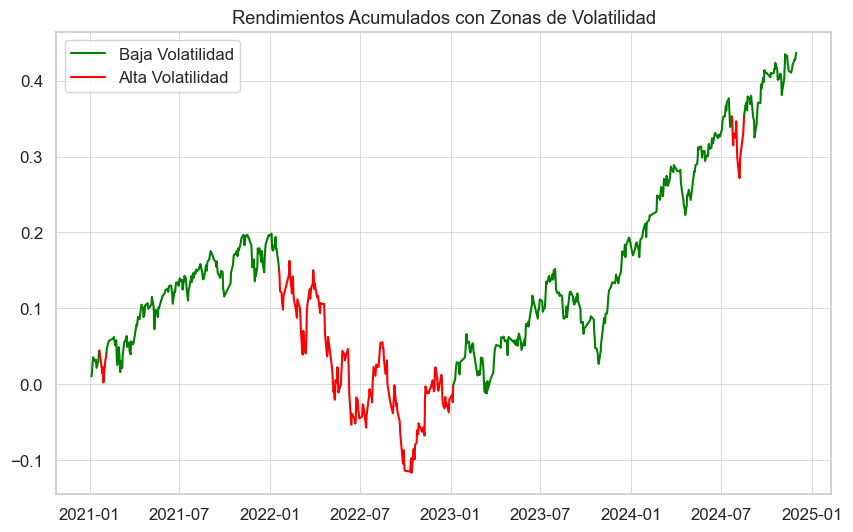

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [147]:
markov_cumrends_plot_line(mats_mark_r, column='MSCI', order=1, trend='n', autoregresion = True)

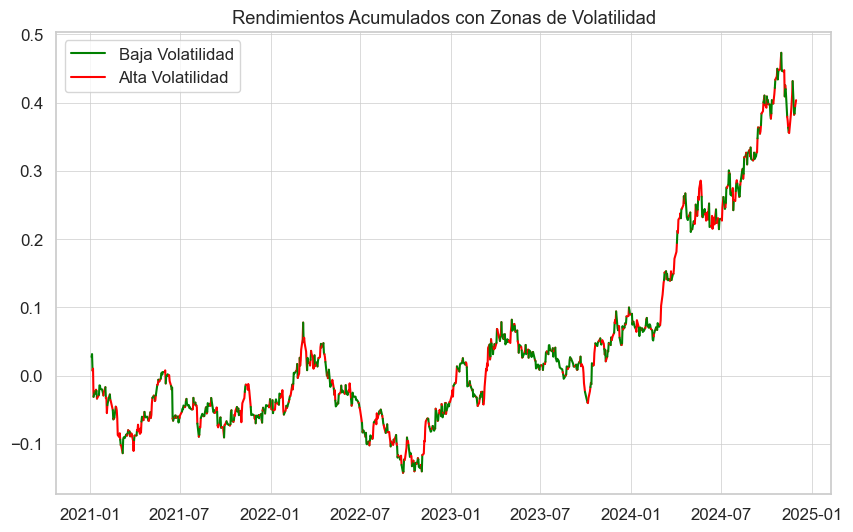

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [124]:
markov_cumrends_plot_line(materias_r, column='Oro', order=2, trend='c', autoregresion = True)

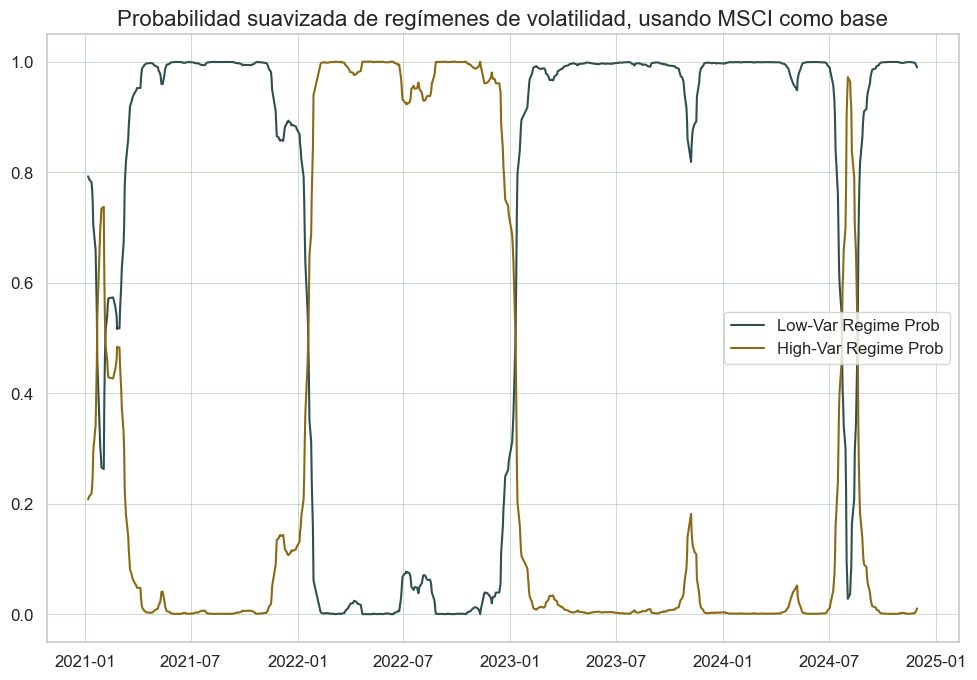

In [144]:
markov_prob_plot(mats_mark_r, column='MSCI', order=1, trend='n', autoregresion = True)

In [140]:
# Preparar dataframes para markov
mats_btc_mark = pd.concat([indices['MSCI'], mats_btc], axis=1)
mats_btc_mark_r = mats_btc_mark.dropna().pct_change().dropna()

mats_eth_mark = pd.concat([indices['MSCI'], mats_eth], axis=1)
mats_eth_mark_r = mats_eth_mark.dropna().pct_change().dropna()

mats_xrp_mark = pd.concat([indices['MSCI'], mats_xrp], axis=1)
mats_xrp_mark_r = mats_xrp_mark.dropna().pct_change().dropna()

mats_bnb_mark = pd.concat([indices['MSCI'], mats_bnb], axis=1)
mats_bnb_mark_r = mats_bnb_mark.dropna().pct_change().dropna()

mats_sol_mark = pd.concat([indices['MSCI'], mats_sol], axis=1)
mats_sol_mark_r = mats_sol_mark.dropna().pct_change().dropna()

mats_cry_mark = pd.concat([indices['MSCI'], mats_cry], axis=1)
mats_cry_mark_r = mats_cry_mark.dropna().pct_change().dropna()

,MSCI,Petroleo,Oro,Cobre,Gas_Natural,Plata,Maiz,Soja,Trigo,BTC
Date,,,,,,,,,,
2021-01-05 00:00:00+00:00,0.010308,0.048509,0.004114,0.024627,0.046881,0.010519,0.016537,0.025446,0.018692,0.063197
2021-01-06 00:00:00+00:00,0.005595,0.014020,-0.023455,0.002610,0.005181,-0.021689,0.006609,0.011296,-0.009939,0.083311
2021-01-07 00:00:00+00:00,0.010474,0.003950,0.002832,0.012466,0.004786,0.008416,-0.002020,-0.003479,-0.008108,0.069157
2021-01-08 00:00:00+00:00,0.008853,0.027740,-0.040893,-0.005953,-0.010627,-0.096250,0.004555,0.011209,-0.005450,0.036234
2021-01-12 00:00:00+00:00,-0.005244,0.018568,0.004798,-0.018647,0.019630,0.032625,0.042317,0.033618,0.041096,-0.168506
...,...,...,...,...,...,...,...,...,...,...
2024-11-22 00:00:00+00:00,0.003583,0.016262,0.014146,-0.009482,-0.062893,0.012843,-0.002929,0.005881,-0.008200,0.005004
2024-11-25 00:00:00+00:00,0.003487,-0.032285,-0.034355,0.004296,0.076702,-0.035102,-0.001763,0.002288,-0.015618,-0.059551
2024-11-26 00:00:00+00:00,0.001489,-0.002466,0.001338,-0.012831,0.018403,0.005892,-0.011183,-0.002283,0.007000,-0.011997


In [ ]:
# Markov Auto-Regresion
mats_btc_amark= markov_autoregression(mats_btc_mark_r, column='MSCI', order=1, trend='n')
mats_eth_amark= markov_autoregression(mats_eth_mark_r, column='MSCI', order=1, trend='n')
mats_xrp_amark= markov_autoregression(mats_xrp_mark_r, column='MSCI', order=1, trend='n')
mats_bnb_amark= markov_autoregression(mats_bnb_mark_r, column='MSCI', order=1, trend='n')
mats_sol_amark= markov_autoregression(mats_sol_mark_r, column='MSCI', order=1, trend='n')
mats_cry_amark= markov_autoregression(mats_cry_mark_r, column='MSCI', order=1, trend='n')

In [ ]:
# Datos de alta y baja volatilidad
mats_btc_lvar = mats_btc_amark['l_var'].drop(columns='MSCI')
mats_btc_hvar = mats_btc_amark['h_var'].drop(columns='MSCI')

mats_eth_lvar = mats_eth_amark['l_var'].drop(columns='MSCI')
mats_eth_hvar = mats_eth_amark['h_var'].drop(columns='MSCI')

mats_xrp_lvar = mats_xrp_amark['l_var'].drop(columns='MSCI')
mats_xrp_hvar = mats_xrp_amark['h_var'].drop(columns='MSCI')

mats_bnb_lvar = mats_bnb_amark['l_var'].drop(columns='MSCI')
mats_bnb_hvar = mats_bnb_amark['h_var'].drop(columns='MSCI')

mats_sol_lvar = mats_sol_amark['l_var'].drop(columns='MSCI')
mats_sol_hvar = mats_sol_amark['h_var'].drop(columns='MSCI')

mats_cry_lvar = mats_cry_amark['l_var'].drop(columns='MSCI')
mats_cry_hvar = mats_cry_amark['h_var'].drop(columns='MSCI')

### México

In [151]:
# Markov Regresion
mex_mark = pd.concat([indices['Mexico'], mex_acciones], axis=1)
mex_mark_r = mex_mark.dropna().pct_change().dropna()
mex_amark= markov_autoregression(mex_mark_r, column='Mexico', order=1, trend='n')

mex_lvar = mex_amark['l_var'].drop(columns='Mexico')
mex_hvar = mex_amark['h_var'].drop(columns='Mexico')

In [ ]:
# Markov Regresion plot cumrends
markov_cumrends_plot_line(mex_mark_r, column='Mexico', order=1, trend='n', autoregresion = True)

In [ ]:
# Markov Regresion plot prob
markov_prob_plot(mex_mark_r, column='Mexico', order=1, trend='n', autoregresion = True)

In [ ]:
# Preparar dataframes para markov
mex_btc_mark = pd.concat([indices['Mexico'], mex_acc_btc], axis=1)
mex_btc_mark_r = mex_btc_mark.dropna().pct_change().dropna()

mex_eth_mark = pd.concat([indices['Mexico'], mex_acc_eth], axis=1)
mex_eth_mark_r = mex_eth_mark.dropna().pct_change().dropna()

mex_xrp_mark = pd.concat([indices['Mexico'], mex_acc_xrp], axis=1)
mex_xrp_mark_r = mex_xrp_mark.dropna().pct_change().dropna()

mex_bnb_mark = pd.concat([indices['Mexico'], mex_acc_bnb], axis=1)
mex_bnb_mark_r = mex_bnb_mark.dropna().pct_change().dropna()

mex_sol_mark = pd.concat([indices['Mexico'], mex_acc_sol], axis=1)
mex_sol_mark_r = mex_sol_mark.dropna().pct_change().dropna()

mex_cry_mark = pd.concat([indices['Mexico'], mex_acc_cry], axis=1)
mex_cry_mark_r = mex_cry_mark.dropna().pct_change().dropna()

In [ ]:
# Markov Auto-Regresion
mex_btc_amark= markov_autoregression(mex_btc_mark_r, column='Mexico', order=1, trend='n')
mex_eth_amark= markov_autoregression(mex_eth_mark_r, column='Mexico', order=1, trend='n')
mex_xrp_amark= markov_autoregression(mex_xrp_mark_r, column='Mexico', order=1, trend='n')
mex_bnb_amark= markov_autoregression(mex_bnb_mark_r, column='Mexico', order=1, trend='n')
mex_sol_amark= markov_autoregression(mex_sol_mark_r, column='Mexico', order=1, trend='n')
mex_cry_amark= markov_autoregression(mex_cry_mark_r, column='Mexico', order=1, trend='n')

In [ ]:
# Datos de alta y baja volatilidad
mex_btc_lvar = mex_btc_amark['l_var'].drop(columns='Mexico')
mex_btc_hvar = mex_btc_amark['h_var'].drop(columns='Mexico')

mex_eth_lvar = mex_eth_amark['l_var'].drop(columns='Mexico')
mex_eth_hvar = mex_eth_amark['h_var'].drop(columns='Mexico')

mex_xrp_lvar = mex_xrp_amark['l_var'].drop(columns='Mexico')
mex_xrp_hvar = mex_xrp_amark['h_var'].drop(columns='Mexico')

mex_bnb_lvar = mex_bnb_amark['l_var'].drop(columns='Mexico')
mex_bnb_hvar = mex_bnb_amark['h_var'].drop(columns='Mexico')

mex_sol_lvar = mex_sol_amark['l_var'].drop(columns='Mexico')
mex_sol_hvar = mex_sol_amark['h_var'].drop(columns='Mexico')

mex_cry_lvar = mex_cry_amark['l_var'].drop(columns='Mexico')
mex_cry_hvar = mex_cry_amark['h_var'].drop(columns='Mexico')

### Estados unidos

In [ ]:
# Markov Regresion
usa_mark = pd.concat([indices['USA'], usa_acciones], axis=1)
usa_mark_r = usa_mark.dropna().pct_change().dropna()
usa_amark= markov_autoregression(usa_mark_r, column='USA', order=1, trend='n')

usa_lvar = usa_amark['l_var'].drop(columns='USA')
usa_hvar = usa_amark['h_var'].drop(columns='USA')

In [ ]:
# Markov Regresion plot cumrends
markov_cumrends_plot_line(usa_mark_r, column='USA', order=1, trend='n', autoregresion = True)

In [ ]:
# Markov Regresion plot prob
markov_prob_plot(usa_mark_r, column='USA', order=1, trend='n', autoregresion = True)

In [ ]:
# Preparar dataframes para markov
usa_btc_mark = pd.concat([indices['USA'], usa_acc_btc], axis=1)
usa_btc_mark_r = usa_btc_mark.dropna().pct_change().dropna()

usa_eth_mark = pd.concat([indices['USA'], usa_acc_eth], axis=1)
usa_eth_mark_r = usa_eth_mark.dropna().pct_change().dropna()

usa_xrp_mark = pd.concat([indices['USA'], usa_acc_xrp], axis=1)
usa_xrp_mark_r = usa_xrp_mark.dropna().pct_change().dropna()

usa_bnb_mark = pd.concat([indices['USA'], usa_acc_bnb], axis=1)
usa_bnb_mark_r = usa_bnb_mark.dropna().pct_change().dropna()

usa_sol_mark = pd.concat([indices['USA'], usa_acc_sol], axis=1)
usa_sol_mark_r = usa_sol_mark.dropna().pct_change().dropna()

usa_cry_mark = pd.concat([indices['USA'], usa_acc_cry], axis=1)
usa_cry_mark_r = usa_cry_mark.dropna().pct_change().dropna()

In [ ]:
# Markov Auto-Regresion
usa_btc_amark= markov_autoregression(usa_btc_mark_r, column='USA', order=1, trend='n')
usa_eth_amark= markov_autoregression(usa_eth_mark_r, column='USA', order=1, trend='n')
usa_xrp_amark= markov_autoregression(usa_xrp_mark_r, column='USA', order=1, trend='n')
usa_bnb_amark= markov_autoregression(usa_bnb_mark_r, column='USA', order=1, trend='n')
usa_sol_amark= markov_autoregression(usa_sol_mark_r, column='USA', order=1, trend='n')
usa_cry_amark= markov_autoregression(usa_cry_mark_r, column='USA', order=1, trend='n')

In [ ]:
# Datos de alta y baja volatilidad
usa_btc_lvar = usa_btc_amark['l_var'].drop(columns='USA')
usa_btc_hvar = usa_btc_amark['h_var'].drop(columns='USA')

usa_eth_lvar = usa_eth_amark['l_var'].drop(columns='USA')
usa_eth_hvar = usa_eth_amark['h_var'].drop(columns='USA')

usa_xrp_lvar = usa_xrp_amark['l_var'].drop(columns='USA')
usa_xrp_hvar = usa_xrp_amark['h_var'].drop(columns='USA')

usa_bnb_lvar = usa_bnb_amark['l_var'].drop(columns='USA')
usa_bnb_hvar = usa_bnb_amark['h_var'].drop(columns='USA')

usa_sol_lvar = usa_sol_amark['l_var'].drop(columns='USA')
usa_sol_hvar = usa_sol_amark['h_var'].drop(columns='USA')

usa_cry_lvar = usa_cry_amark['l_var'].drop(columns='USA')
usa_cry_hvar = usa_cry_amark['h_var'].drop(columns='USA')

### China

## Portafolios Markov